In [259]:
#from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from haversine import haversine
from datetime import datetime
import seaborn as sns
import matplotlib
from matplotlib.pyplot import figure
#import geopandas as gpd
#from geopandas import GeoDataFrame
from matplotlib.dates import DateFormatter

In [260]:
df = pd.read_csv(r'../../data/tidy/large/vehicle-locations-Apr2022.csv', delimiter=',', skiprows=0, low_memory=False)

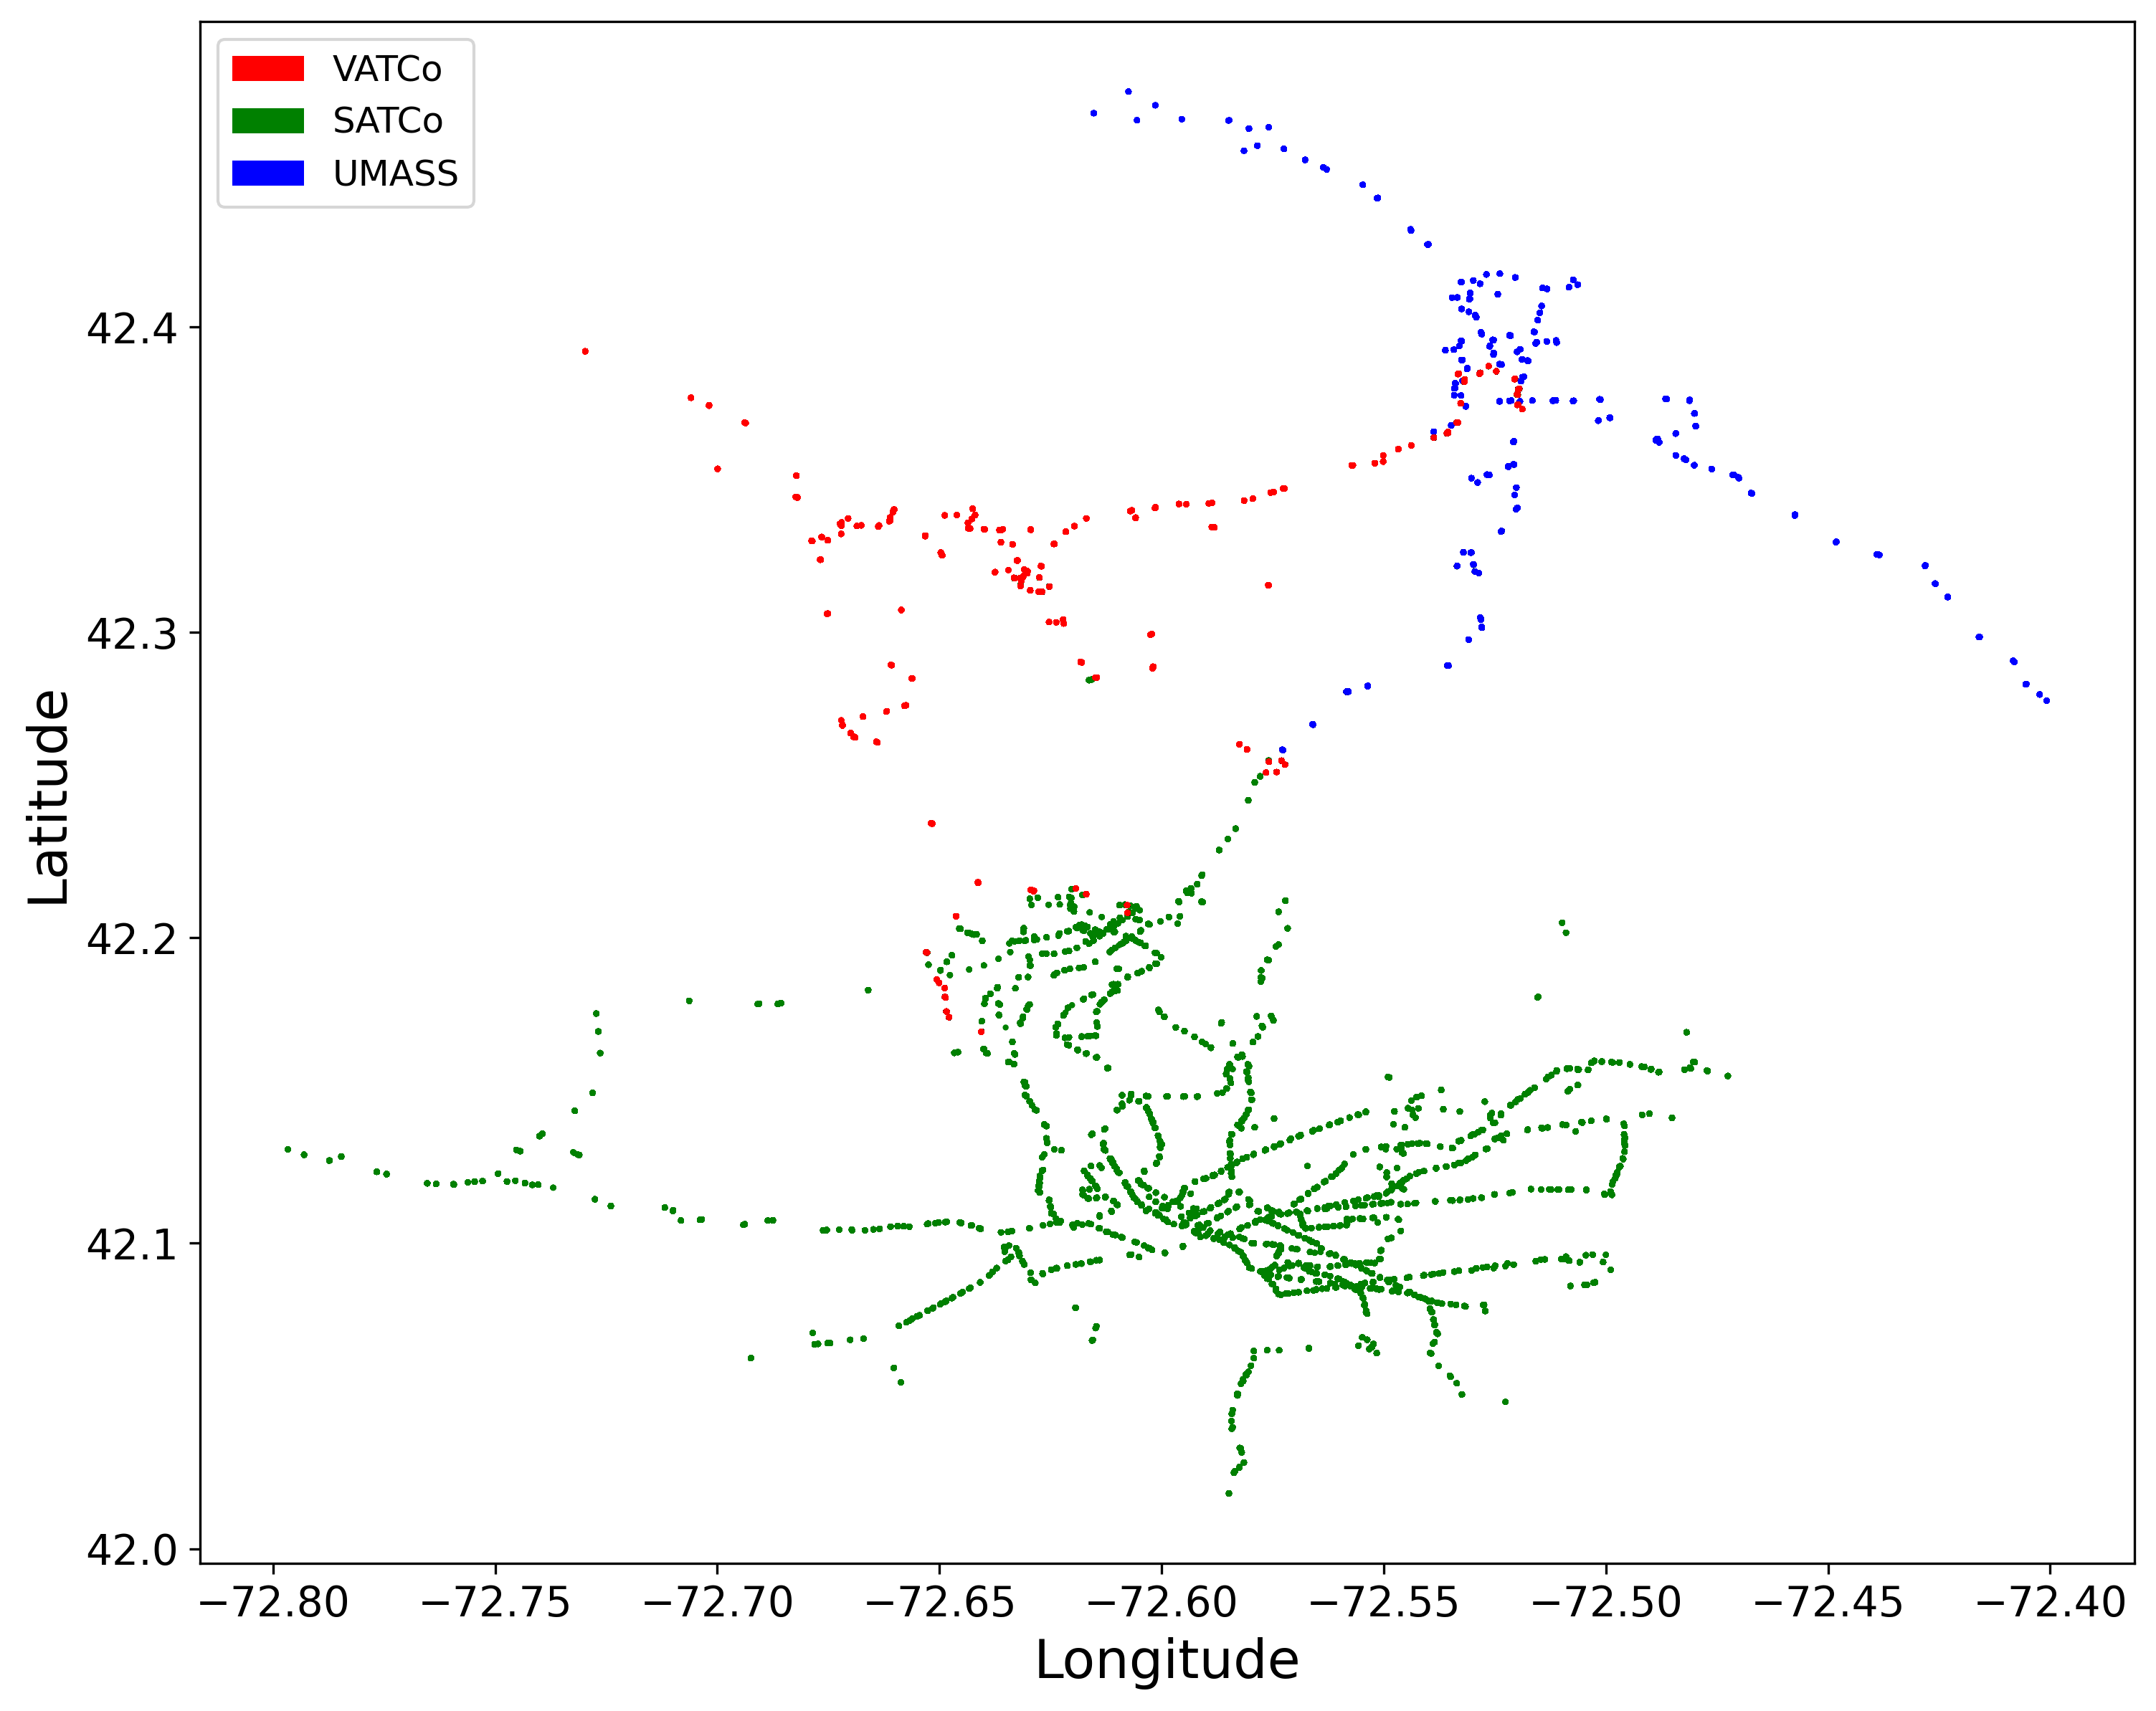

In [261]:
plt.figure(figsize=(10, 8), dpi=300)
colors = {'VATCo':'red', 'SATCo':'green', 'UMASS':'blue'}
plt.scatter(x=df['Lon'], y=df['Lat'], c= df['Operator'].map(colors), s=1)
plt.xlabel("Longitude", fontsize=18)
plt.ylabel("Latitude", fontsize=18)

circ1 = mpatches.Patch(facecolor='red',label='VATCo')
circ2= mpatches.Patch(facecolor='green',label='SATCo')
circ3 = mpatches.Patch(facecolor='blue',label='UMASS')

plt.legend(handles = [circ1,circ2,circ3],loc=2,fontsize=12)
plt.tight_layout()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.savefig(r'../../figures/operators-stops.png', dpi=400, bbox_inches='tight')
plt.show()

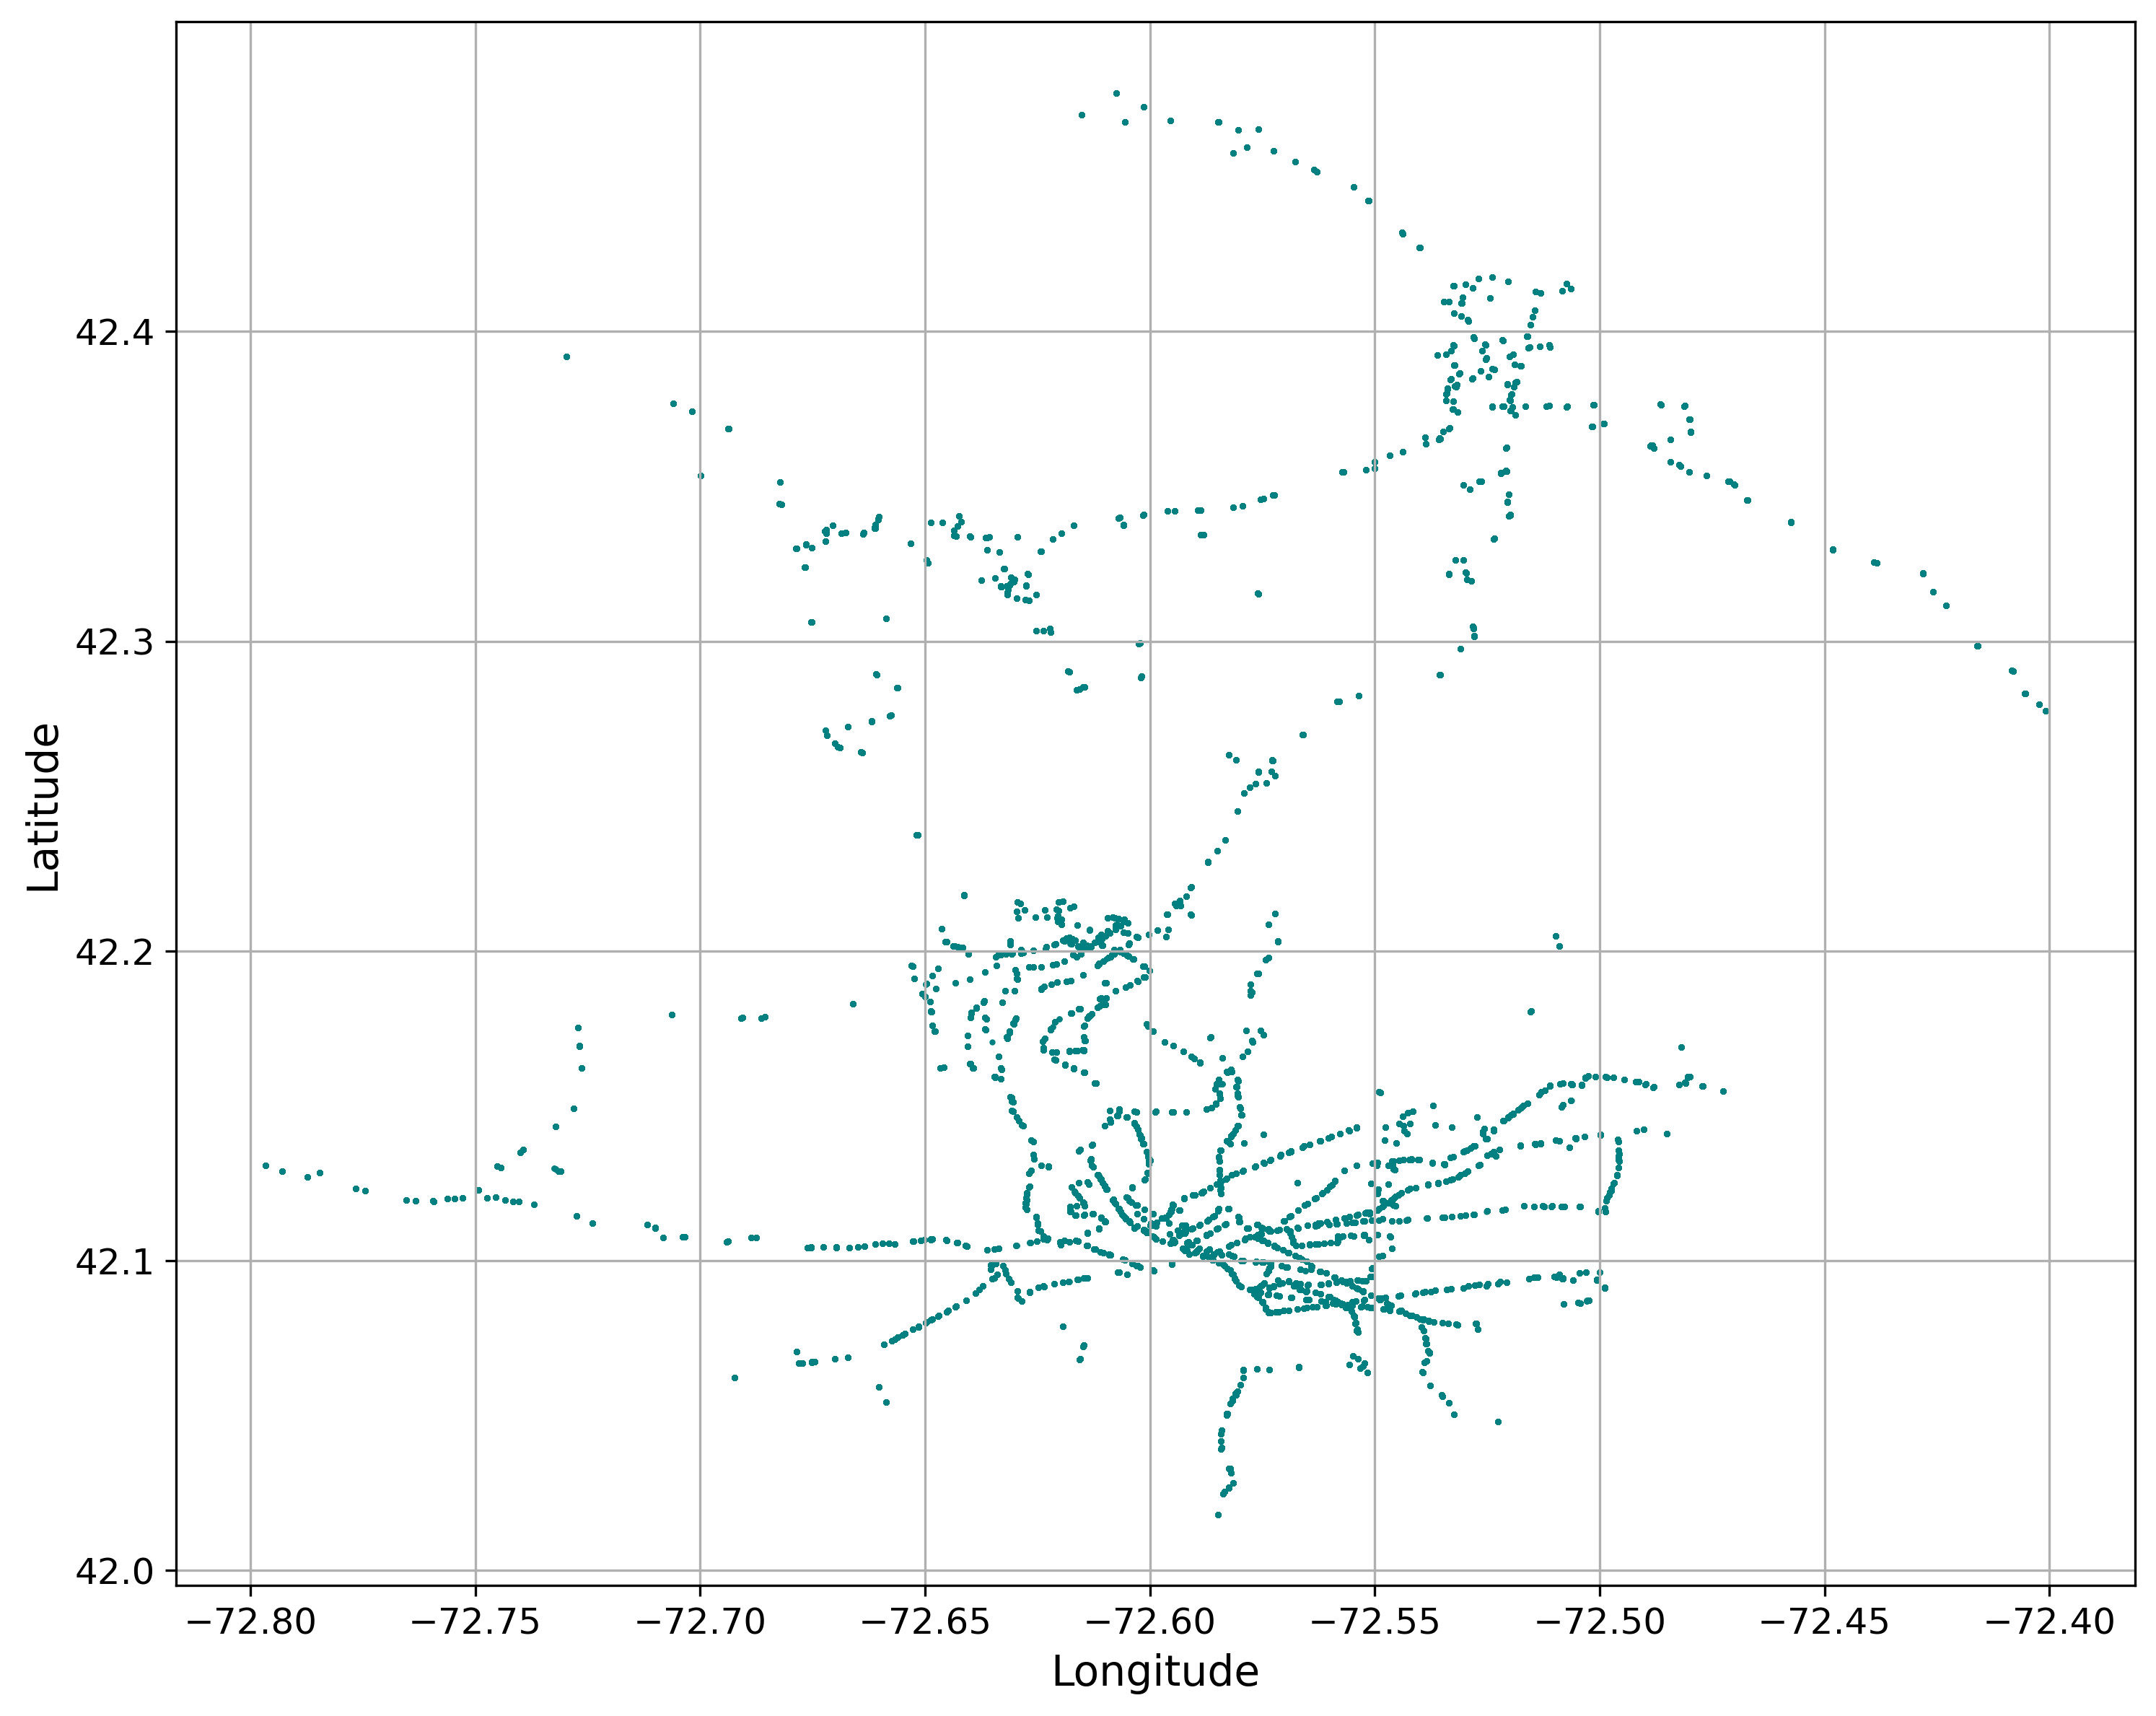

In [262]:
# ver02
plt.figure(figsize=(10, 8), dpi=300)
plt.scatter(x=df['Lon'], y=df['Lat'], s=1, color="teal")
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

circ1 = mpatches.Patch(facecolor='red',label='VATCo')
circ2= mpatches.Patch(facecolor='green',label='SATCo')
circ3 = mpatches.Patch(facecolor='blue',label='UMASS')

#plt.legend(handles = [circ1,circ2,circ3],loc=2,fontsize=12)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()

plt.savefig(r'../../figures/operators-stops.png', dpi=400, bbox_inches='tight')
plt.show()

In [263]:
len(df.Vehicle.unique())

178

In [264]:
#vehicles=df.Vehicle.unique()

In [265]:
df.sort_values(by=['Vehicle','ServiceDateTime'], ascending=True, inplace=True)

In [266]:
df['ServiceDateTime']= pd.to_datetime(df['ServiceDateTime'])

In [267]:
df['time_delta'] = df.groupby(['Vehicle', 'Date'])['ServiceDateTime'].diff()

In [268]:
df.time_delta=df.time_delta.astype(str).str.replace('0 days ', '')

In [269]:
df['time_delta']= pd.to_datetime(df['time_delta'])

In [270]:
df['time_delta_in_seconds'] = df['time_delta'].dt.hour * 3600 + df['time_delta'].dt.minute * 60 + df['time_delta'].dt.second

In [271]:
#46765 data points with time intervals less than 2 sec are filtered 
#df

In [272]:
#calculating distances by unique vehicle Id and unique day
dist=[]
for i in df.index:
    if i==0:
        dist.append(0) 
    else:
        if df['Vehicle'].loc[i]==df['Vehicle'].loc[i-1]:
            if df['Date'].loc[i]==df['Date'].loc[i-1]:           
                coordinate_x = (df['Lon'].loc[i] ,df['Lat'].loc[i]) # (lat, lon) for x
                coordinate_x_minus_1 = (df['Lon'].loc[i-1] ,df['Lat'].loc[i-1]) #(lat, lon) for x-1
                distance=haversine(coordinate_x_minus_1, coordinate_x, unit='mi')
                dist.append(distance) 
            else:
                #dist.append('nan')
                dist.append(0) 
        else:   
            #dist.append('nan')
            dist.append(0) 
df['dist'] = dist
#df.to_csv(r'../../results/computed-distances.csv')

In [273]:
#calculating speed by unique vehicle Id and unique day
speed=[]
for i in df.index:
    if i==0 or i==1:
        speed.append(0) 
    else:
        if df['Vehicle'].loc[i]==df['Vehicle'].loc[i-1]:
            if df['Date'].loc[i]==df['Date'].loc[i-1]:
                FMT = '%H:%M:%S'
                time_diff = abs(datetime.strptime(df['time'].loc[i-1], FMT) - datetime.strptime(df['time'].loc[i], FMT)).total_seconds() / 3600.0
                distance = df['dist'].loc[i]
                if time_diff==0:
                    speed.append(0)
                else:
                    speed_current=distance/time_diff
                    if speed_current>=90:
                        speed.append(90) 
                    else:    
                        speed.append(speed_current)
                    #speed.append(speed_current)
            else:
                #speed.append('nan')
                speed.append(0) 
        else:   
            #speed.append('nan')
            speed.append(0) 
df['speed'] = speed
#df.to_csv(r'../../results/computed-speeds.csv')

In [274]:
#calculating acceleration by unique vehicle Id and unique day
acc=[]
for i in df.index:
    if i==0 or i==1 or i==2:
        acc.append(0) 
    else:
        if df['Vehicle'].loc[i]==df['Vehicle'].loc[i-1]:
            if df['Date'].loc[i]==df['Date'].loc[i-1]:
                FMT = '%H:%M:%S'
                time_diff = abs(datetime.strptime(df['time'].loc[i-1], FMT) - datetime.strptime(df['time'].loc[i], FMT)).total_seconds() / 3600.0
                #if df['speed'].loc[i-1]=='nan':
                #    df['speed'].loc[i-1]==0
                #else:
                #    pass
                speed_diff = df['speed'].loc[i] - df['speed'].loc[i-1]
                if time_diff==0:
                    acc.append(0) 
                else:
                    acc_current=(speed_diff/time_diff)*0.00012417777777778 # 1 miles/h2 = 0.00012417777777778 m/s2
                    #if -5<acc_current<5:
                    #    acc.append(acc_current)
                    #else:
                    #    acc.append(0)
                    acc.append(acc_current)
            else:
                #acc.append('nan')
                acc.append(0) 
        else:   
            #acc.append('nan')
            acc.append(0) 
df['acc'] = acc
#df.to_csv(r'../../results/computed-trajectories2.csv')

In [284]:
# Make a copy of df with calculated trajectories
df_copy=df.copy()

In [285]:
df_copy

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
0       2022-04-04 06:43:24      112564     8763  2022-04-04 00:00:00.000   
1       2022-04-04 06:51:27      109326     8763  2022-04-04 00:00:00.000   
2       2022-04-04 06:51:27      112565     8763  2022-04-04 00:00:00.000   
3       2022-04-04 06:52:52      109327     8763  2022-04-04 00:00:00.000   
4       2022-04-04 06:54:33      109328     8763  2022-04-04 00:00:00.000   
...                     ...         ...      ...                      ...   
1361544 2022-04-30 23:54:20     1325566     8789  2022-04-30 00:00:00.000   
1361545 2022-04-30 23:55:24     1325567     8789  2022-04-30 00:00:00.000   
1361546 2022-04-30 23:56:47     1325568     8789  2022-04-30 00:00:00.000   
1361547 2022-04-30 23:57:32     1325569     8789  2022-04-30 00:00:00.000   
1361548 2022-04-30 23:59:29     1325570     8789  2022-04-30 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
0        2022      4      1    VATCo   3519    1006  ...     43     24   
1        2022      4      1    VATCo   3513    3380  ...     51     27   
2        2022      4      1    VATCo   3519    1006  ...     51     27   
3        2022      4      1    VATCo   3513    3380  ...     52     52   
4        2022      4      1    VATCo   3513    3380  ...     54     33   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1361544  2022      4      1    VATCo   3515    1001  ...     54     20   
1361545  2022      4      1    VATCo   3515    1001  ...     55     24   
1361546  2022      4      1    VATCo   3515    1001  ...     56     47   
1361547  2022      4      1    VATCo   3515    1001  ...     57     32   
1361548  2022      4      1    VATCo   3515    1001  ...     59     29   

               Date  Daytype      time          time_delta  \
0        2022-04-04  Weekday  06:43:24                 NaT   
1        2022-04-04  Weekday  06:51:27 2022-12-04 00:08:03   
2        2022-04-04  Weekday  06:51:27 2022-12-04 00:00:00   
3        2022-04-04  Weekday  06:52:52 2022-12-04 00:01:25   
4        2022-04-04  Weekday  06:54:33 2022-12-04 00:01:41   
...             ...      ...       ...                 ...   
1361544  2022-04-30  Weekend  23:54:20 2022-12-04 00:02:20   
1361545  2022-04-30  Weekend  23:55:24 2022-12-04 00:01:04   
1361546  2022-04-30  Weekend  23:56:47 2022-12-04 00:01:23   
1361547  2022-04-30  Weekend  23:57:32 2022-12-04 00:00:45   
1361548  2022-04-30  Weekend  23:59:29 2022-12-04 00:01:57   

        time_delta_in_seconds      dist      speed       acc  
0                         NaN  0.000000   0.000000  0.000000  
1                       483.0  0.627342   0.000000  0.000000  
2                         0.0  0.000000   0.000000  0.000000  
3                        85.0  0.313431  13.274729  0.069816  
4                       101.0  0.421734  15.032101  0.007778  
...                       ...       ...        ...       ...  
1361544                 140.0  0.254140   6.535024  0.003673  
1361545                  64.0  0.156799   8.819951  0.015960  
1361546                  83.0  0.144950   6.286980 -0.013643  
1361547                  45.0  0.151259  12.100708  0.057755  
1361548                 117.0  0.780486  24.014951  0.045523  

[1361549 rows x 40 columns]

In [286]:
# Filter data points with time intervals less than 2 seconds and distance greater than 0
df_copy.loc[(df_copy['time_delta_in_seconds'] < 2) & (df_copy['dist'] > 0)]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
24557   2022-04-12 12:34:33      491343     8771  2022-04-12 00:00:00.000   
27075   2022-04-20 12:01:02      877849     8779  2022-04-20 00:00:00.000   
38970   2022-04-01 06:31:46       43700     8760  2022-04-01 00:00:00.000   
61705   2022-04-27 06:30:21     1164619     8786  2022-04-27 00:00:00.000   
61706   2022-04-27 06:30:21     1196708     8786  2022-04-27 00:00:00.000   
...                     ...         ...      ...                      ...   
1313677 2022-04-11 08:23:00      434247     8770  2022-04-11 00:00:00.000   
1329929 2022-04-05 18:00:01      163589     8764  2022-04-05 00:00:00.000   
1335234 2022-04-08 11:12:01      324247     8767  2022-04-08 00:00:00.000   
1358827 2022-04-21 00:06:01      902475     8780  2022-04-21 00:00:00.000   
1359771 2022-04-24 19:43:01     1039311     8783  2022-04-24 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
24557    2022      4      2    SATCo   3631    1104  ...     34     33   
27075    2022      4      2    SATCo   3653    1096  ...      1      2   
38970    2022      4      2    SATCo   3630    1104  ...     31     46   
61705    2022      4      2    SATCo   3631    1104  ...     30     21   
61706    2022      4      2    SATCo   3655    1099  ...     30     21   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1313677  2022      4      1    VATCo   3515    1001  ...     23      0   
1329929  2022      4      1    VATCo   3514    3381  ...      0      1   
1335234  2022      4      1    VATCo   3515    1001  ...     12      1   
1358827  2022      4      1    VATCo   3515    1001  ...      6      1   
1359771  2022      4      1    VATCo   3515    1001  ...     43      1   

               Date  Daytype      time          time_delta  \
24557    2022-04-12  Weekday  12:34:33 2022-12-04 00:00:00   
27075    2022-04-20  Weekday  12:01:02 2022-12-04 00:00:00   
38970    2022-04-01  Weekday  06:31:46 2022-12-04 00:00:00   
61705    2022-04-27  Weekday  06:30:21 2022-12-04 00:00:00   
61706    2022-04-27  Weekday  06:30:21 2022-12-04 00:00:00   
...             ...      ...       ...                 ...   
1313677  2022-04-11  Weekday  08:23:00 2022-12-04 00:00:00   
1329929  2022-04-05  Weekday  18:00:01 2022-12-04 00:00:01   
1335234  2022-04-08  Weekday  11:12:01 2022-12-04 00:00:01   
1358827  2022-04-21  Weekday  00:06:01 2022-12-04 00:00:01   
1359771  2022-04-24  Weekend  19:43:01 2022-12-04 00:00:01   

        time_delta_in_seconds      dist  speed      acc  
24557                     0.0  0.011762    0.0   0.0000  
27075                     0.0  0.011762    0.0   0.0000  
38970                     0.0  0.013400    0.0   0.0000  
61705                     0.0  0.013400    0.0   0.0000  
61706                     0.0  0.013400    0.0   0.0000  
...                       ...       ...    ...      ...  
1313677                   0.0  0.295510    0.0   0.0000  
1329929                   1.0  0.095676   90.0  40.2336  
1335234                   1.0  0.071477   90.0  40.2336  
1358827                   1.0  0.071477   90.0  40.2336  
1359771                   1.0  0.071477   90.0  40.2336  

[296 rows x 40 columns]

In [289]:
# Drop rows with time intervals less than 2 seconds and distance greater than 0 (296 rows)
df_copy.drop(df_copy.loc[(df_copy["time_delta_in_seconds"] <2) & (df_copy["dist"] > 0)].index, inplace=True)

In [290]:
df_copy

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
0       2022-04-04 06:43:24      112564     8763  2022-04-04 00:00:00.000   
1       2022-04-04 06:51:27      109326     8763  2022-04-04 00:00:00.000   
2       2022-04-04 06:51:27      112565     8763  2022-04-04 00:00:00.000   
3       2022-04-04 06:52:52      109327     8763  2022-04-04 00:00:00.000   
4       2022-04-04 06:54:33      109328     8763  2022-04-04 00:00:00.000   
...                     ...         ...      ...                      ...   
1361544 2022-04-30 23:54:20     1325566     8789  2022-04-30 00:00:00.000   
1361545 2022-04-30 23:55:24     1325567     8789  2022-04-30 00:00:00.000   
1361546 2022-04-30 23:56:47     1325568     8789  2022-04-30 00:00:00.000   
1361547 2022-04-30 23:57:32     1325569     8789  2022-04-30 00:00:00.000   
1361548 2022-04-30 23:59:29     1325570     8789  2022-04-30 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
0        2022      4      1    VATCo   3519    1006  ...     43     24   
1        2022      4      1    VATCo   3513    3380  ...     51     27   
2        2022      4      1    VATCo   3519    1006  ...     51     27   
3        2022      4      1    VATCo   3513    3380  ...     52     52   
4        2022      4      1    VATCo   3513    3380  ...     54     33   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1361544  2022      4      1    VATCo   3515    1001  ...     54     20   
1361545  2022      4      1    VATCo   3515    1001  ...     55     24   
1361546  2022      4      1    VATCo   3515    1001  ...     56     47   
1361547  2022      4      1    VATCo   3515    1001  ...     57     32   
1361548  2022      4      1    VATCo   3515    1001  ...     59     29   

               Date  Daytype      time          time_delta  \
0        2022-04-04  Weekday  06:43:24                 NaT   
1        2022-04-04  Weekday  06:51:27 2022-12-04 00:08:03   
2        2022-04-04  Weekday  06:51:27 2022-12-04 00:00:00   
3        2022-04-04  Weekday  06:52:52 2022-12-04 00:01:25   
4        2022-04-04  Weekday  06:54:33 2022-12-04 00:01:41   
...             ...      ...       ...                 ...   
1361544  2022-04-30  Weekend  23:54:20 2022-12-04 00:02:20   
1361545  2022-04-30  Weekend  23:55:24 2022-12-04 00:01:04   
1361546  2022-04-30  Weekend  23:56:47 2022-12-04 00:01:23   
1361547  2022-04-30  Weekend  23:57:32 2022-12-04 00:00:45   
1361548  2022-04-30  Weekend  23:59:29 2022-12-04 00:01:57   

        time_delta_in_seconds      dist      speed       acc  
0                         NaN  0.000000   0.000000  0.000000  
1                       483.0  0.627342   0.000000  0.000000  
2                         0.0  0.000000   0.000000  0.000000  
3                        85.0  0.313431  13.274729  0.069816  
4                       101.0  0.421734  15.032101  0.007778  
...                       ...       ...        ...       ...  
1361544                 140.0  0.254140   6.535024  0.003673  
1361545                  64.0  0.156799   8.819951  0.015960  
1361546                  83.0  0.144950   6.286980 -0.013643  
1361547                  45.0  0.151259  12.100708  0.057755  
1361548                 117.0  0.780486  24.014951  0.045523  

[1361253 rows x 40 columns]

In [291]:
df_copy.to_csv(r'../../results/computed-trajectories2.csv')

In [292]:
# Filtering all rows related to interval less than 2 seconds
#df=df.drop(df[(df['time_delta_in_seconds'] !=0) & (df['time_delta_in_seconds']< 2)].index)
#df = df.loc[~((df['time_delta_in_seconds'] != 0) & (df['time_delta_in_seconds'] < 2)),:]

In [293]:
#fig, ax = plt.subplots(figsize=(25,25))
#for vehicle, gp in df.groupby('Vehicle'):
#    gp.plot(x='ServiceDateTime', y='dist', ax=ax, label=vehicle)

In [294]:
#import seaborn as sns
#sns.lineplot(data=df, hue='Vehicle', x='ServiceDateTime', y='dist')

In [295]:
#import seaborn as sns
#sns.lineplot(data=df, hue='Vehicle', x='ServiceDateTime', y='speed')

In [296]:
#import seaborn as sns
#sns.lineplot(data=df, hue='Vehicle', x='ServiceDateTime', y='acc')

In [297]:
#egs = [1205]
#ax=sns.relplot(x='ServiceDateTime', y='dist',
#            hue='Vehicle',
#            data=df.loc[df.Vehicle.isin(egs)],
#            kind='scatter', ci=None
#           )
#ax.fig.set_size_inches(25,25)

In [298]:
#egs = [1205]
#ax=sns.relplot(x='time', y='dist',
#            hue='Vehicle',
#            data=df.loc[df.Vehicle.isin(egs)],
#            kind='line', ci=None
#           )
#ax.fig.set_size_inches(25,25)

In [299]:
#sns.set(font_scale=2)
#egs = [1205, 1660, 1850, 3212, 7802]
#ax=sns.relplot(x='Hour', y='dist',
#            hue='Vehicle',
#            data=df.loc[df.Vehicle.isin(egs)],
#            kind='line', ci=None
#           )
#ax.fig.set_size_inches(25,25)
#ax.set(ylabel='Distance (mile)', xlabel='Day time')
#plt.show()

In [300]:
#sns.set(font_scale=2)
#egs = [1205, 1660, 1850, 3212, 7802]
#ax=sns.relplot(x='Hour', y='speed',
#            hue='Vehicle',
#            data=df.loc[df.Vehicle.isin(egs)],
#            kind='line', ci=None
#           )
#ax.fig.set_size_inches(25,25)
#ax.set(ylabel='Speed (mile/hr)', xlabel='Day time')
#plt.show()

In [301]:
#sns.set(font_scale=2)
#egs = [1205, 1660, 1850, 3212, 7802]
#ax=sns.relplot(x='Hour', y='acc',
#            hue='Vehicle',
#            data=df.loc[df.Vehicle.isin(egs)],
#            kind='line', ci=None
#           )
#ax.fig.set_size_inches(25,25)
#ax.set(ylabel='Acceleration (mile/hr^2)', xlabel='Day time')
#plt.show()

In [302]:
#egs = [1205, 1660]
#sns.relplot(x='ServiceDateTime', y='speed',
#            hue='Vehicle',
#            data=df.loc[df.Vehicle.isin(egs)],
#            kind='line', ci=None
#           )

In [303]:
#egs = [1205, 1660]
#sns.relplot(x='ServiceDateTime', y='acc',
#            hue='Vehicle',
#            data=df.loc[df.Vehicle.isin(egs)],
#            kind='line', ci=None
#           )

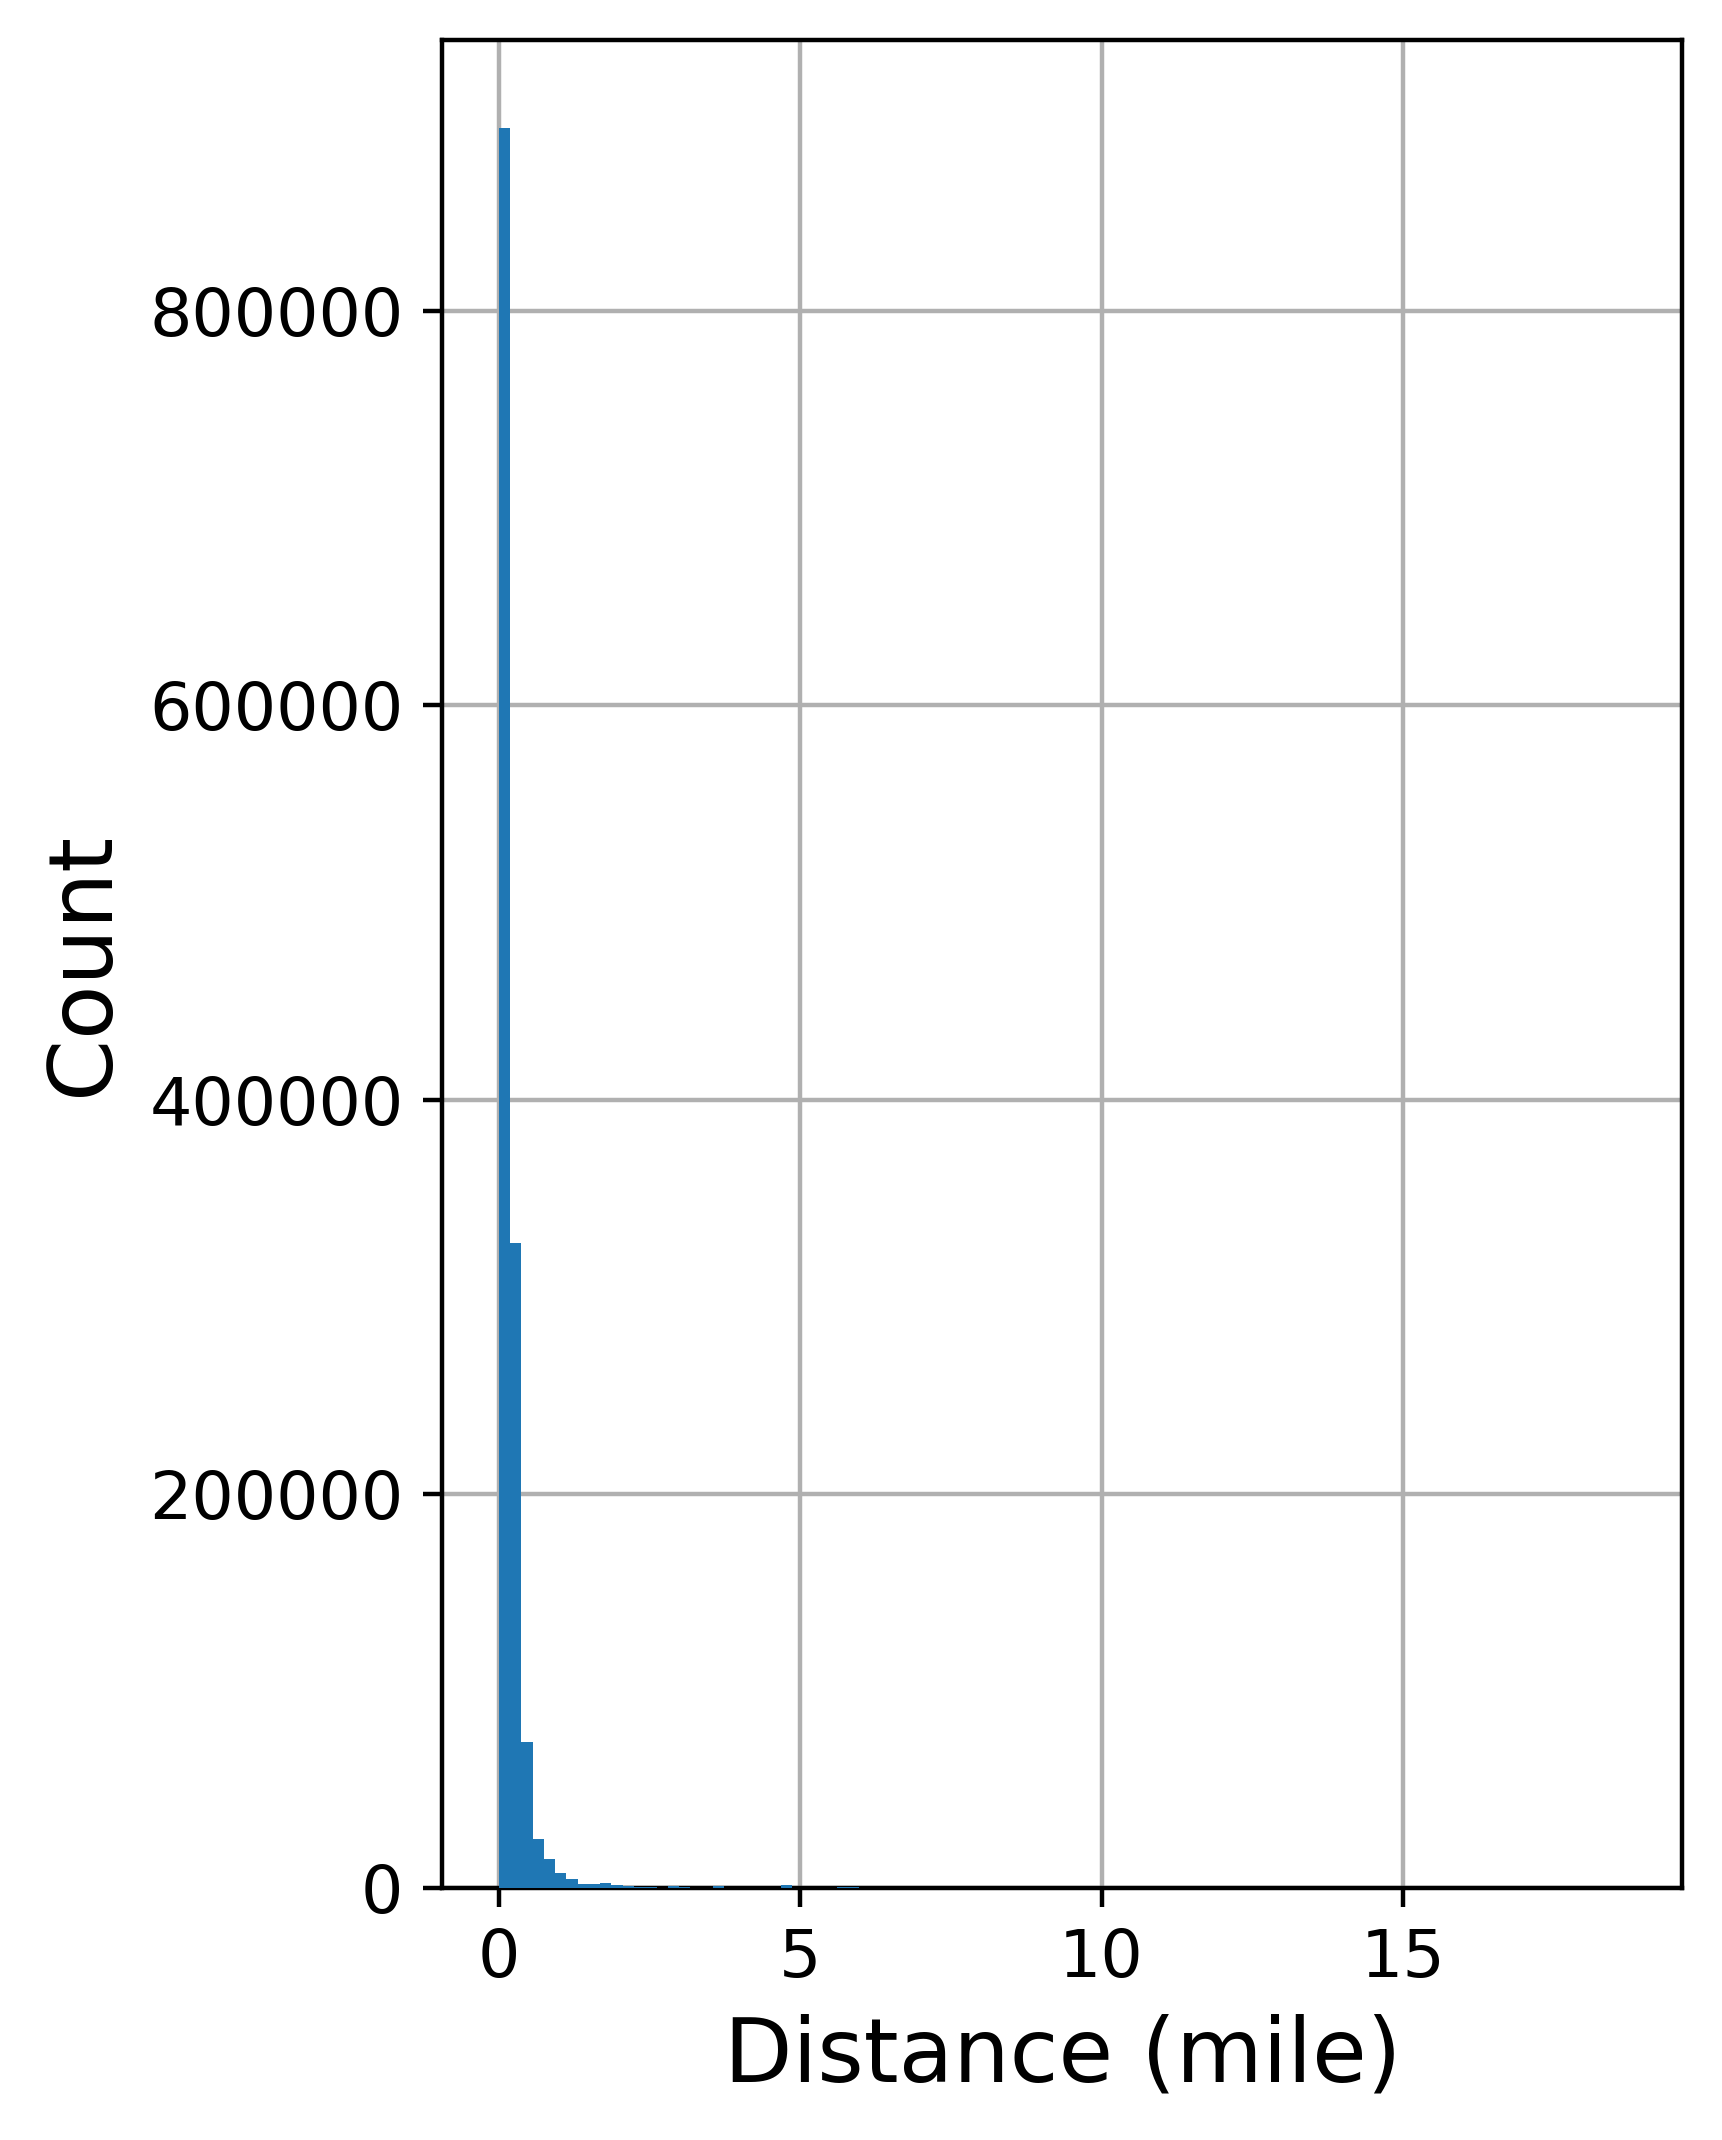

In [307]:
figure(figsize=(4 , 6), dpi=400)
ax=df_copy['dist'].hist(bins=100, zorder=3)
ax.set_xlabel('Distance (mile)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-distance.png', dpi=400, bbox_inches='tight')

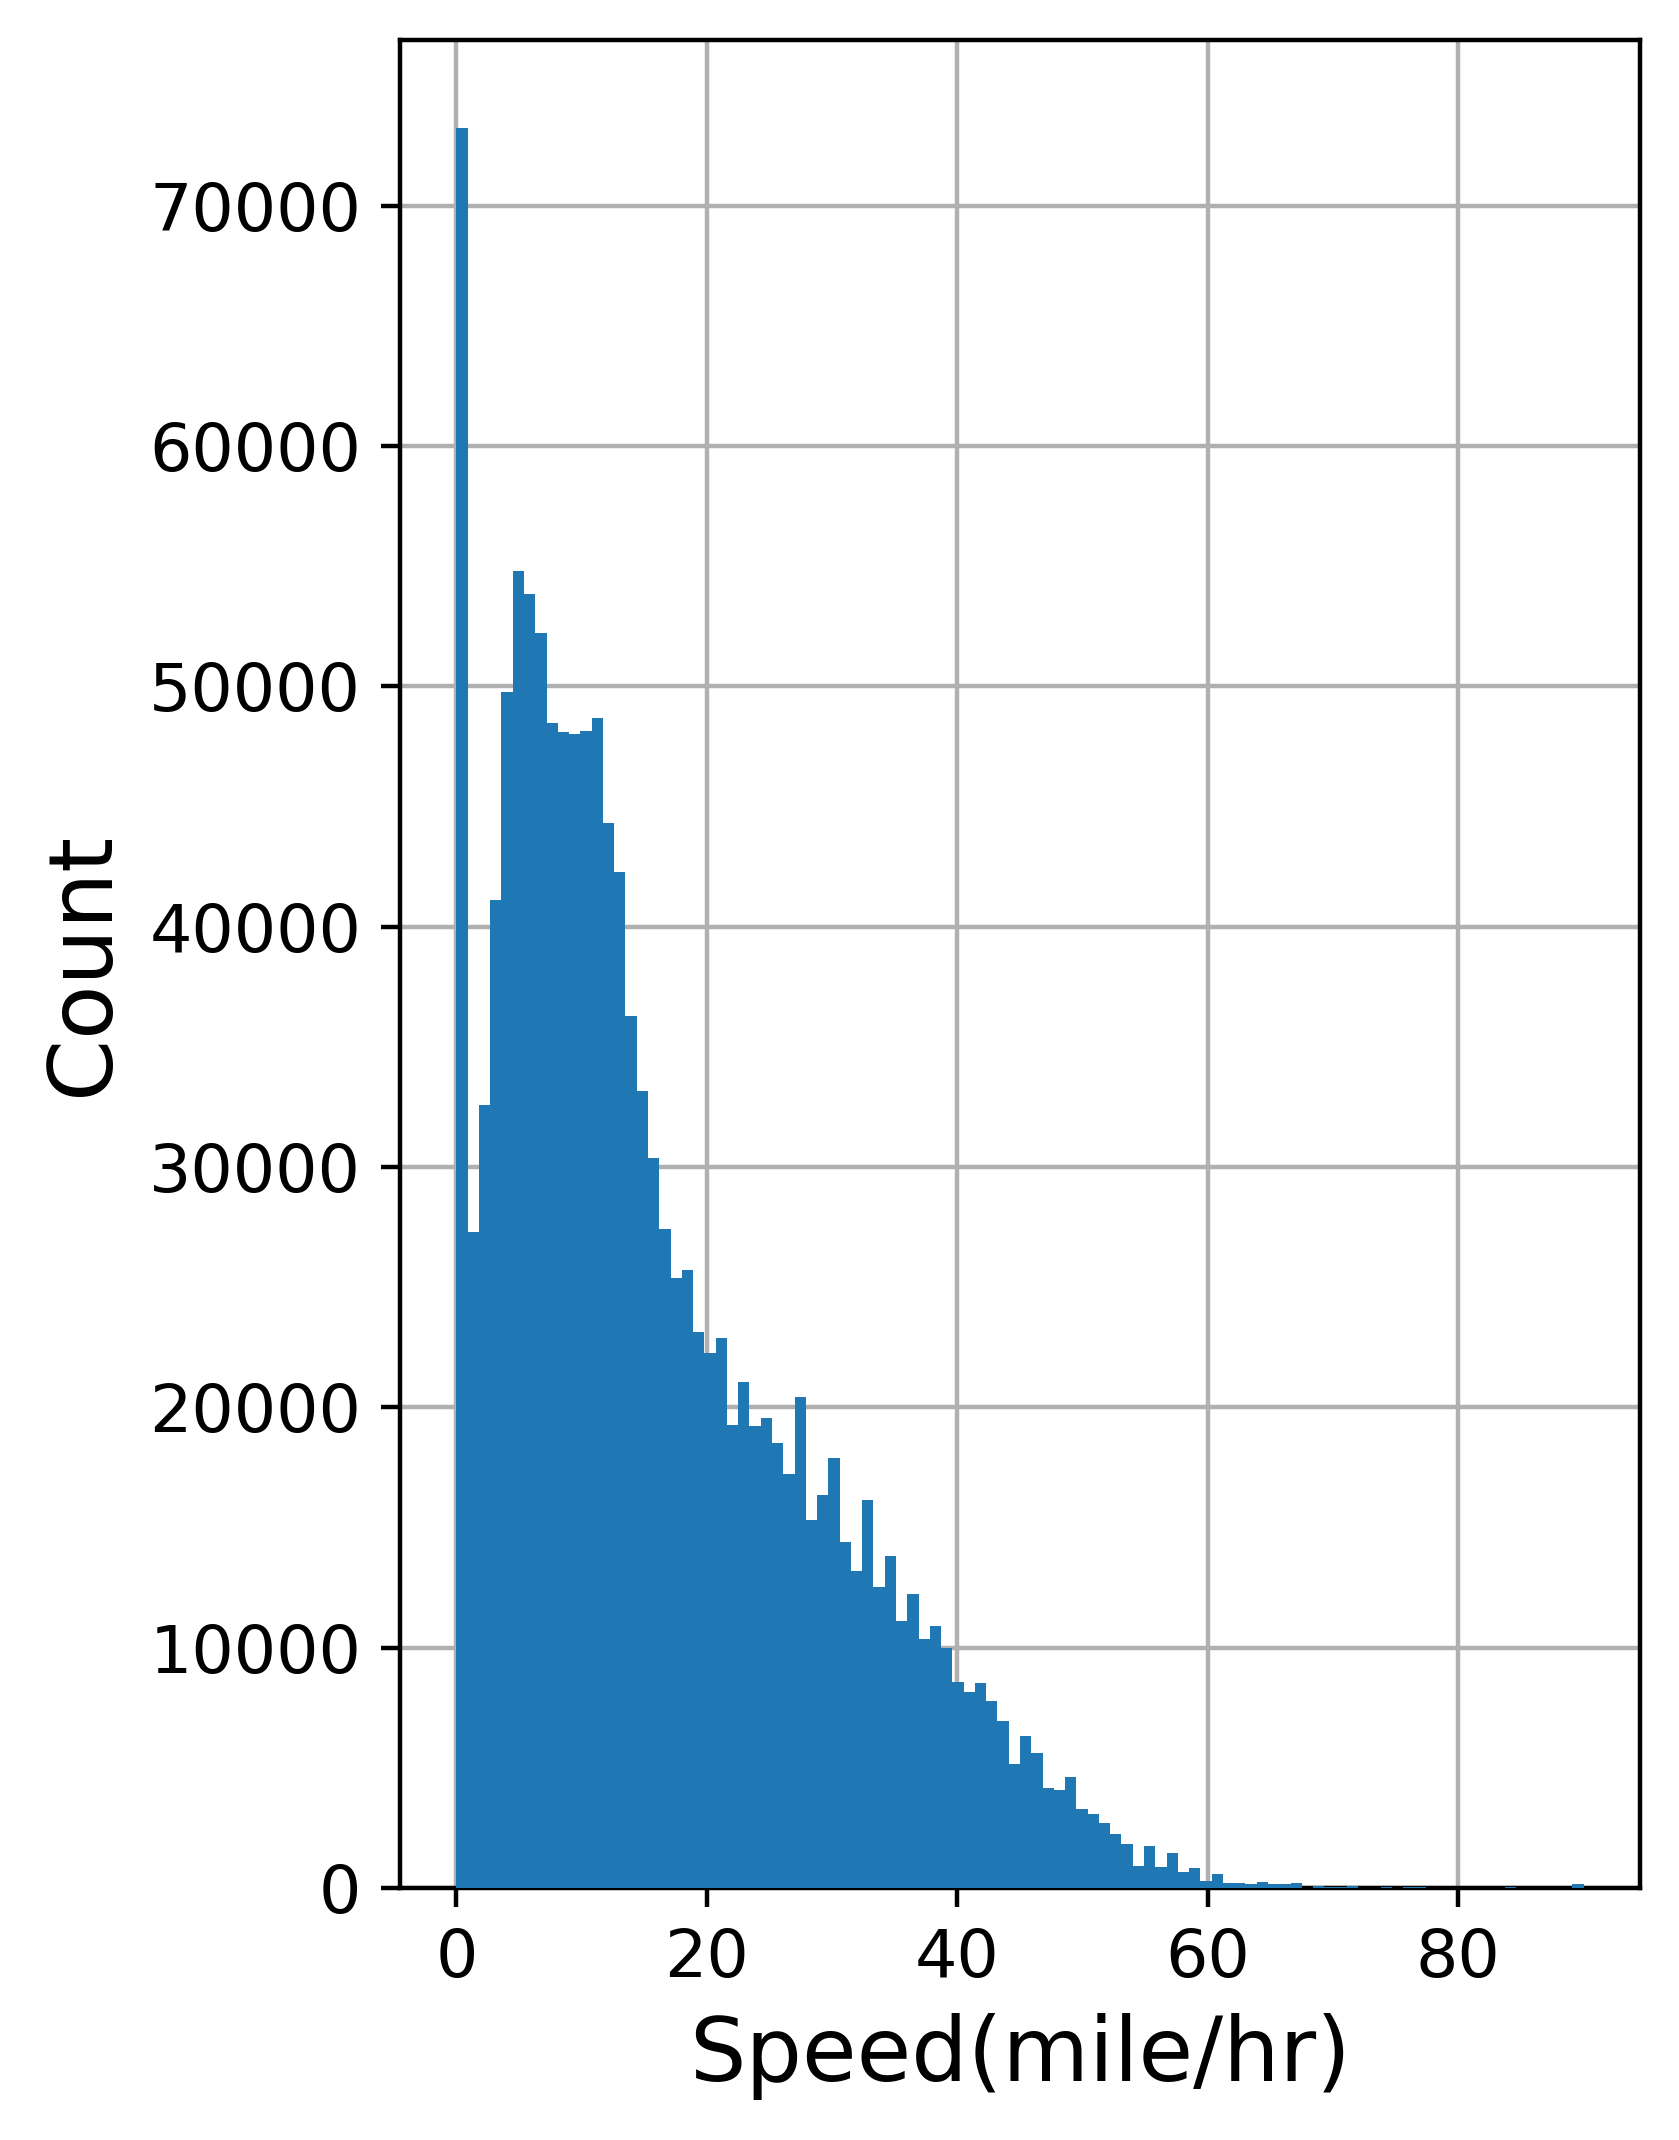

In [308]:
figure(figsize=(4 , 6), dpi=400)
ax=df_copy['speed'].hist(bins=100, zorder=3)
ax.set_xlabel('Speed(mile/hr)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-speed.png', dpi=400, bbox_inches='tight')

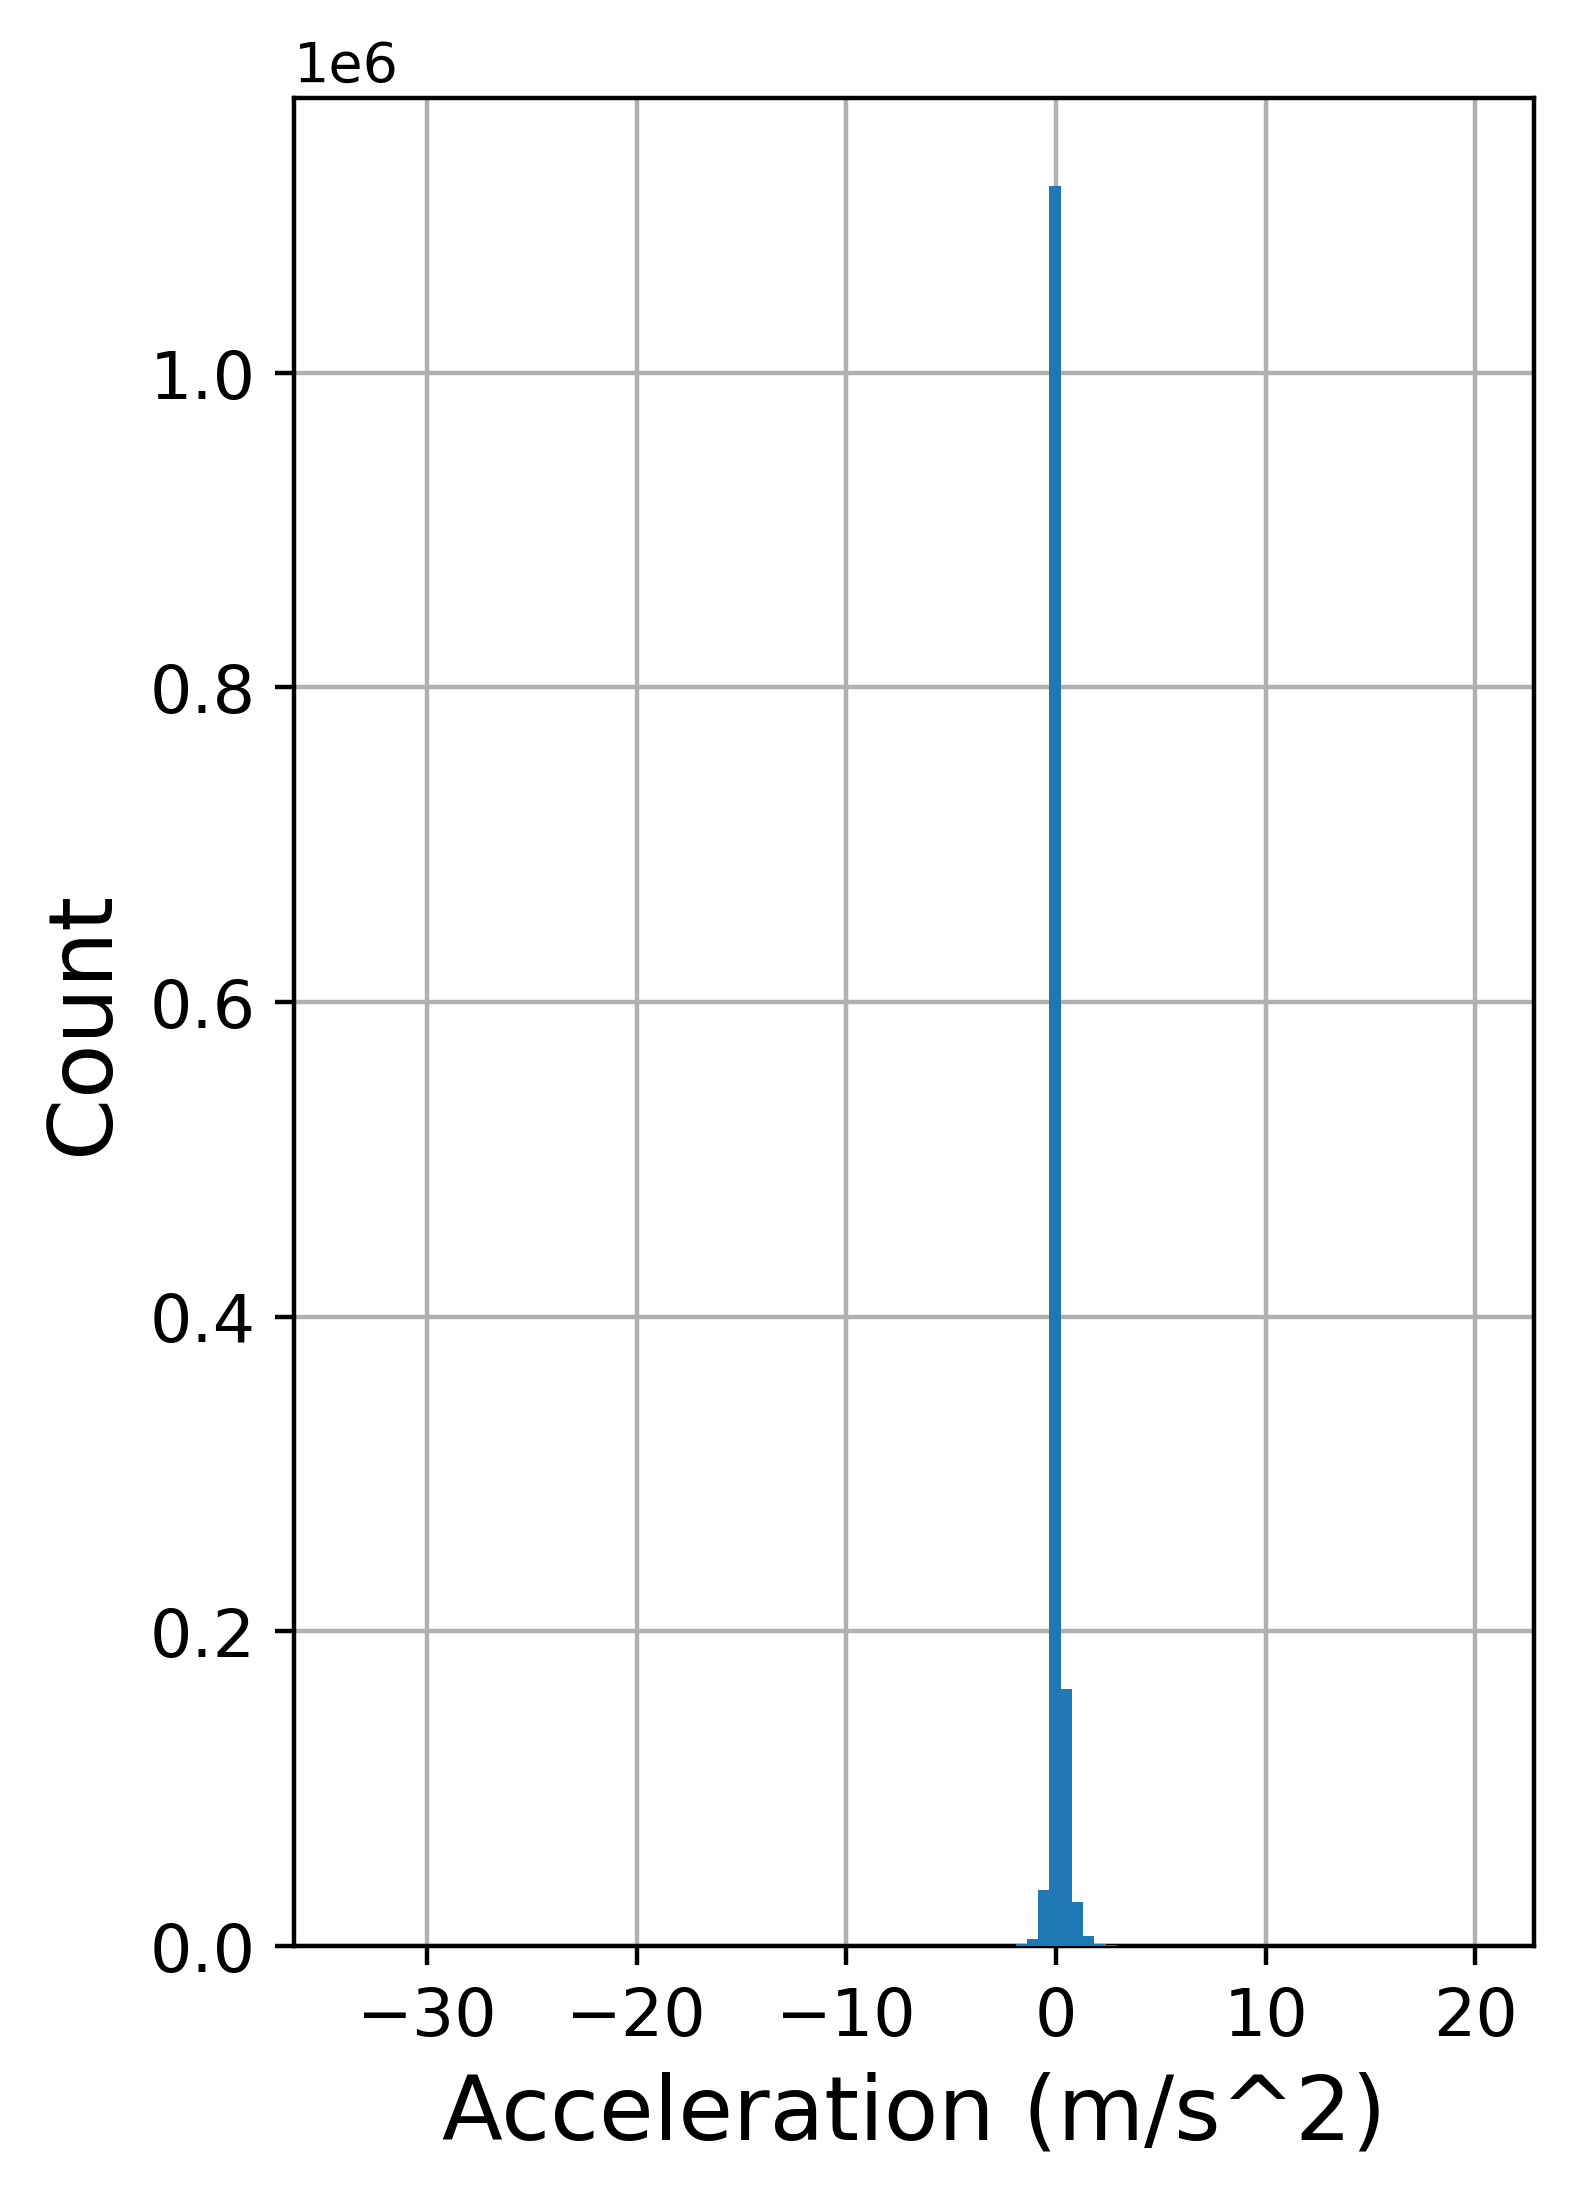

In [311]:
figure(figsize=(4, 6), dpi=400)
ax=df_copy['acc'].hist(bins=100, zorder=3)
ax.set_xlabel('Acceleration (m/s^2)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-acceleration.png', dpi=400, bbox_inches='tight')

In [146]:
df[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][df['speed']>90]

Empty DataFrame
Columns: [ServiceDateTime, Date, Vehicle, dist, speed, acc]
Index: []

In [148]:
ind_list = [13248, 13249,14215,14216,35589,35590,190041,190042,217628,217629,263794,263795,264966,264967,306983,306984,388110,388111,392564,392565,395360,395361,395477,395478,640284,640285,640286,749057,749058,822527,822528]
df[['ServiceDateTime','Date','Vehicle','dist','speed','acc']].iloc[ind_list]

ServiceDateTime        Date  Vehicle      dist      speed  \
13248  2022-04-12 15:00:03  2022-04-12     1412  0.295316  16.355946   
13249  2022-04-12 15:00:05  2022-04-12     1412  0.075489  90.000000   
14215  2022-04-28 14:58:30  2022-04-28     1413  0.295316  14.973753   
14216  2022-04-28 14:58:32  2022-04-28     1413  0.075489  90.000000   
35589  2022-04-12 14:53:01  2022-04-12     1552  0.139418   3.323864   
35590  2022-04-12 14:53:05  2022-04-12     1552  0.101070  90.000000   
190041 2022-04-14 14:55:33  2022-04-14     1652  0.295316  17.147363   
190042 2022-04-14 14:55:35  2022-04-14     1652  0.075489  90.000000   
217628 2022-04-26 14:54:07  2022-04-26     1654  0.139418   7.273964   
217629 2022-04-26 14:54:11  2022-04-26     1654  0.101070  90.000000   
263794 2022-04-20 21:53:05  2022-04-20     1661  0.245652  31.583791   
263795 2022-04-20 21:53:11  2022-04-20     1661  0.153646  90.000000   
264966 2022-04-24 18:52:59  2022-04-24     1661  0.087278  13.091727   
264967 2022-04-24 18:53:03  2022-04-24     1661  0.116503  90.000000   
306983 2022-04-13 14:55:02  2022-04-13     1672  0.295316  24.162193   
306984 2022-04-13 14:55:04  2022-04-13     1672  0.075489  90.000000   
388110 2022-04-09 12:19:16  2022-04-09     1721  0.320166  12.261660   
388111 2022-04-09 12:19:17  2022-04-09     1721  0.231097  90.000000   
392564 2022-04-19 06:48:12  2022-04-19     1721  0.995131  19.469947   
392565 2022-04-19 06:48:21  2022-04-19     1721  0.241291  90.000000   
395360 2022-04-25 14:13:10  2022-04-25     1721  0.157750   6.925624   
395361 2022-04-25 14:13:13  2022-04-25     1721  0.344522  90.000000   
395477 2022-04-25 17:14:01  2022-04-25     1721  0.157750   6.527599   
395478 2022-04-25 17:14:04  2022-04-25     1721  0.344522  90.000000   
640284 2022-04-26 12:15:22  2022-04-26     1819  0.882533   3.114824   
640285 2022-04-26 12:15:24  2022-04-26     1819  0.723648  90.000000   
640286 2022-04-26 12:15:38  2022-04-26     1819  0.864142  90.000000   
749057 2022-04-08 14:57:57  2022-04-08     1836  0.295316  13.289206   
749058 2022-04-08 14:57:58  2022-04-08     1836  0.075489  90.000000   
822527 2022-04-24 16:30:00  2022-04-24     1844  0.190881  62.470054   
822528 2022-04-24 16:30:06  2022-04-24     1844  0.158634  90.000000   

              acc  
13248   -0.113278  
13249   16.460919  
14215   -0.146856  
14216   16.769867  
35589   -0.046233  
35590    9.686925  
190041  -0.152501  
190042  16.284021  
217628  -0.047266  
217629   9.245462  
263794  -0.092396  
263795   4.352397  
264966   0.115178  
264967   8.595269  
306983   0.185626  
306984  14.716067  
388110  -0.006208  
388111  34.752148  
392564   0.047304  
392565   3.503306  
395360   0.002977  
395361  12.379190  
395477   0.022910  
395478  12.438501  
640284  -0.001455  
640285  19.420575  
640286   0.000000  
749057  -0.109175  
749058  34.292793  
822527   0.588192  
822528   2.051165

In [122]:
len(df[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][df['acc']>6])

192

In [118]:
len(df[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][df['acc']<-6])

43

In [92]:
#df.set_index(['time', 'Vehicle'])['dist'].unstack()

In [136]:
#fig, ax = plt.subplots(figsize=(25,25))

#for key, grp in df.groupby(['Vehicle']):
#    ax = grp.plot(ax=ax, kind='scatter', x='ServiceDateTime', y='dist', label=key)

#plt.legend(loc='best')
#plt.show()

In [137]:
#df_new=df.set_index('Date')
#df_new.groupby([''])['Date'].plot(legend=True)

In [138]:
#vehicles=df['Vehicles'].unique

In [139]:
#len(vehicles)

In [140]:
#fig, ax = plt.subplots(figsize=(25,25))

#for key, grp in df.groupby(['Vehicle']):
#    ax = grp.plot(ax=ax, kind='scatter', x='ServiceDateTime', y='dist', label=key)

#plt.legend(loc='best')
#plt.show()

In [86]:
#df=df.set_index('ServiceDateTime')

In [95]:
#df=df.reset_index()

In [191]:
#df.pivot(index='ServiceDateTime', columns='Vehicle', values='dist').plot()

In [123]:
df.columns

Index(['ServiceDateTime', 'Unnamed: 0', 'DateKey', 'CalendarDate', 'Year',
       'Month', 'OpKey', 'Operator', 'RtKey', 'RtKey2', 'Route', 'RouteName',
       'TripKey', 'Trip', 'StopKey', 'Stop', 'StopName', 'Lat', 'Lon',
       'Vehicle', 'VehicleType', 'SeatedCap', 'TotalCap', 'Boards', 'Alights',
       'Onboard', 'Bike', 'Wheelchair', 'Weekday', 'Hour', 'Minute', 'Second',
       'Date', 'Daytype', 'time', 'time_delta', 'time_delta_in_seconds',
       'dist', 'speed', 'acc'],
      dtype='object')

In [124]:
len(df['Route'].unique())

49

In [125]:
len(df['Operator'].unique())

3

In [126]:
df['Route'].unique()

array(['R44', '(X) 39E', 'B43', '9999', '(X) P11', 'X92', '(X) 821',
       '(X) 804', '(X) 892', '(X) 823', '(X) 801', '(X) 820', 'G5',
       '(X) 802', 'X90', 'B4', 'R14', 'R10', 'G1', 'R29', 'B17', 'G3',
       '(X) 805', '(X) 824', '921', '(X) 803', 'G73', 'P20', 'P21', 'B6',
       'B7', 'G2', 'B12', '(X) 806', '(X) B9', 'B23', 'R24', '31', '30',
       '(X) 38', '33', '46', '45', '35', '(X) 34', 'R41', 'R42', 'B48',
       '(X) 943'], dtype=object)

In [127]:
trajectories = pd.read_csv(r'../../results/computed-trajectories2.csv', delimiter=',', skiprows=0, low_memory=False)

In [128]:
trajectories.columns

Index(['Unnamed: 0.1', 'ServiceDateTime', 'Unnamed: 0', 'DateKey',
       'CalendarDate', 'Year', 'Month', 'OpKey', 'Operator', 'RtKey', 'RtKey2',
       'Route', 'RouteName', 'TripKey', 'Trip', 'StopKey', 'Stop', 'StopName',
       'Lat', 'Lon', 'Vehicle', 'VehicleType', 'SeatedCap', 'TotalCap',
       'Boards', 'Alights', 'Onboard', 'Bike', 'Wheelchair', 'Weekday', 'Hour',
       'Minute', 'Second', 'Date', 'Daytype', 'time', 'time_delta',
       'time_delta_in_seconds', 'dist', 'speed', 'acc'],
      dtype='object')

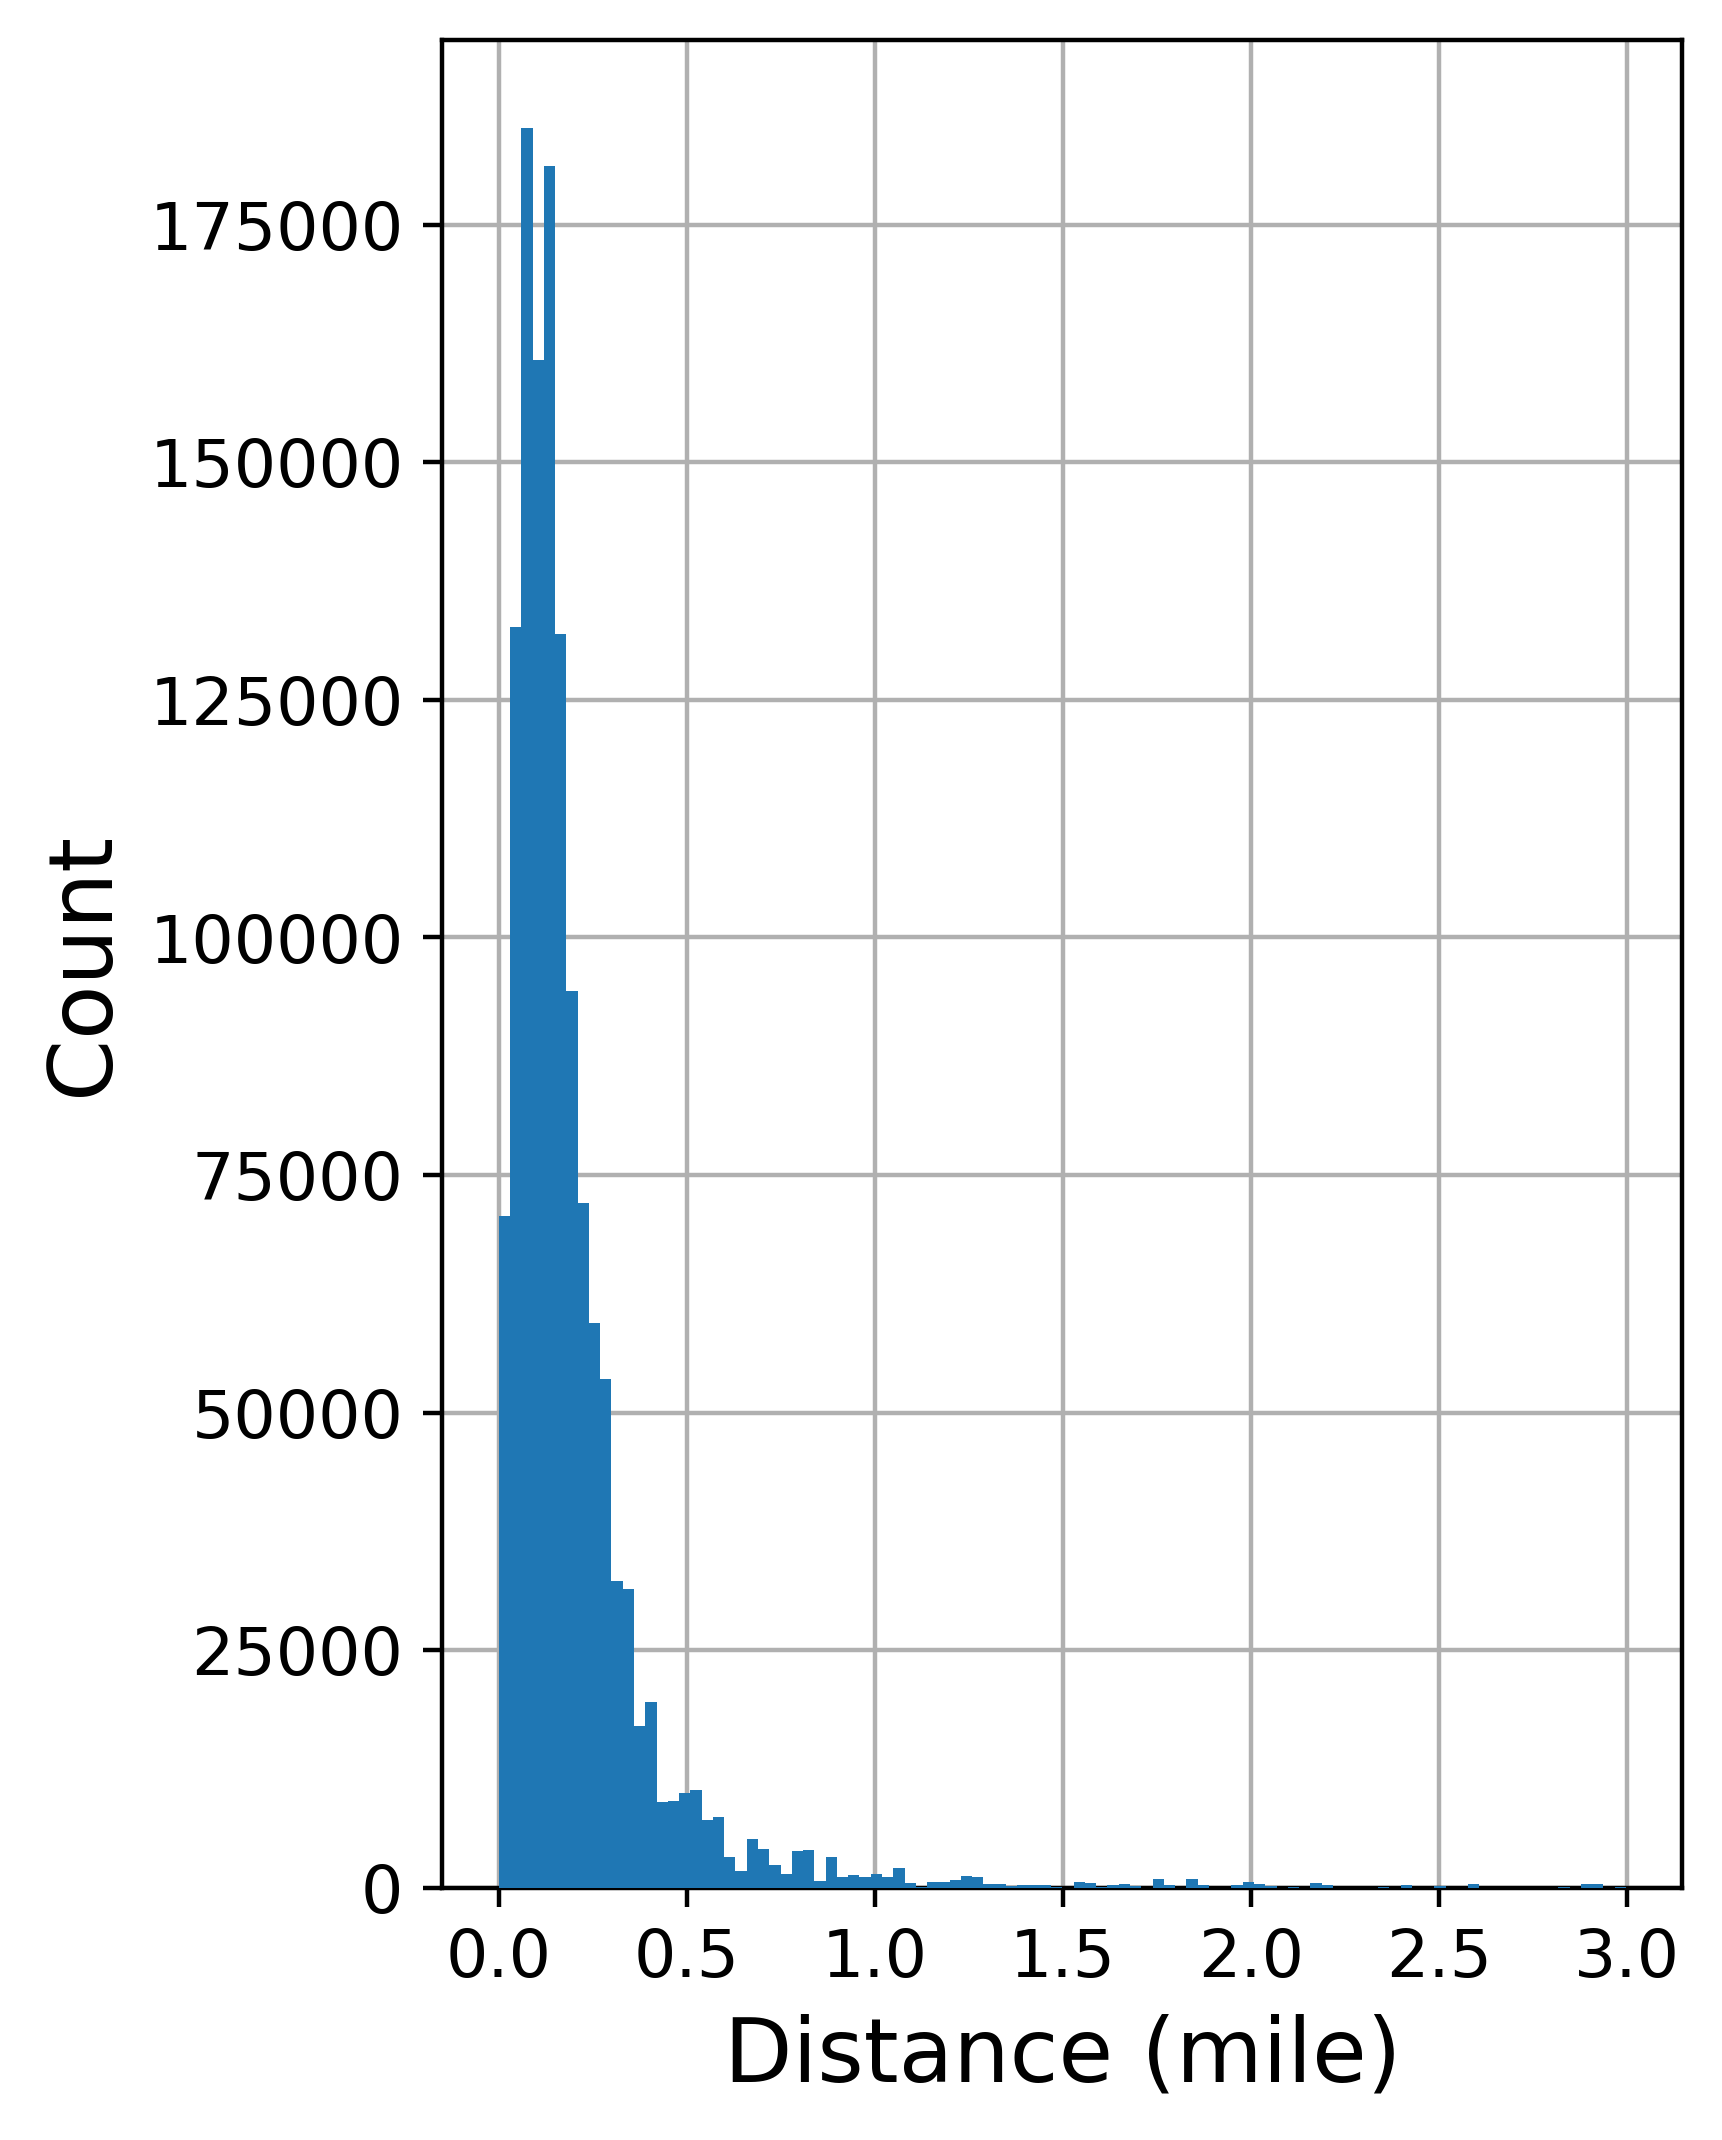

In [9]:
figure(figsize=(4 , 6), dpi=400)
filtered_distances=trajectories[trajectories['dist']<3]
ax=filtered_distances['dist'].hist(bins=100, zorder=3)
ax.set_xlabel('Distance (mile)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-distance.png', dpi=400, bbox_inches='tight')

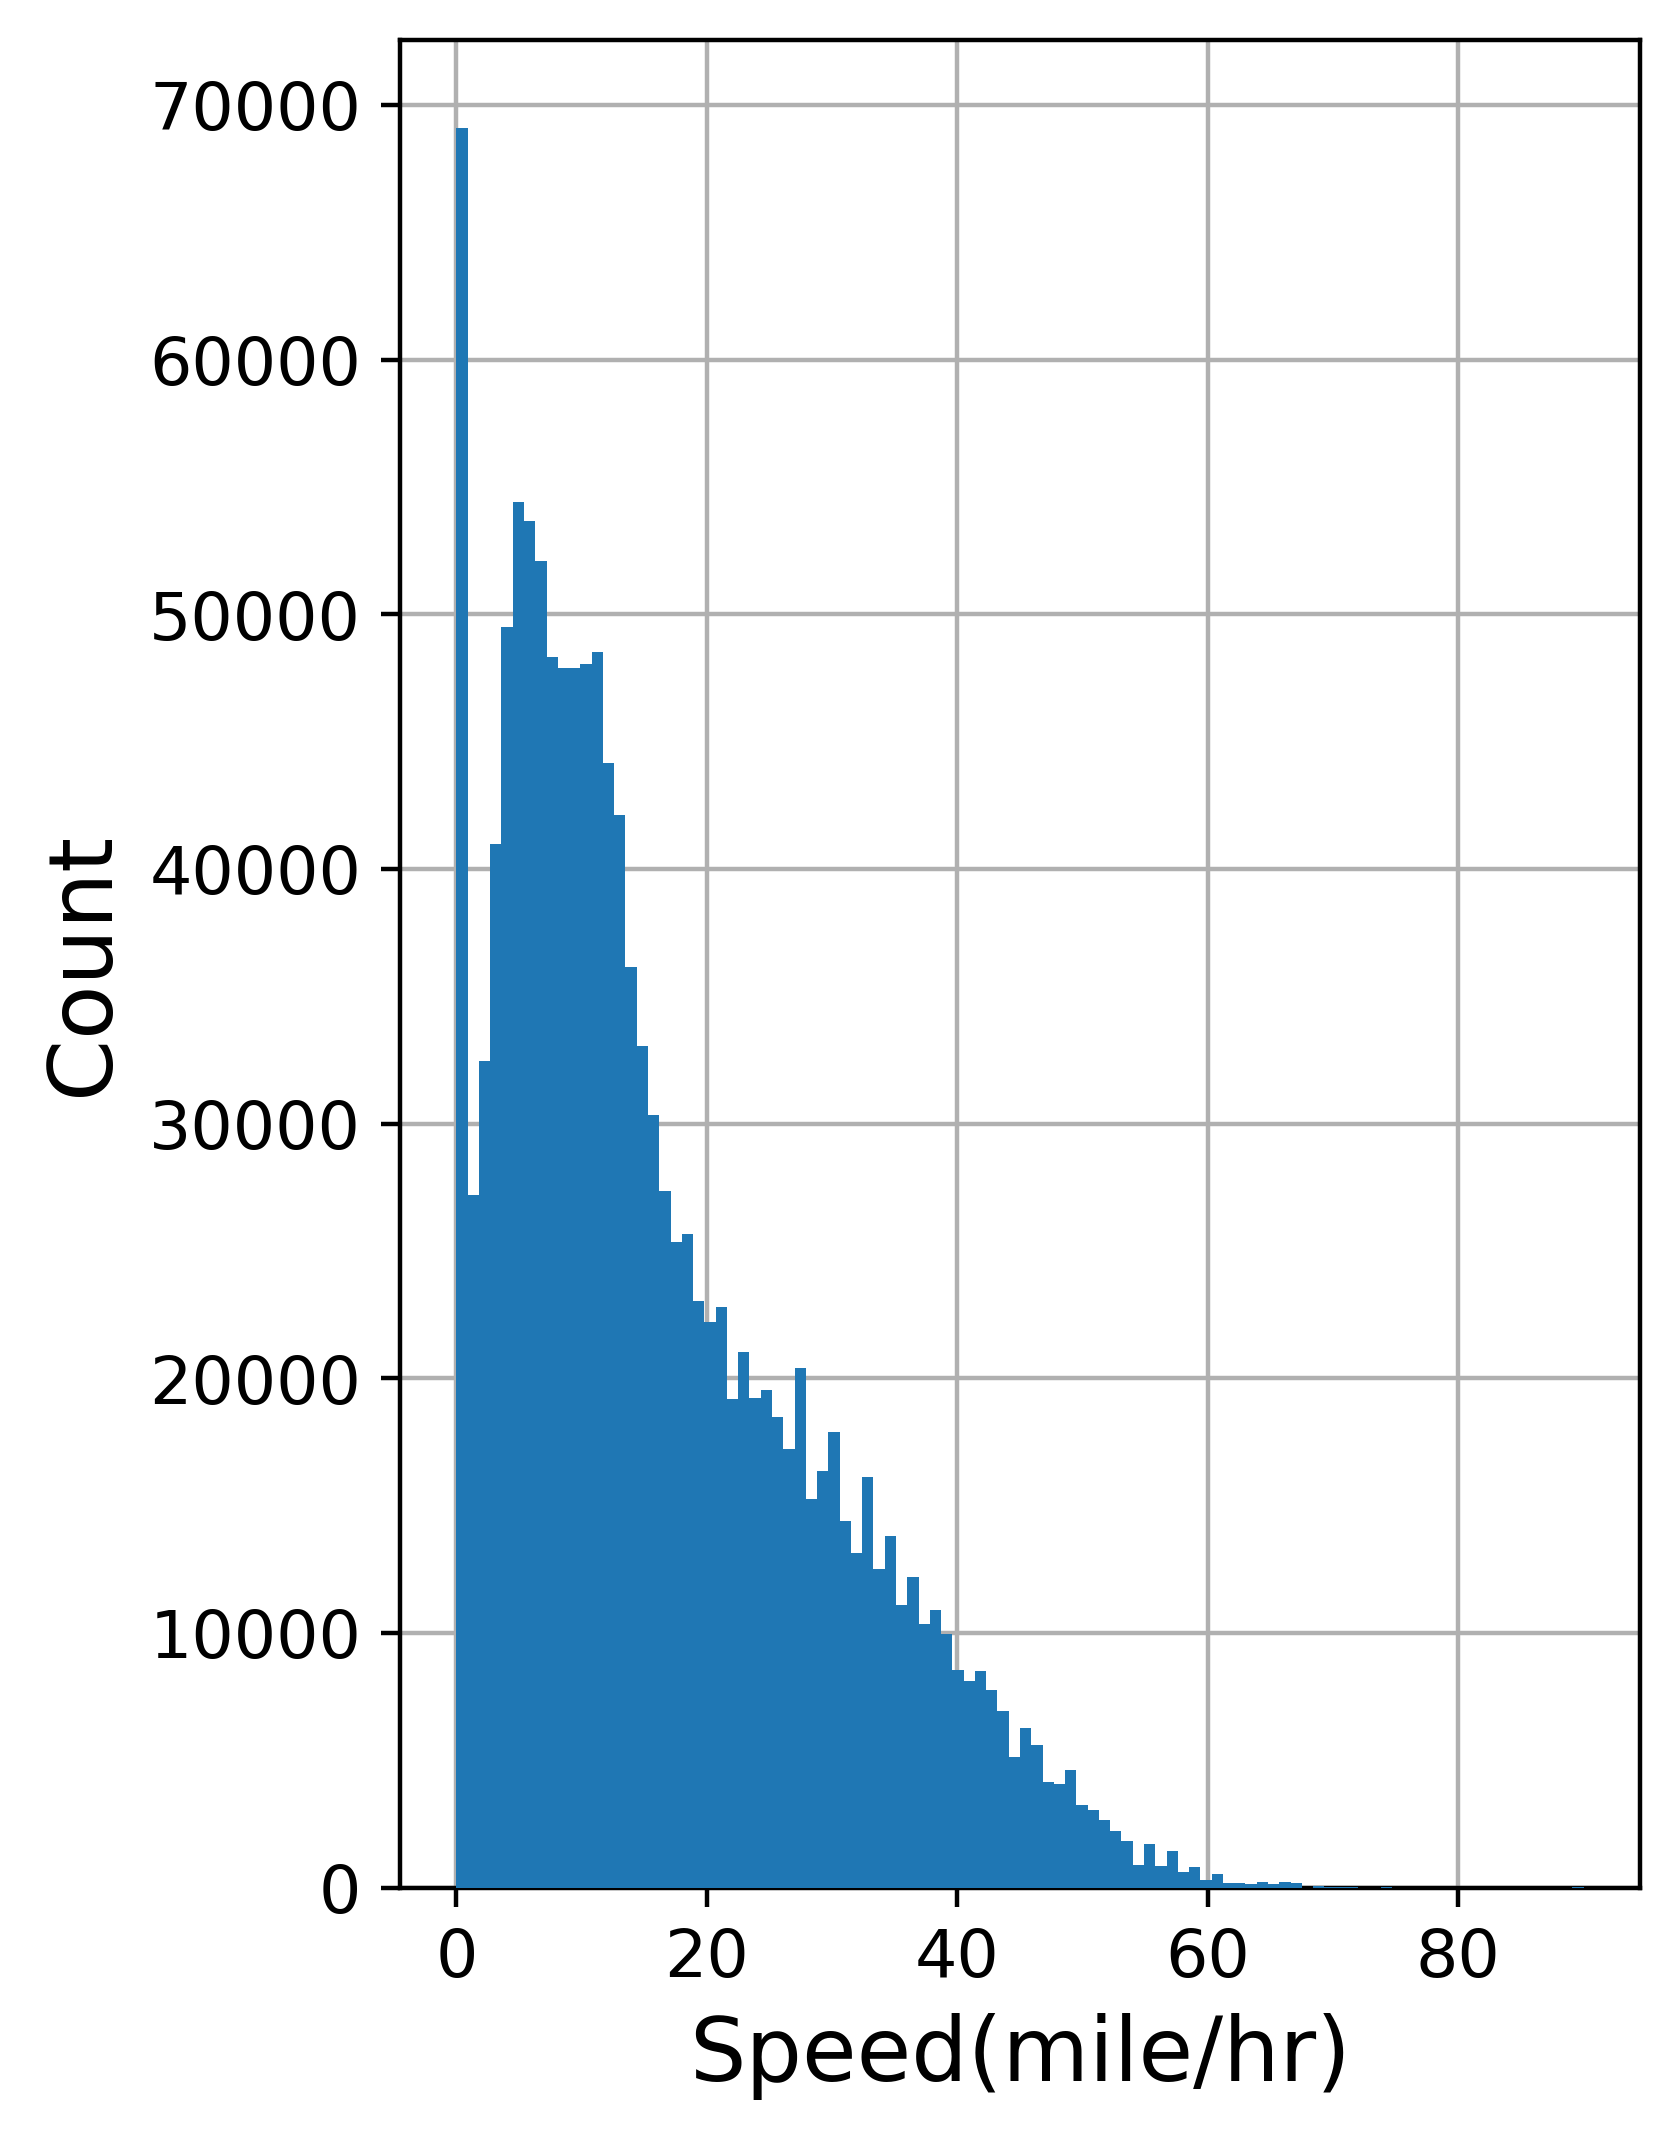

In [10]:
figure(figsize=(4 , 6), dpi=400)
ax=trajectories['speed'].hist(bins=100, zorder=3)
ax.set_xlabel('Speed(mile/hr)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-speed.png', dpi=400, bbox_inches='tight')

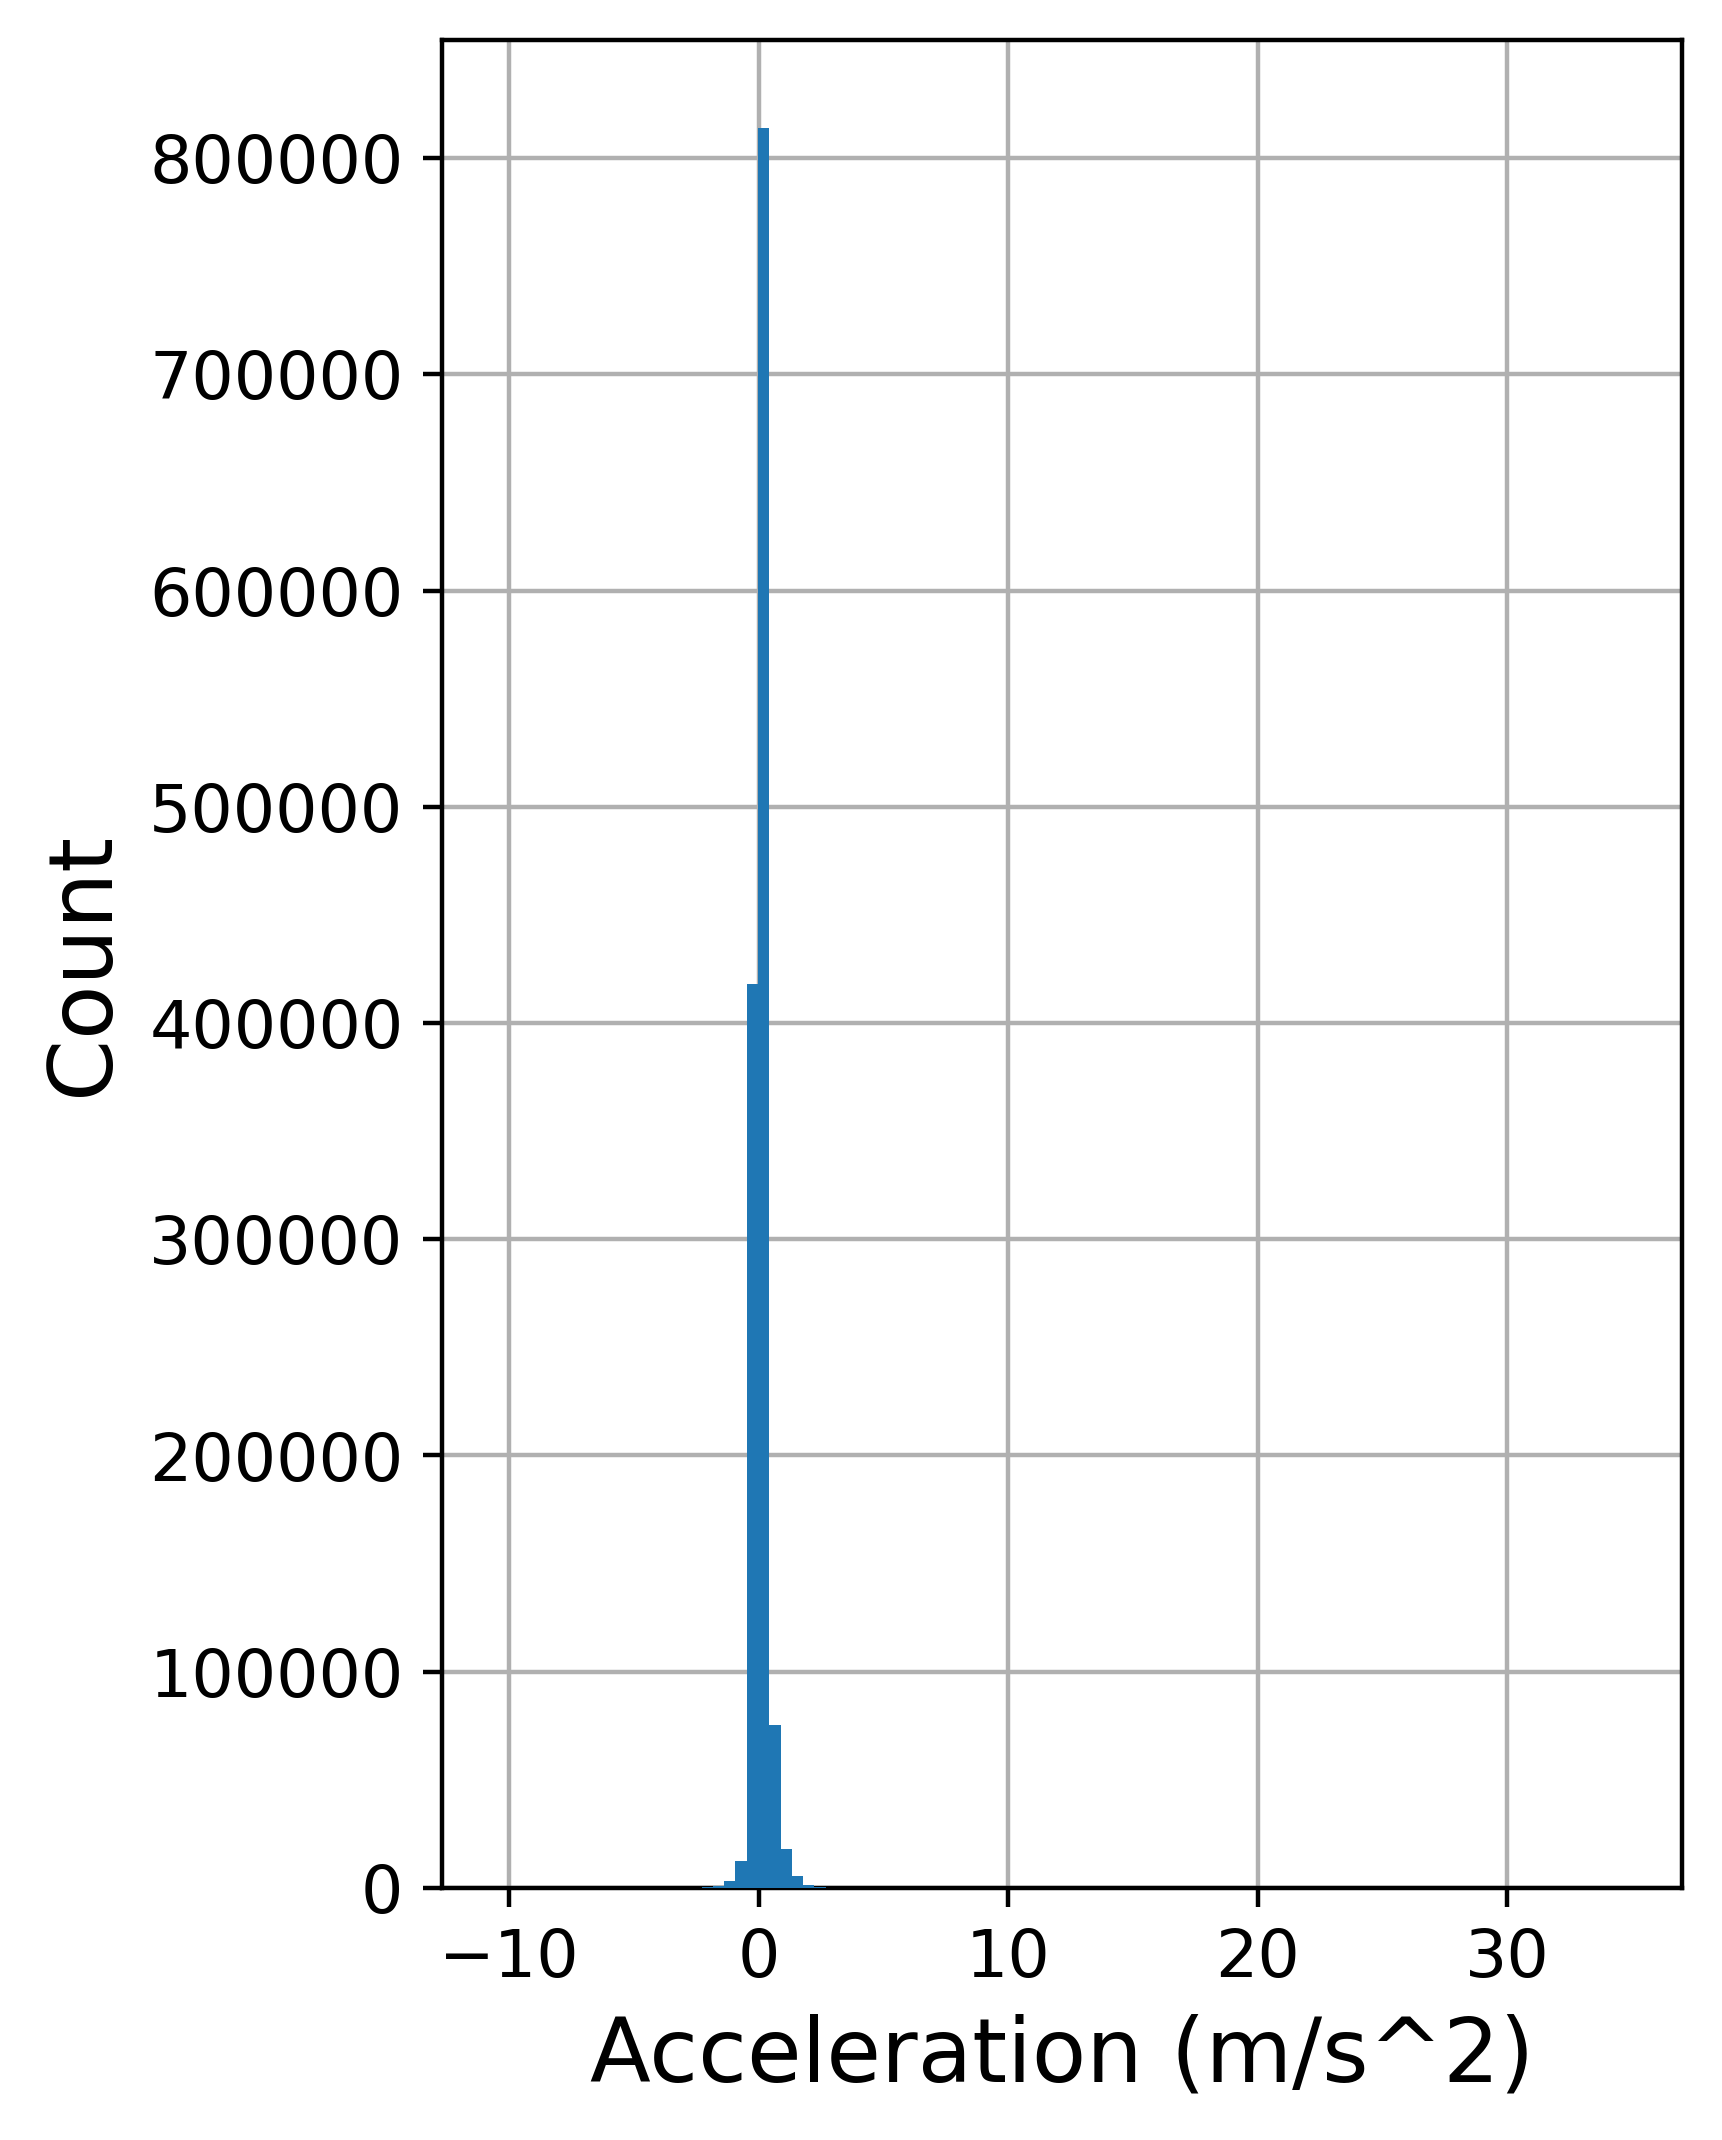

In [11]:
figure(figsize=(4, 6), dpi=400)
ax=trajectories['acc'].hist(bins=100, zorder=3)
ax.set_xlabel('Acceleration (m/s^2)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-acceleration.png', dpi=400, bbox_inches='tight')

In [129]:
len(trajectories['Vehicle'].unique())

178

In [130]:
type(trajectories.loc[100].at["ServiceDateTime"])

str

In [14]:
trajectories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361549 entries, 0 to 1361548
Data columns (total 41 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0.1           1361549 non-null  int64  
 1   ServiceDateTime        1361549 non-null  object 
 2   Unnamed: 0             1361549 non-null  int64  
 3   DateKey                1361549 non-null  int64  
 4   CalendarDate           1361549 non-null  object 
 5   Year                   1361549 non-null  int64  
 6   Month                  1361549 non-null  int64  
 7   OpKey                  1361549 non-null  int64  
 8   Operator               1361549 non-null  object 
 9   RtKey                  1361549 non-null  int64  
 10  RtKey2                 1361549 non-null  int64  
 11  Route                  1361549 non-null  object 
 12  RouteName              1352172 non-null  object 
 13  TripKey                1361549 non-null  int64  
 14  Trip              

In [131]:
trajectories['ServiceDateTime']= pd.to_datetime(trajectories['ServiceDateTime'])

In [132]:
trajectories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361549 entries, 0 to 1361548
Data columns (total 41 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0.1           1361549 non-null  int64         
 1   ServiceDateTime        1361549 non-null  datetime64[ns]
 2   Unnamed: 0             1361549 non-null  int64         
 3   DateKey                1361549 non-null  int64         
 4   CalendarDate           1361549 non-null  object        
 5   Year                   1361549 non-null  int64         
 6   Month                  1361549 non-null  int64         
 7   OpKey                  1361549 non-null  int64         
 8   Operator               1361549 non-null  object        
 9   RtKey                  1361549 non-null  int64         
 10  RtKey2                 1361549 non-null  int64         
 11  Route                  1361549 non-null  object        
 12  RouteName              13521

In [133]:
trajectories = trajectories.set_index("ServiceDateTime")
trajectories

Unnamed: 0.1  Unnamed: 0  DateKey  \
ServiceDateTime                                          
2022-04-04 06:43:24             0      112564     8763   
2022-04-04 06:51:27             1      109326     8763   
2022-04-04 06:51:27             2      112565     8763   
2022-04-04 06:52:52             3      109327     8763   
2022-04-04 06:54:33             4      109328     8763   
...                           ...         ...      ...   
2022-04-30 23:54:20       1361544     1325566     8789   
2022-04-30 23:55:24       1361545     1325567     8789   
2022-04-30 23:56:47       1361546     1325568     8789   
2022-04-30 23:57:32       1361547     1325569     8789   
2022-04-30 23:59:29       1361548     1325570     8789   

                                CalendarDate  Year  Month  OpKey Operator  \
ServiceDateTime                                                             
2022-04-04 06:43:24  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:51:27  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:51:27  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:52:52  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:54:33  2022-04-04 00:00:00.000  2022      4      1    VATCo   
...                                      ...   ...    ...    ...      ...   
2022-04-30 23:54:20  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-30 23:55:24  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-30 23:56:47  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-30 23:57:32  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-30 23:59:29  2022-04-30 00:00:00.000  2022      4      1    VATCo   

                     RtKey  RtKey2  ... Minute Second        Date  Daytype  \
ServiceDateTime                     ...                                      
2022-04-04 06:43:24   3519    1006  ...     43     24  2022-04-04  Weekday   
2022-04-04 06:51:27   3513    3380  ...     51     27  2022-04-04  Weekday   
2022-04-04 06:51:27   3519    1006  ...     51     27  2022-04-04  Weekday   
2022-04-04 06:52:52   3513    3380  ...     52     52  2022-04-04  Weekday   
2022-04-04 06:54:33   3513    3380  ...     54     33  2022-04-04  Weekday   
...                    ...     ...  ...    ...    ...         ...      ...   
2022-04-30 23:54:20   3515    1001  ...     54     20  2022-04-30  Weekend   
2022-04-30 23:55:24   3515    1001  ...     55     24  2022-04-30  Weekend   
2022-04-30 23:56:47   3515    1001  ...     56     47  2022-04-30  Weekend   
2022-04-30 23:57:32   3515    1001  ...     57     32  2022-04-30  Weekend   
2022-04-30 23:59:29   3515    1001  ...     59     29  2022-04-30  Weekend   

                         time           time_delta time_delta_in_seconds  \
ServiceDateTime                                                            
2022-04-04 06:43:24  06:43:24                  NaN                   NaN   
2022-04-04 06:51:27  06:51:27  2022-12-04 00:08:03                 483.0   
2022-04-04 06:51:27  06:51:27  2022-12-04 00:00:00                   0.0   
2022-04-04 06:52:52  06:52:52  2022-12-04 00:01:25                  85.0   
2022-04-04 06:54:33  06:54:33  2022-12-04 00:01:41                 101.0   
...                       ...                  ...                   ...   
2022-04-30 23:54:20  23:54:20  2022-12-04 00:02:20                 140.0   
2022-04-30 23:55:24  23:55:24  2022-12-04 00:01:04                  64.0   
2022-04-30 23:56:47  23:56:47  2022-12-04 00:01:23                  83.0   
2022-04-30 23:57:32  23:57:32  2022-12-04 00:00:45                  45.0   
2022-04-30 23:59:29  23:59:29  2022-12-04 00:01:57                 117.0   

                         dist      speed       acc  
ServiceDateTime                                     
2022-04-04 06:43:24  0.000000   0.000000  0.000000  
2022-04-04 06:51:27  0.627342   0.000000  0.000000  
2022-04-04 06:51:27  0.000000   0.000000  0.0000

In [134]:
trajectories["Date"]

ServiceDateTime
2022-04-04 06:43:24    2022-04-04
2022-04-04 06:51:27    2022-04-04
2022-04-04 06:51:27    2022-04-04
2022-04-04 06:52:52    2022-04-04
2022-04-04 06:54:33    2022-04-04
                          ...    
2022-04-30 23:54:20    2022-04-30
2022-04-30 23:55:24    2022-04-30
2022-04-30 23:56:47    2022-04-30
2022-04-30 23:57:32    2022-04-30
2022-04-30 23:59:29    2022-04-30
Name: Date, Length: 1361549, dtype: object

In [135]:
selected_date=['2022-04-04']
plot_data=trajectories.loc[trajectories.Date.isin(selected_date)]

In [136]:
plot_data

Unnamed: 0.1  Unnamed: 0  DateKey  \
ServiceDateTime                                          
2022-04-04 06:43:24             0      112564     8763   
2022-04-04 06:51:27             1      109326     8763   
2022-04-04 06:51:27             2      112565     8763   
2022-04-04 06:52:52             3      109327     8763   
2022-04-04 06:54:33             4      109328     8763   
...                           ...         ...      ...   
2022-04-04 19:00:30       1348358      111110     8763   
2022-04-04 19:01:28       1348359      111111     8763   
2022-04-04 19:02:59       1348360      111112     8763   
2022-04-04 19:05:54       1348361      109322     8763   
2022-04-04 19:05:54       1348362      111113     8763   

                                CalendarDate  Year  Month  OpKey Operator  \
ServiceDateTime                                                             
2022-04-04 06:43:24  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:51:27  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:51:27  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:52:52  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:54:33  2022-04-04 00:00:00.000  2022      4      1    VATCo   
...                                      ...   ...    ...    ...      ...   
2022-04-04 19:00:30  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 19:01:28  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 19:02:59  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 19:05:54  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 19:05:54  2022-04-04 00:00:00.000  2022      4      1    VATCo   

                     RtKey  RtKey2  ... Minute Second        Date  Daytype  \
ServiceDateTime                     ...                                      
2022-04-04 06:43:24   3519    1006  ...     43     24  2022-04-04  Weekday   
2022-04-04 06:51:27   3513    3380  ...     51     27  2022-04-04  Weekday   
2022-04-04 06:51:27   3519    1006  ...     51     27  2022-04-04  Weekday   
2022-04-04 06:52:52   3513    3380  ...     52     52  2022-04-04  Weekday   
2022-04-04 06:54:33   3513    3380  ...     54     33  2022-04-04  Weekday   
...                    ...     ...  ...    ...    ...         ...      ...   
2022-04-04 19:00:30   3515    1001  ...      0     30  2022-04-04  Weekday   
2022-04-04 19:01:28   3515    1001  ...      1     28  2022-04-04  Weekday   
2022-04-04 19:02:59   3515    1001  ...      2     59  2022-04-04  Weekday   
2022-04-04 19:05:54   3410    1007  ...      5     54  2022-04-04  Weekday   
2022-04-04 19:05:54   3515    1001  ...      5     54  2022-04-04  Weekday   

                         time           time_delta time_delta_in_seconds  \
ServiceDateTime                                                            
2022-04-04 06:43:24  06:43:24                  NaN                   NaN   
2022-04-04 06:51:27  06:51:27  2022-12-04 00:08:03                 483.0   
2022-04-04 06:51:27  06:51:27  2022-12-04 00:00:00                   0.0   
2022-04-04 06:52:52  06:52:52  2022-12-04 00:01:25                  85.0   
2022-04-04 06:54:33  06:54:33  2022-12-04 00:01:41                 101.0   
...                       ...                  ...                   ...   
2022-04-04 19:00:30  19:00:30  2022-12-04 00:02:14                 134.0   
2022-04-04 19:01:28  19:01:28  2022-12-04 00:00:58                  58.0   
2022-04-04 19:02:59  19:02:59  2022-12-04 00:01:31                  91.0   
2022-04-04 19:05:54  19:05:54  2022-12-04 00:02:55                 175.0   
2022-04-04 19:05:54  19:05:54  2022-12-04 00:00:00                   0.0   

                         dist      speed       acc  
ServiceDateTime                                     
2022-04-04 06:43:24  0.000000   0.000000  0.000000  
2022-04-04 06:51:27  0.627342   0.000000  0.000000  
2022-04-04 06:51:27  0.000000   0.000000  0.0000

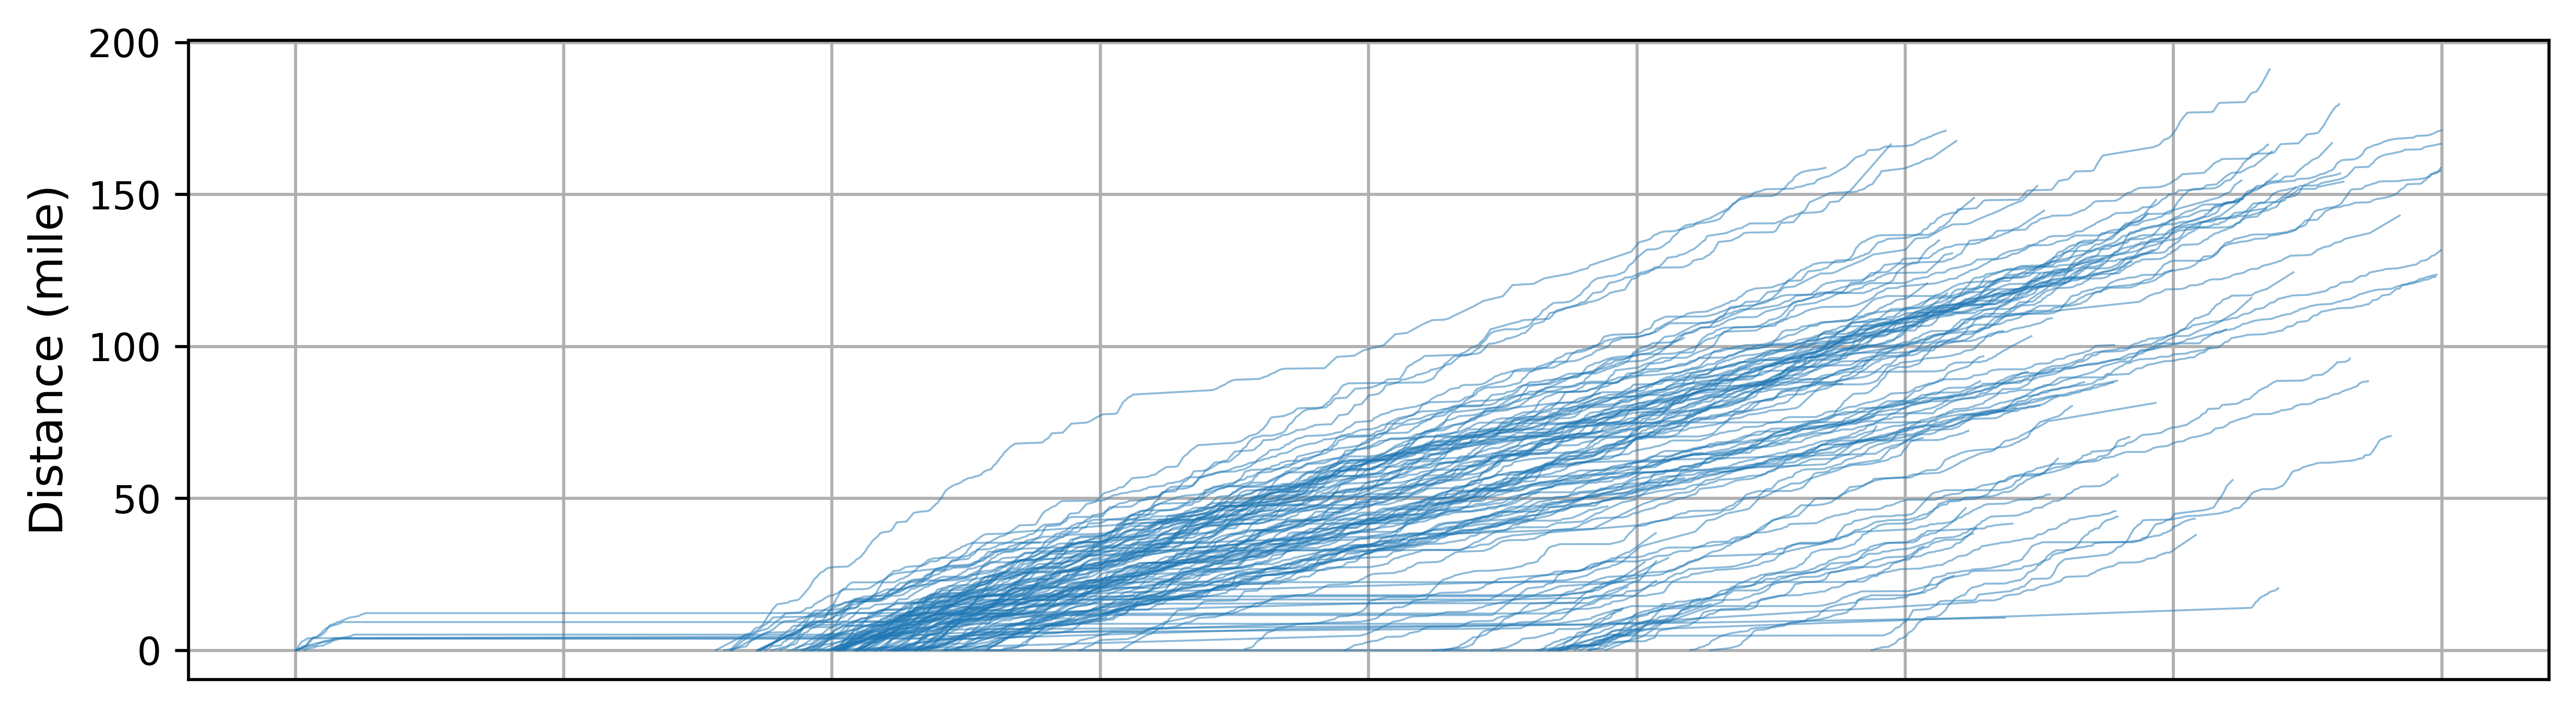

In [137]:
# set size

figure(figsize=(11, 3), dpi=600)

# Plot
vehicle=plot_data['Vehicle'].unique()
for v in vehicle:
    plot_df=plot_data[plot_data['Vehicle']==v]
    plt.plot(plot_df["dist"].cumsum(), marker='', color='#1f77b4', linewidth=0.5, alpha=0.5)

# Remove x-ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Labelling 

#plt.xlabel("time")
plt.ylabel("Distance (mile)", fontsize=12)
#plt.title("Pandas Time Series Plot")
plt.yticks(fontsize=10)
plt.grid()


# Saving
plt.savefig(r'../../figures/trajectories-distance.png', dpi=600, bbox_inches='tight')


# Display

plt.show()

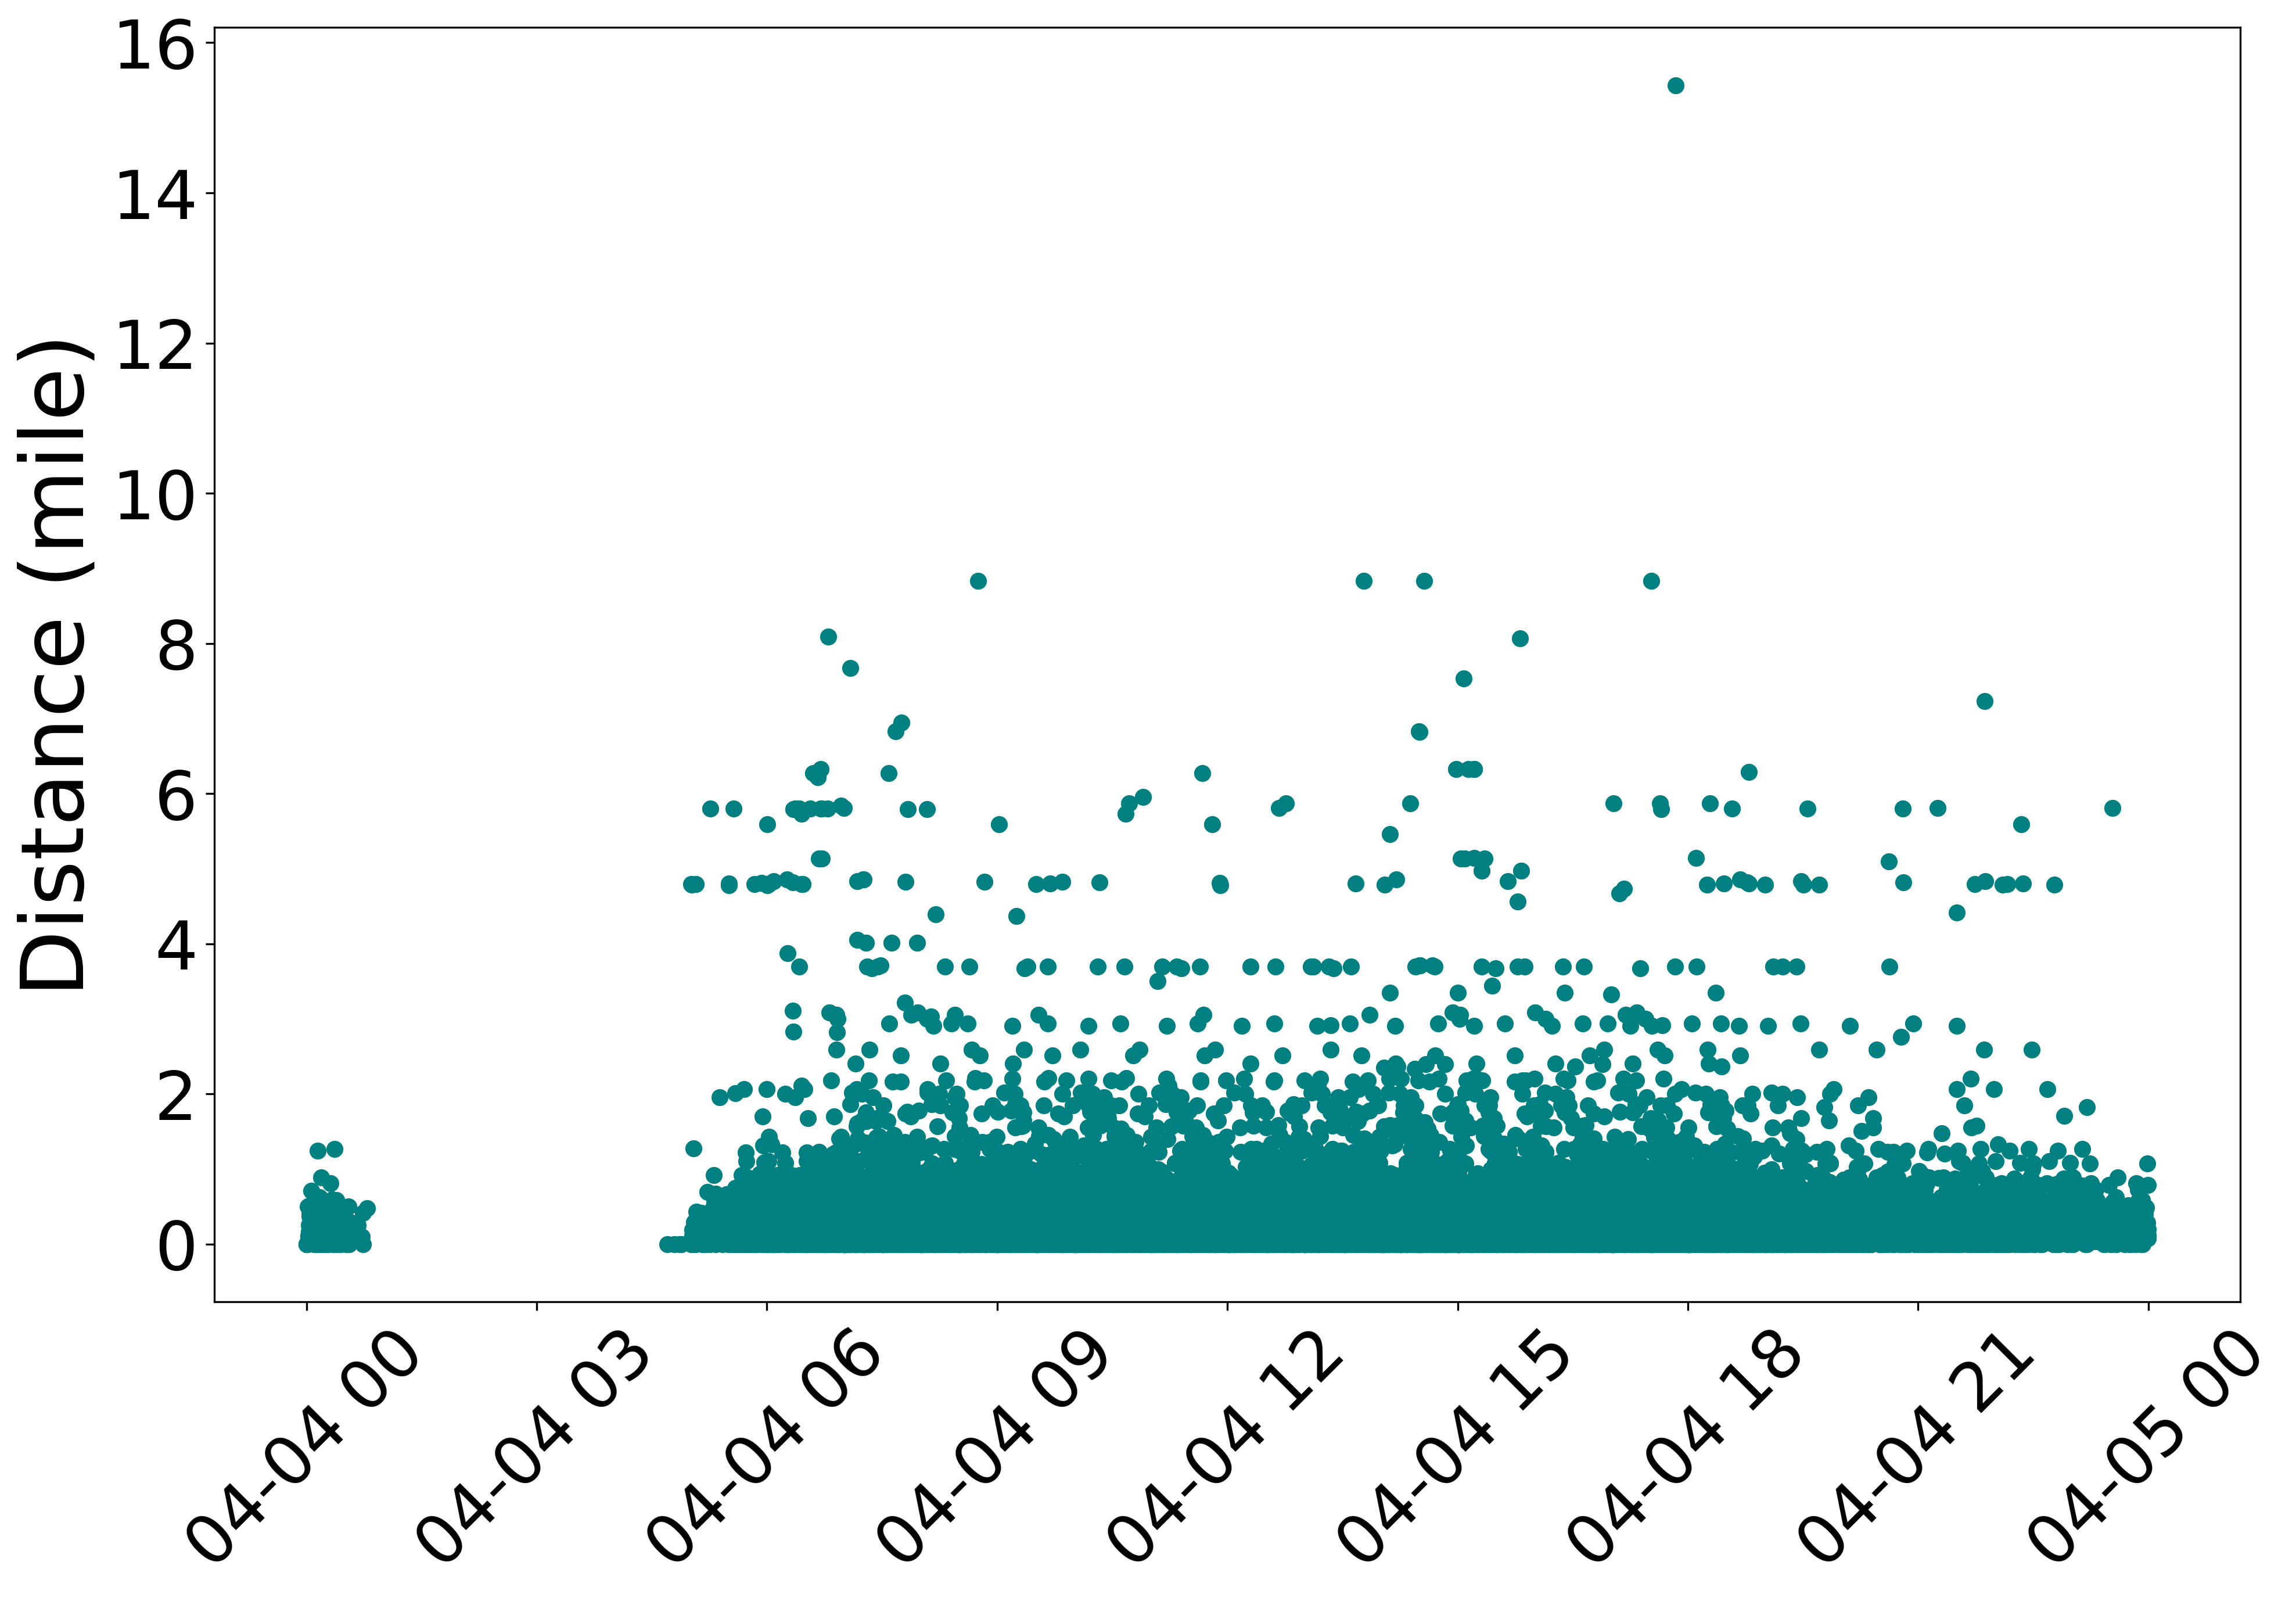

In [175]:
figure(figsize=(15, 9.5), dpi=300)
plt.plot_date(x=plot_data.index , y=plot_data["dist"], fmt='o', tz=None, xdate=True, ydate=False, color='teal')
plt.ylabel("Distance (mile)", fontsize=36)
plt.xticks(fontsize=28, rotation = 45)
plt.yticks(fontsize=28)
# plt.savefig(r'../../figures/trajectories-distance.png', dpi=400, bbox_inches='tight')
plt.show()

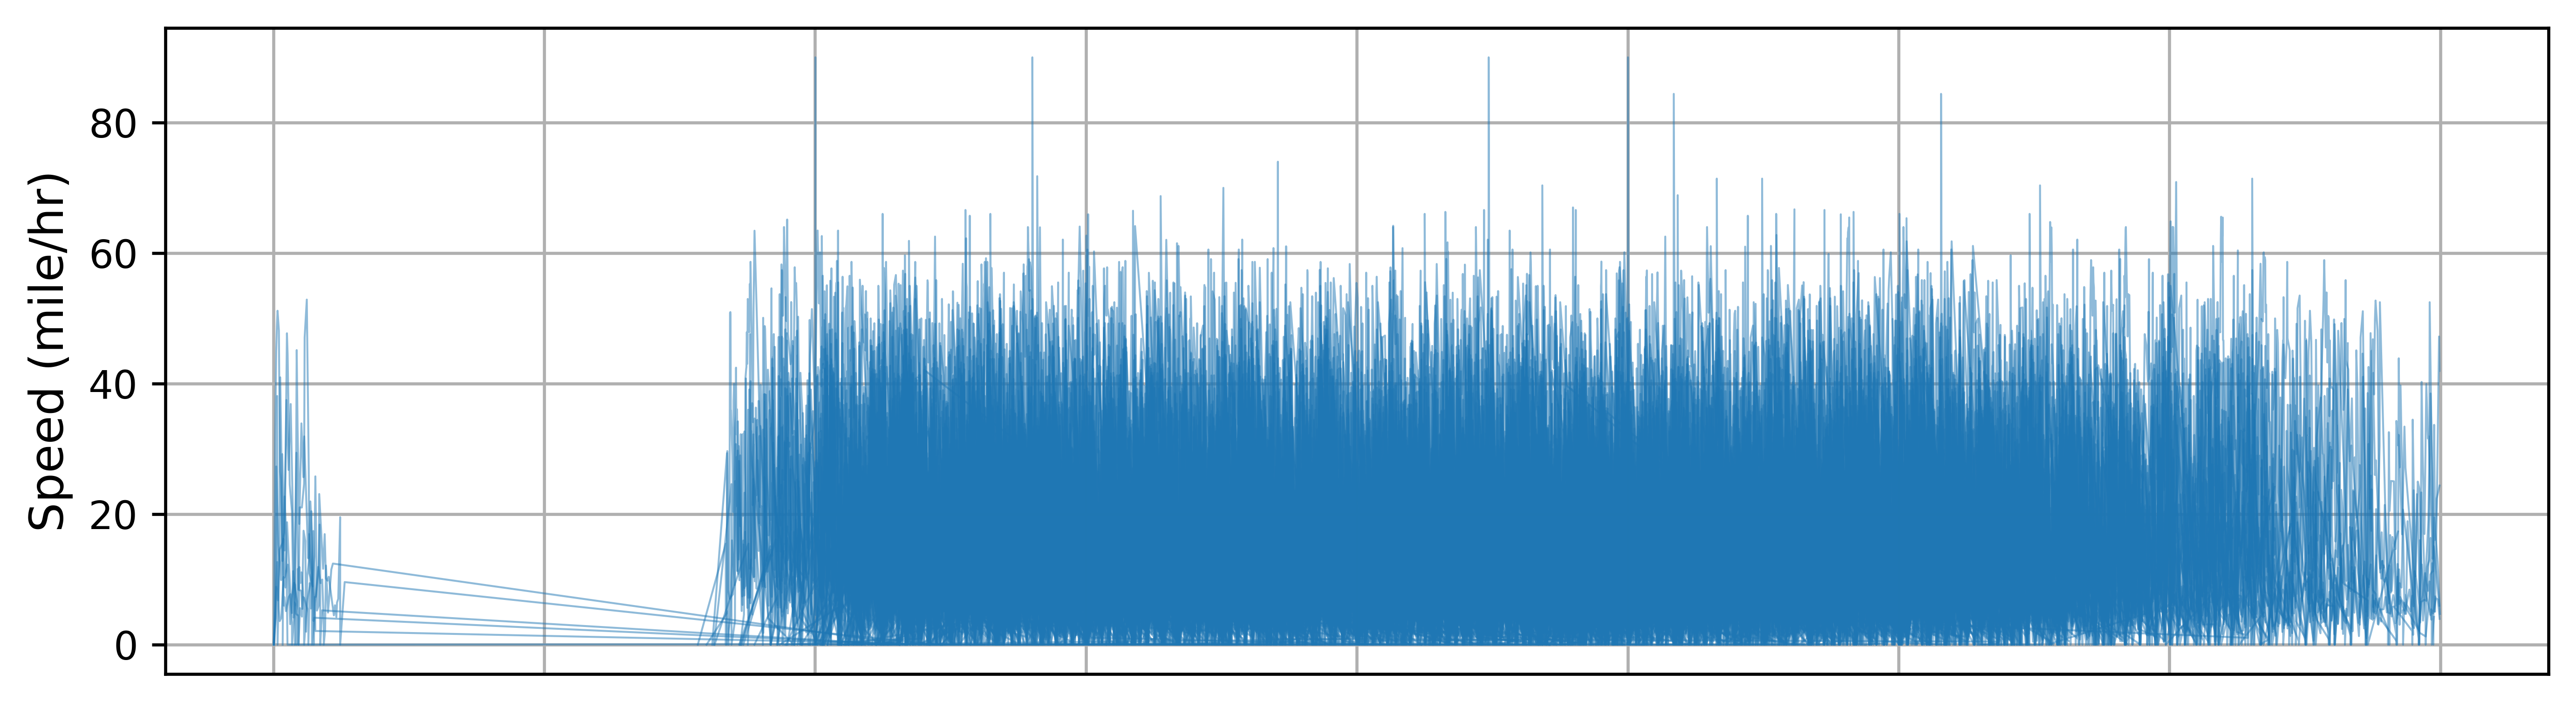

In [138]:
# set size

figure(figsize=(11, 3), dpi=600)

# Plot
vehicle=plot_data['Vehicle'].unique()
for v in vehicle:
    plot_df=plot_data[plot_data['Vehicle']==v]
    plt.plot(plot_df["speed"], marker='',color='#1f77b4', linewidth=0.5, alpha=0.5)



# Remove x-ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Labelling 

#plt.xlabel("time")
plt.ylabel("Speed (mile/hr)", fontsize=12)
plt.yticks(fontsize=10)
#plt.title("Pandas Time Series Plot")
plt.grid()

# Saving
plt.savefig(r'../../figures/trajectories-speed.png', dpi=600, bbox_inches='tight')

# Display

plt.show()

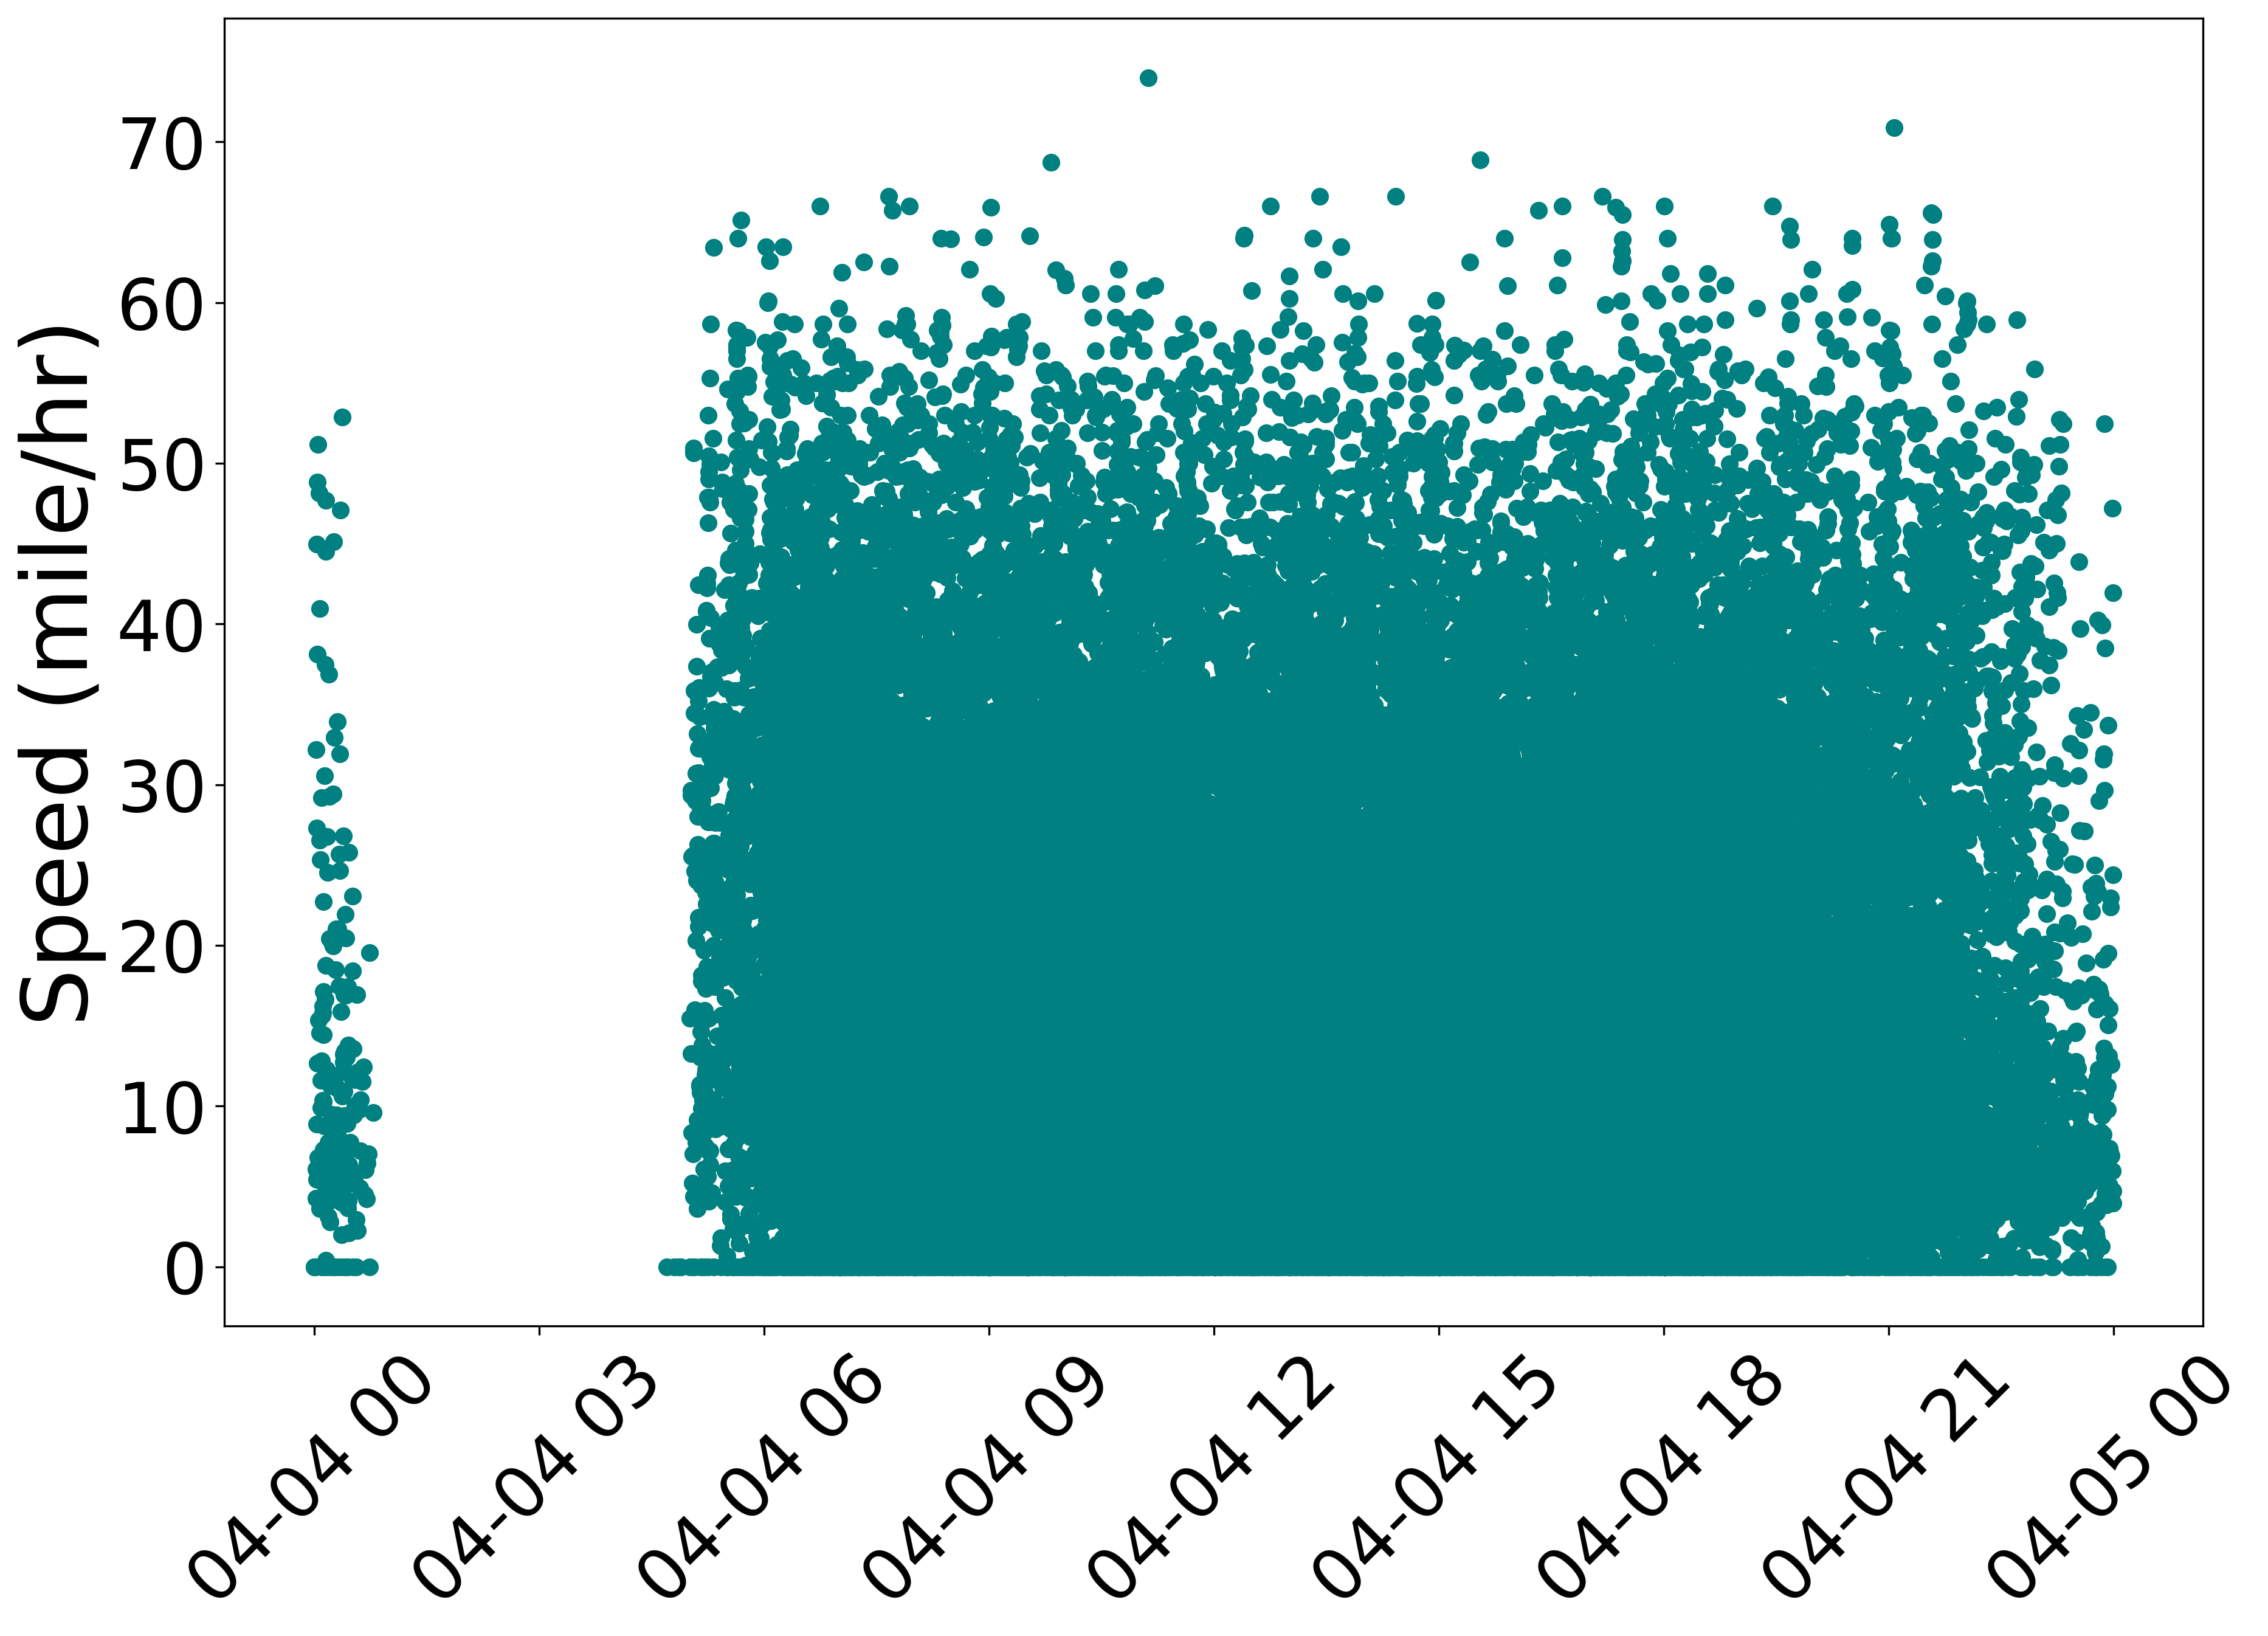

In [231]:
figure(figsize=(14, 9.5), dpi=300)
plt.plot_date(x=plot_data.index , y=plot_data["speed"], fmt='o', tz=None, xdate=True, ydate=False, color='teal')
plt.ylabel("Speed (mile/hr)", fontsize=36)
plt.xticks(fontsize=28, rotation = 45)
plt.yticks(fontsize=28)
# plt.savefig(r'../../figures/trajectories-speed.png', dpi=400, bbox_inches='tight')
plt.show()

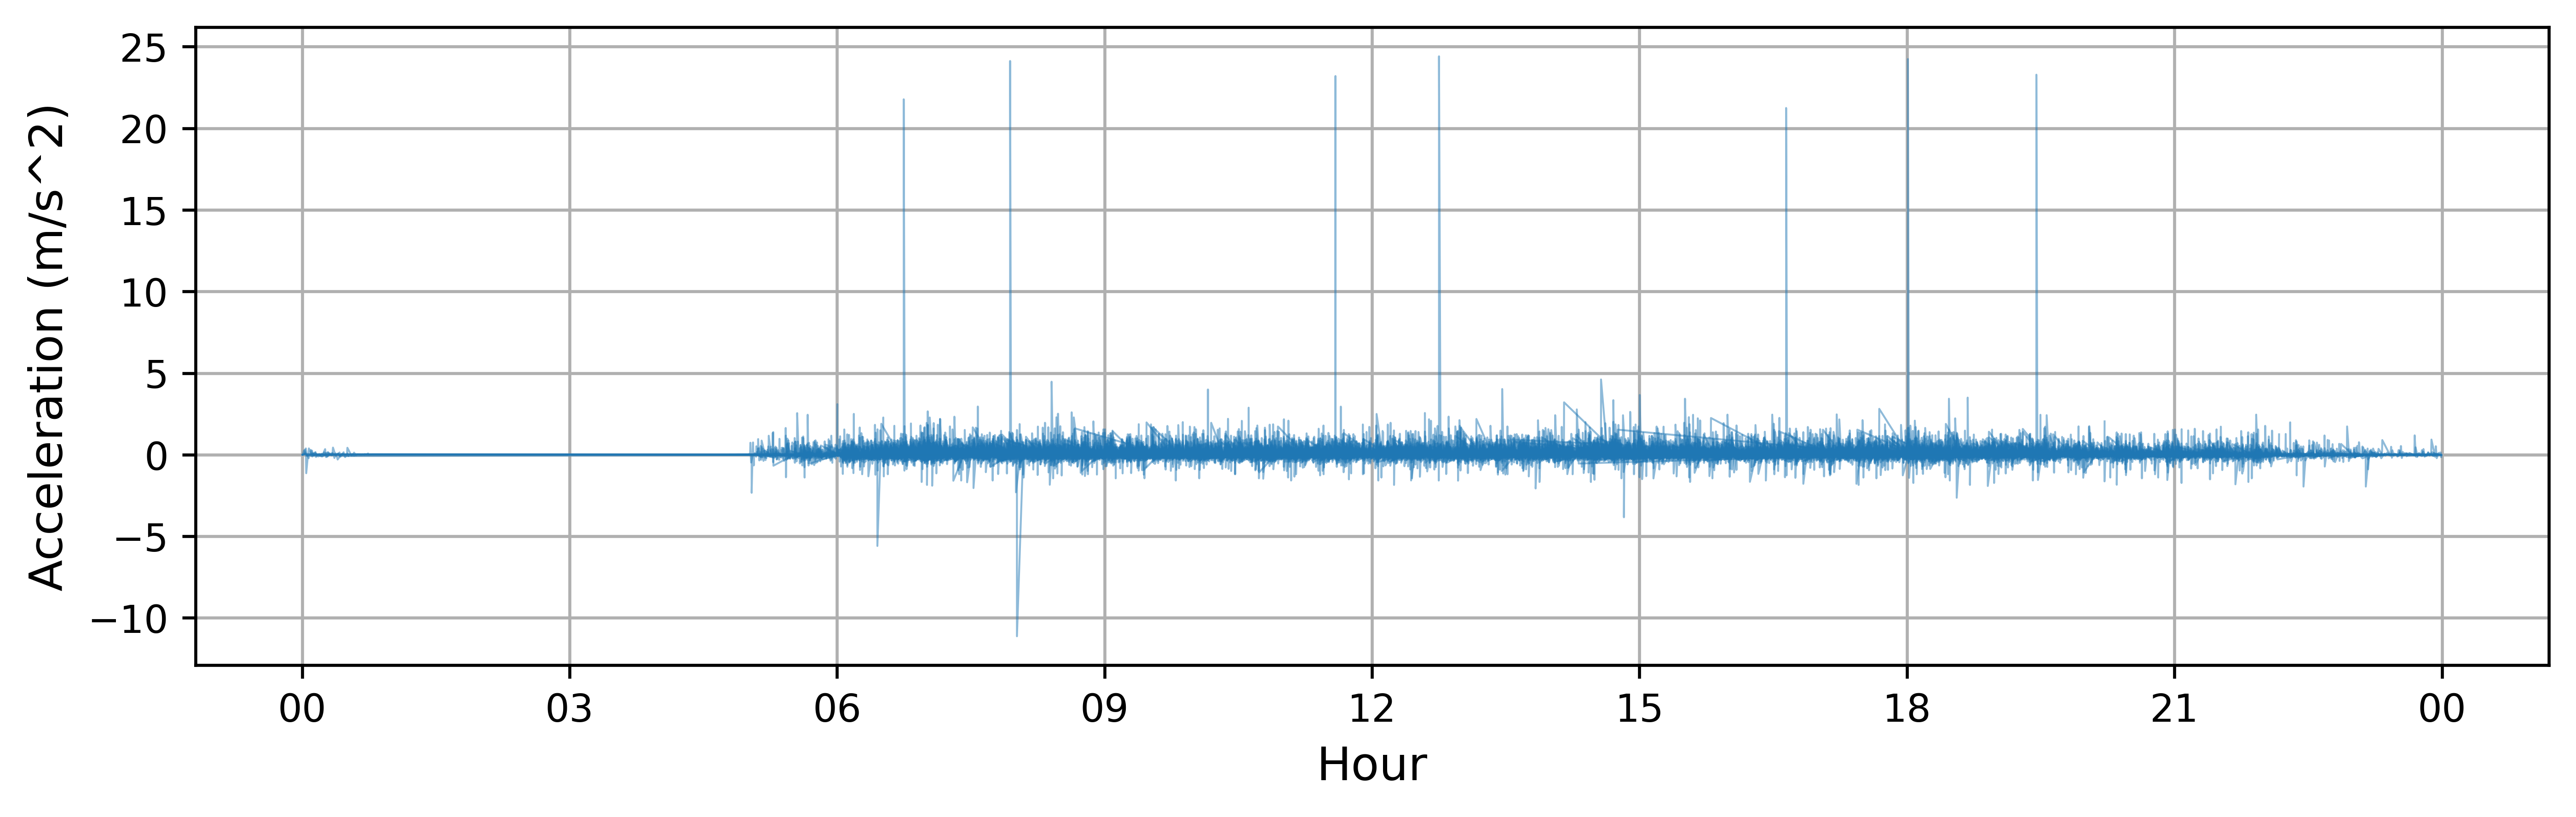

In [139]:
# set size
fig, ax = plt.subplots(figsize=(11, 3), dpi=600)
#figure(figsize=(11, 4), dpi=400)

# Plot
vehicle=plot_data['Vehicle'].unique()
for v in vehicle:
    plot_df=plot_data[plot_data['Vehicle']==v]
    plt.plot(plot_df["acc"], marker='', color='#1f77b4', linewidth=0.5, alpha=0.5)


# Labelling 

#plt.xlabel("time")
plt.ylabel("Acceleration (m/s^2)", fontsize=12)
plt.xlabel("Hour", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.title("Pandas Time Series Plot")
plt.grid()

date_form = DateFormatter("%H")
ax.xaxis.set_major_formatter(date_form)

# Saving
plt.savefig(r'../../figures/trajectories-acceleration.png', dpi=600, bbox_inches='tight')

# Display

plt.show()

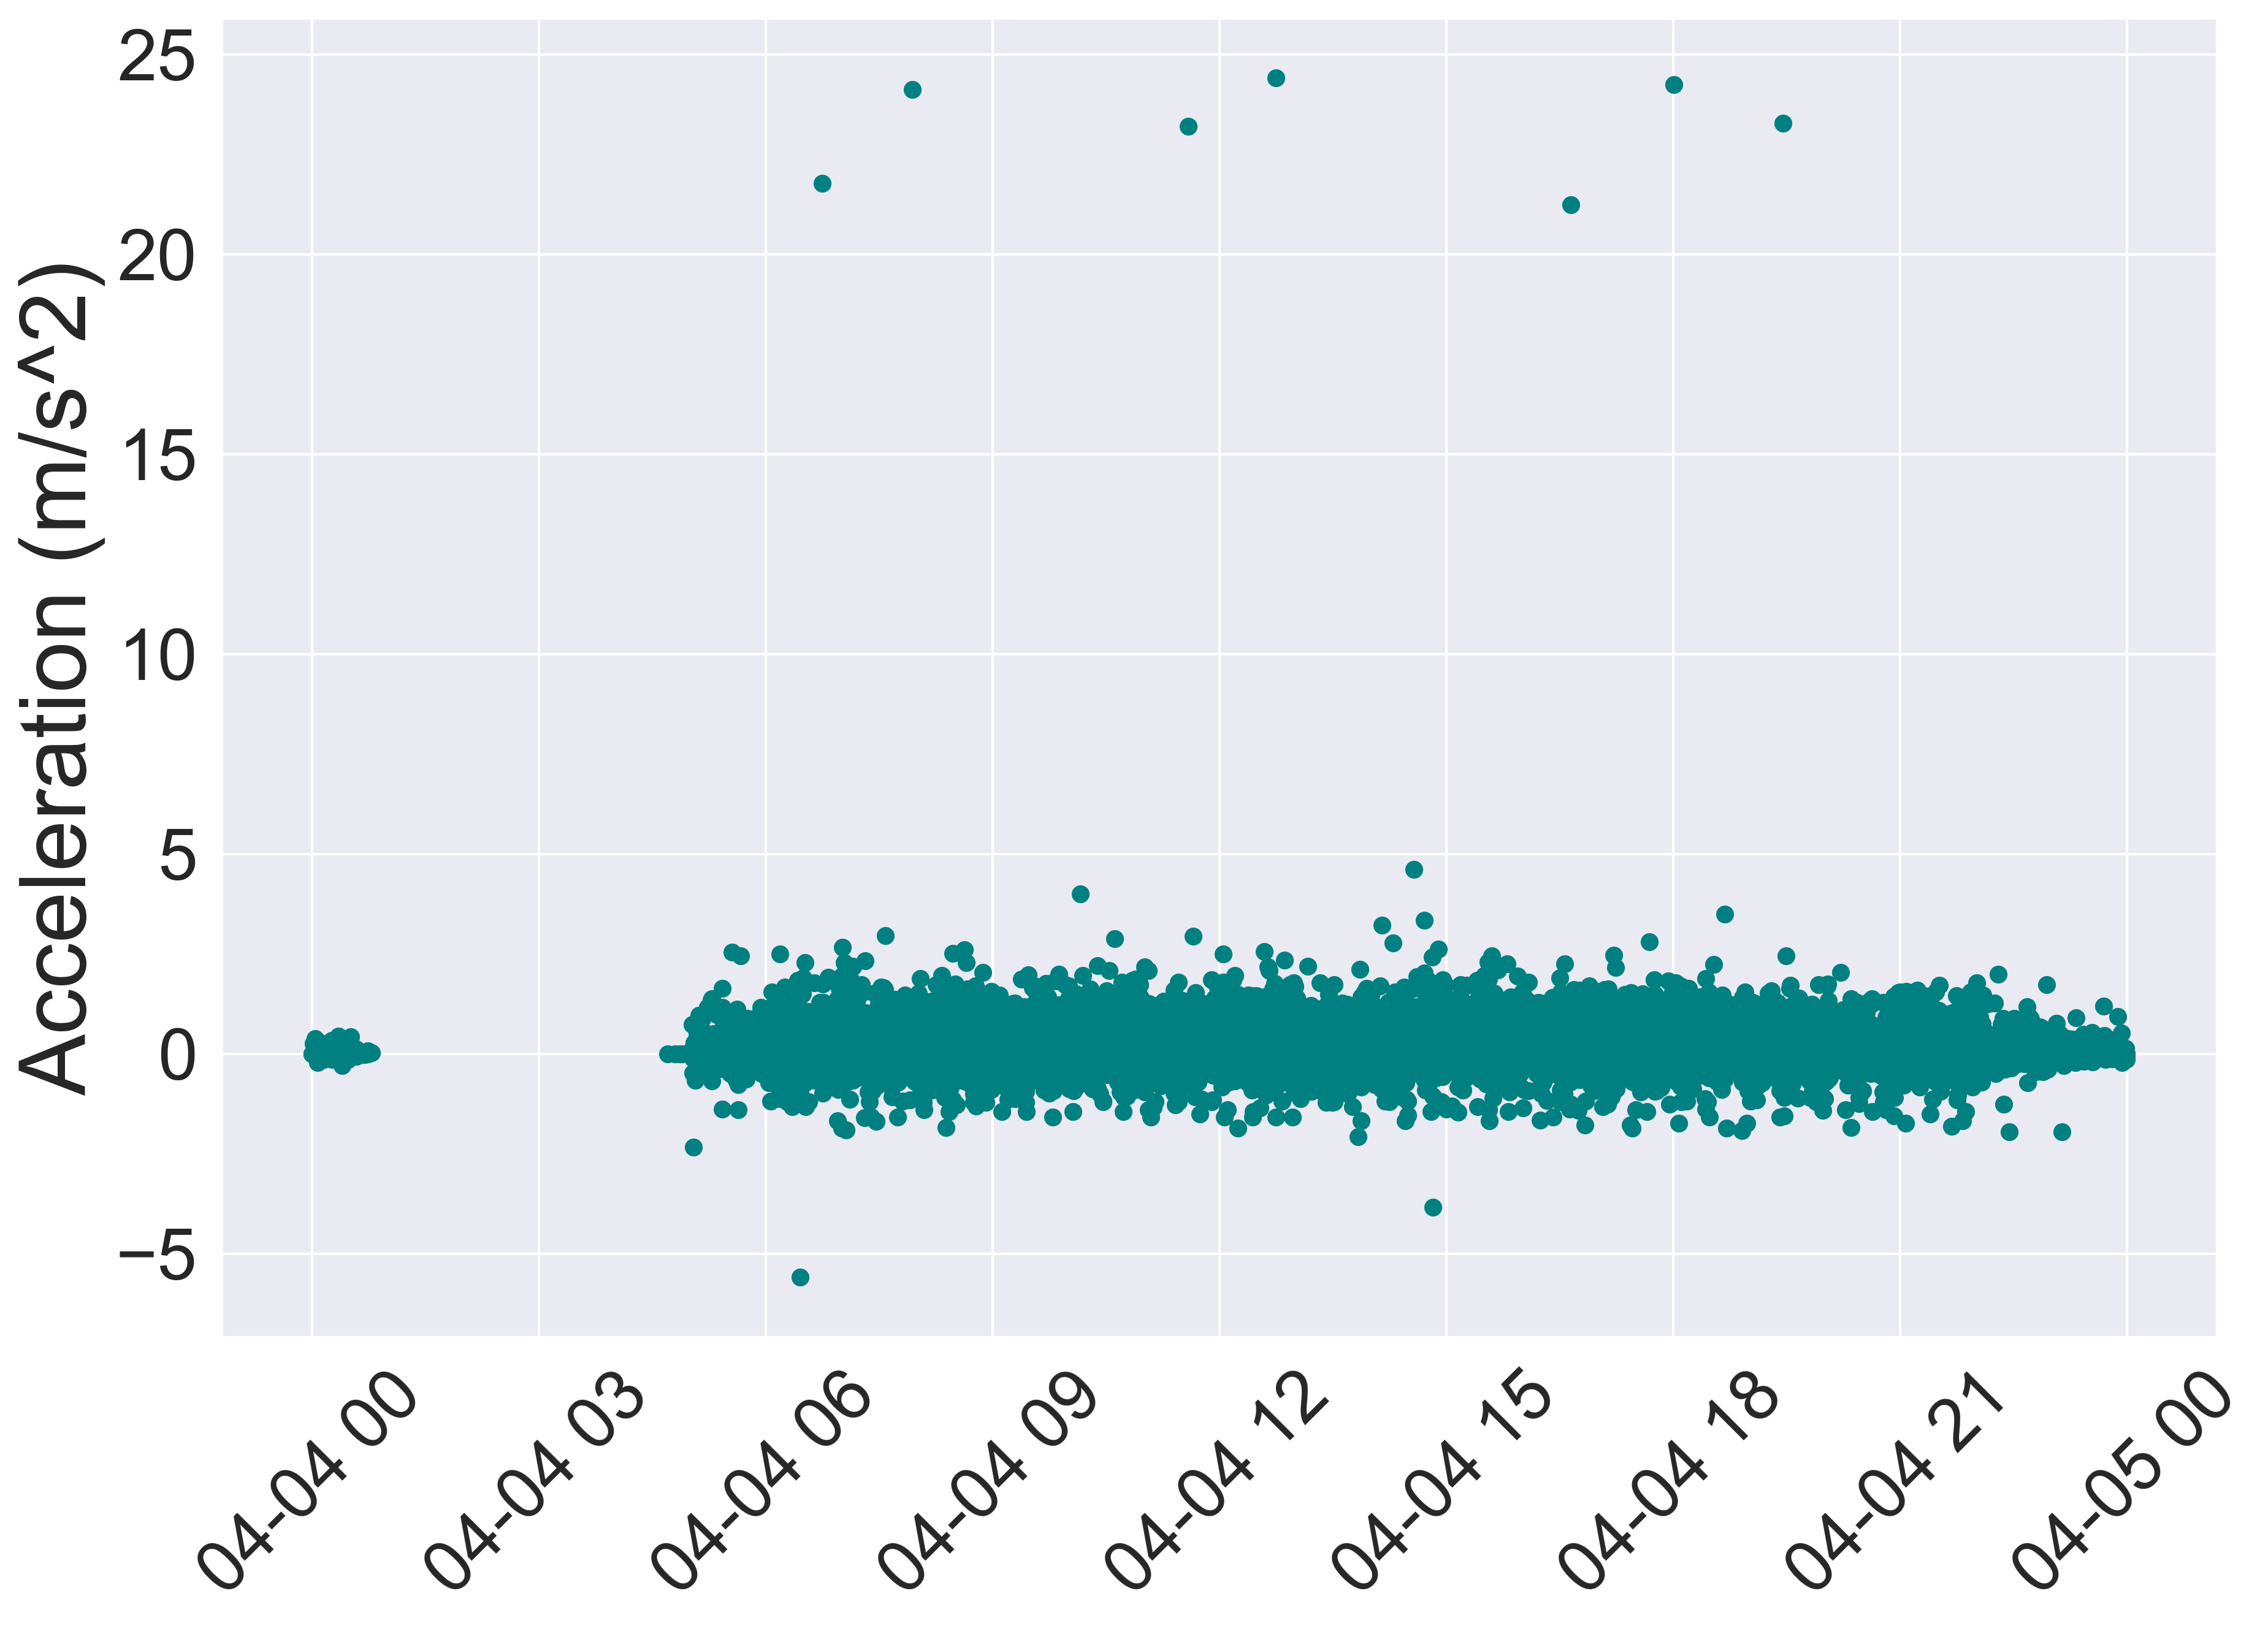

In [204]:
figure(figsize=(14, 9.5), dpi=300)
plt.plot_date(x=plot_data.index , y=plot_data["acc"], fmt='o', tz=None, xdate=True, ydate=False, color='teal')
plt.ylabel("Acceleration (m/s^2)", fontsize=36)
plt.xticks(fontsize=28, rotation = 45)
plt.yticks(fontsize=28)
# plt.savefig(r'../../figures/trajectories-acceleration.png', dpi=400, bbox_inches='tight')
plt.show()

In [140]:
trajectories=trajectories.reset_index()
trajectories.head()

ServiceDateTime  Unnamed: 0.1  Unnamed: 0  DateKey  \
0 2022-04-04 06:43:24             0      112564     8763   
1 2022-04-04 06:51:27             1      109326     8763   
2 2022-04-04 06:51:27             2      112565     8763   
3 2022-04-04 06:52:52             3      109327     8763   
4 2022-04-04 06:54:33             4      109328     8763   

              CalendarDate  Year  Month  OpKey Operator  RtKey  ...  Minute  \
0  2022-04-04 00:00:00.000  2022      4      1    VATCo   3519  ...      43   
1  2022-04-04 00:00:00.000  2022      4      1    VATCo   3513  ...      51   
2  2022-04-04 00:00:00.000  2022      4      1    VATCo   3519  ...      51   
3  2022-04-04 00:00:00.000  2022      4      1    VATCo   3513  ...      52   
4  2022-04-04 00:00:00.000  2022      4      1    VATCo   3513  ...      54   

  Second        Date  Daytype      time           time_delta  \
0     24  2022-04-04  Weekday  06:43:24                  NaN   
1     27  2022-04-04  Weekday  06:51:27  2022-12-04 00:08:03   
2     27  2022-04-04  Weekday  06:51:27  2022-12-04 00:00:00   
3     52  2022-04-04  Weekday  06:52:52  2022-12-04 00:01:25   
4     33  2022-04-04  Weekday  06:54:33  2022-12-04 00:01:41   

   time_delta_in_seconds      dist      speed       acc  
0                    NaN  0.000000   0.000000  0.000000  
1                  483.0  0.627342   0.000000  0.000000  
2                    0.0  0.000000   0.000000  0.000000  
3                   85.0  0.313431  13.274729  0.069816  
4                  101.0  0.421734  15.032101  0.007778  

[5 rows x 41 columns]

In [141]:
trajectories.sort_values(by=['ServiceDateTime','Vehicle'], ascending=True, inplace=True)

In [142]:
trajectories['Vehicle']

1062086    3303
1346943    7901
1174966    3317
1213526    3322
1213527    3322
           ... 
1245865    3325
1057256    3301
1361548    7902
1031475    3222
1245866    3325
Name: Vehicle, Length: 1361549, dtype: int64

In [143]:
trajectories['time_delta'] = trajectories.groupby(['Vehicle', 'Date'])['ServiceDateTime'].diff()

In [144]:
trajectories['time_delta'].max()

Timedelta('0 days 20:26:36')

In [145]:
trajectories['time_delta'].median()

Timedelta('0 days 00:00:41')

In [146]:
trajectories['time_delta'].min()

Timedelta('0 days 00:00:00')

In [147]:
trajectories['time_delta'].unique()

array([         'NaT',              0,    17000000000, ...,
       12664000000000,  3338000000000, 56031000000000],
      dtype='timedelta64[ns]')

In [148]:
#trajectories.time_delta=trajectories.time_delta.astype(str).str.replace('0 days ', '')

In [149]:
#trajectories['time_delta']= pd.to_datetime(trajectories['time_delta'])

In [150]:
#trajectories['time_delta_in_seconds'] = trajectories['time_delta'].dt.hour * 3600 + trajectories['time_delta'].dt.minute * 60 + trajectories['time_delta'].dt.second

In [151]:
trajectories['time_delta_in_seconds'].unique()

array([       nan, 0.0000e+00, 1.7000e+01, ..., 1.2664e+04, 3.3380e+03,
       5.6031e+04])

In [152]:
trajectories.head()

ServiceDateTime  Unnamed: 0.1  Unnamed: 0  DateKey  \
1062086 2022-04-01 00:00:00       1062086       46929     8760   
1346943 2022-04-01 00:00:08       1346943        2437     8760   
1174966 2022-04-01 00:00:12       1174966       46955     8760   
1213526 2022-04-01 00:00:18       1213526       48367     8760   
1213527 2022-04-01 00:00:18       1213527       50425     8760   

                    CalendarDate  Year  Month  OpKey Operator  RtKey  ...  \
1062086  2022-04-01 00:00:00.000  2022      4      3    UMASS   3505  ...   
1346943  2022-04-01 00:00:00.000  2022      4      1    VATCo   3515  ...   
1174966  2022-04-01 00:00:00.000  2022      4      3    UMASS   3505  ...   
1213526  2022-04-01 00:00:00.000  2022      4      3    UMASS   3508  ...   
1213527  2022-04-01 00:00:00.000  2022      4      3    UMASS   3508  ...   

         Minute Second        Date  Daytype      time  time_delta  \
1062086       0      0  2022-04-01  Weekday  00:00:00         NaT   
1346943       0      8  2022-04-01  Weekday  00:00:08         NaT   
1174966       0     12  2022-04-01  Weekday  00:00:12         NaT   
1213526       0     18  2022-04-01  Weekday  00:00:18         NaT   
1213527       0     18  2022-04-01  Weekday  00:00:18      0 days   

         time_delta_in_seconds dist  speed  acc  
1062086                    NaN  0.0    0.0  0.0  
1346943                    NaN  0.0    0.0  0.0  
1174966                    NaN  0.0    0.0  0.0  
1213526                    NaN  0.0    0.0  0.0  
1213527                    0.0  0.0    0.0  0.0  

[5 rows x 41 columns]

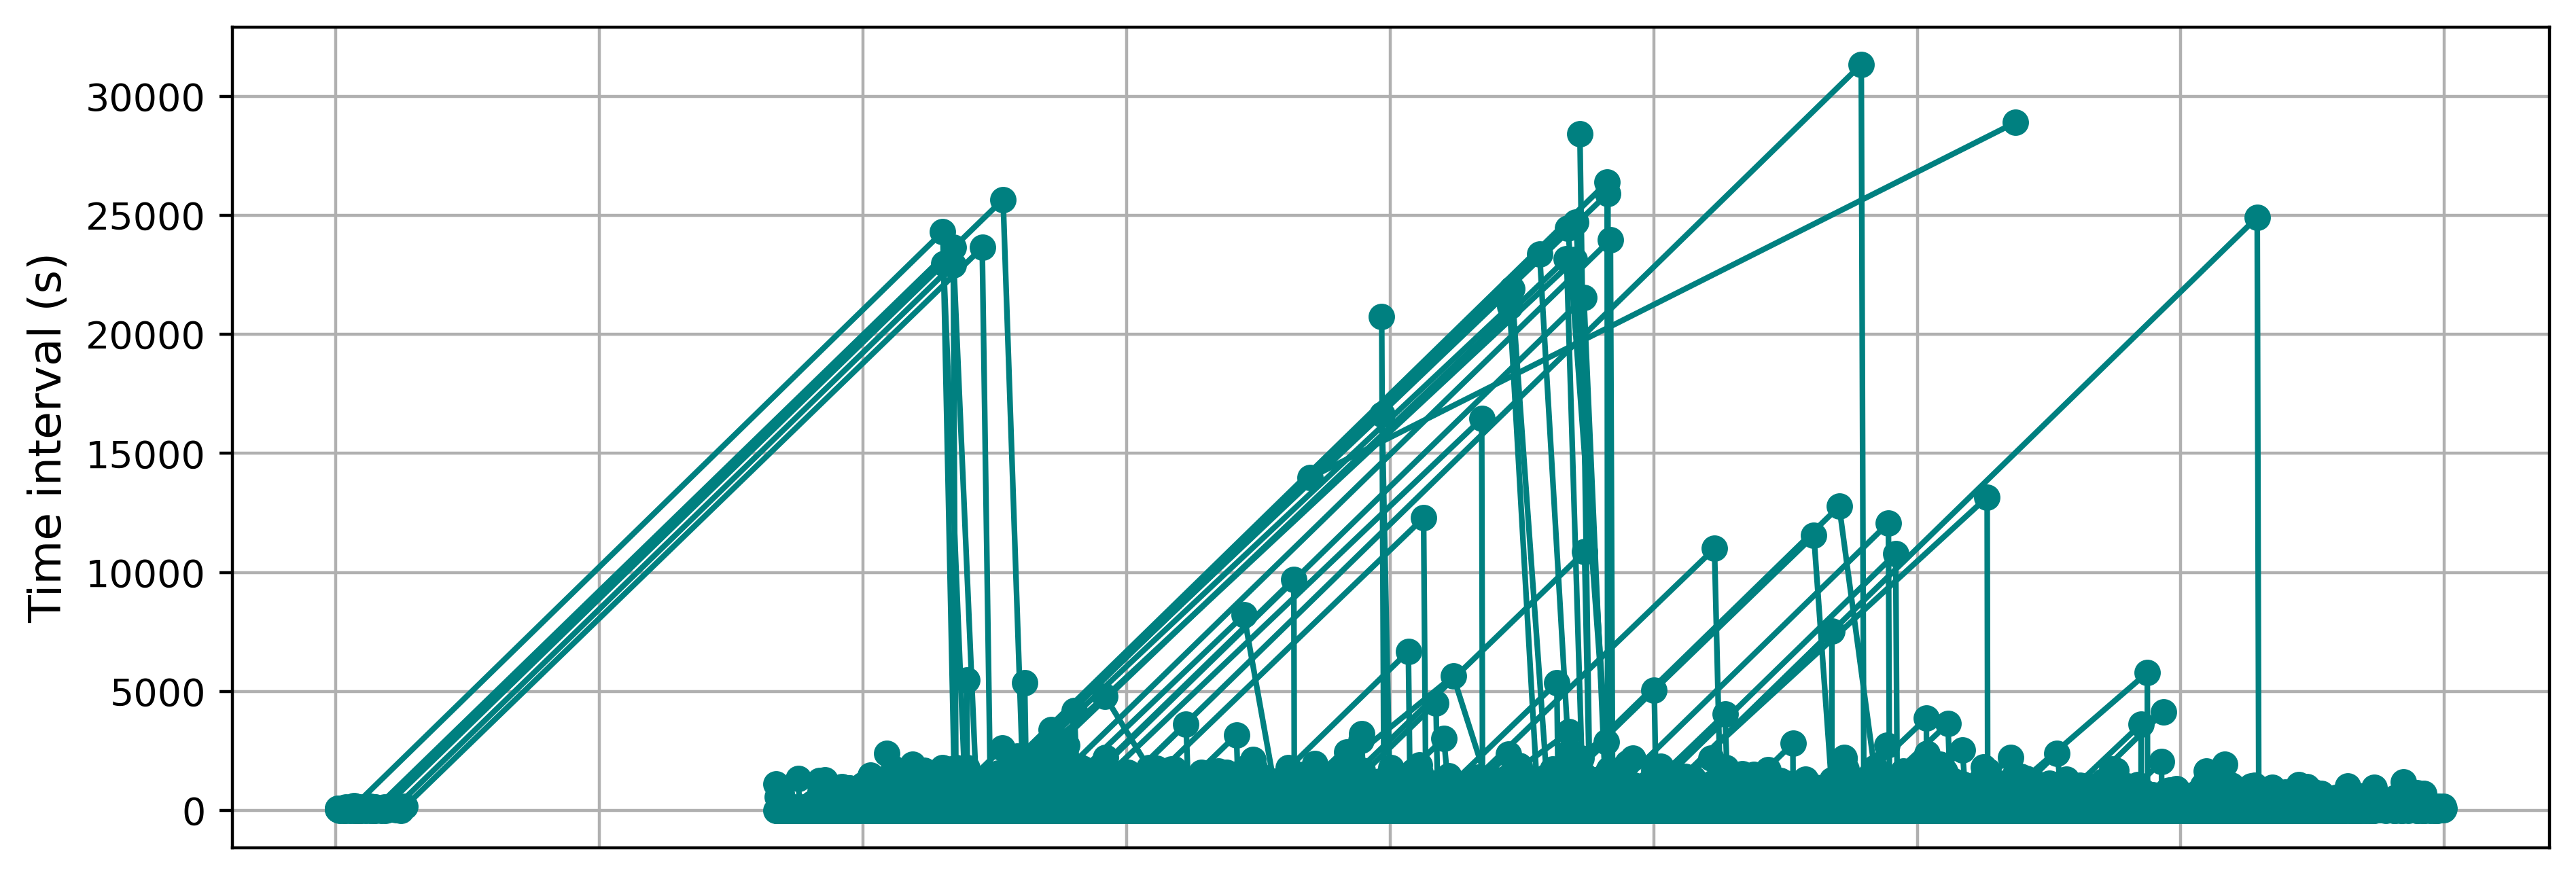

In [312]:
# set size

figure(figsize=(11, 4), dpi=400)

# Plot
vehicle=plot_data['Vehicle'].unique()
for v in vehicle:
    plot_df=plot_data[plot_data['Vehicle']==v]
    plt.plot(plot_df["time_delta_in_seconds"], marker='o', color='teal')



# Remove x-ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Labelling 

#plt.xlabel("time")
plt.ylabel("Time interval (s)", fontsize=12)
plt.yticks(fontsize=10)
#plt.title("Pandas Time Series Plot")
plt.grid()

# Saving
plt.savefig(r'../../figures/time-intervals.png', dpi=400, bbox_inches='tight')

# Display

plt.show()

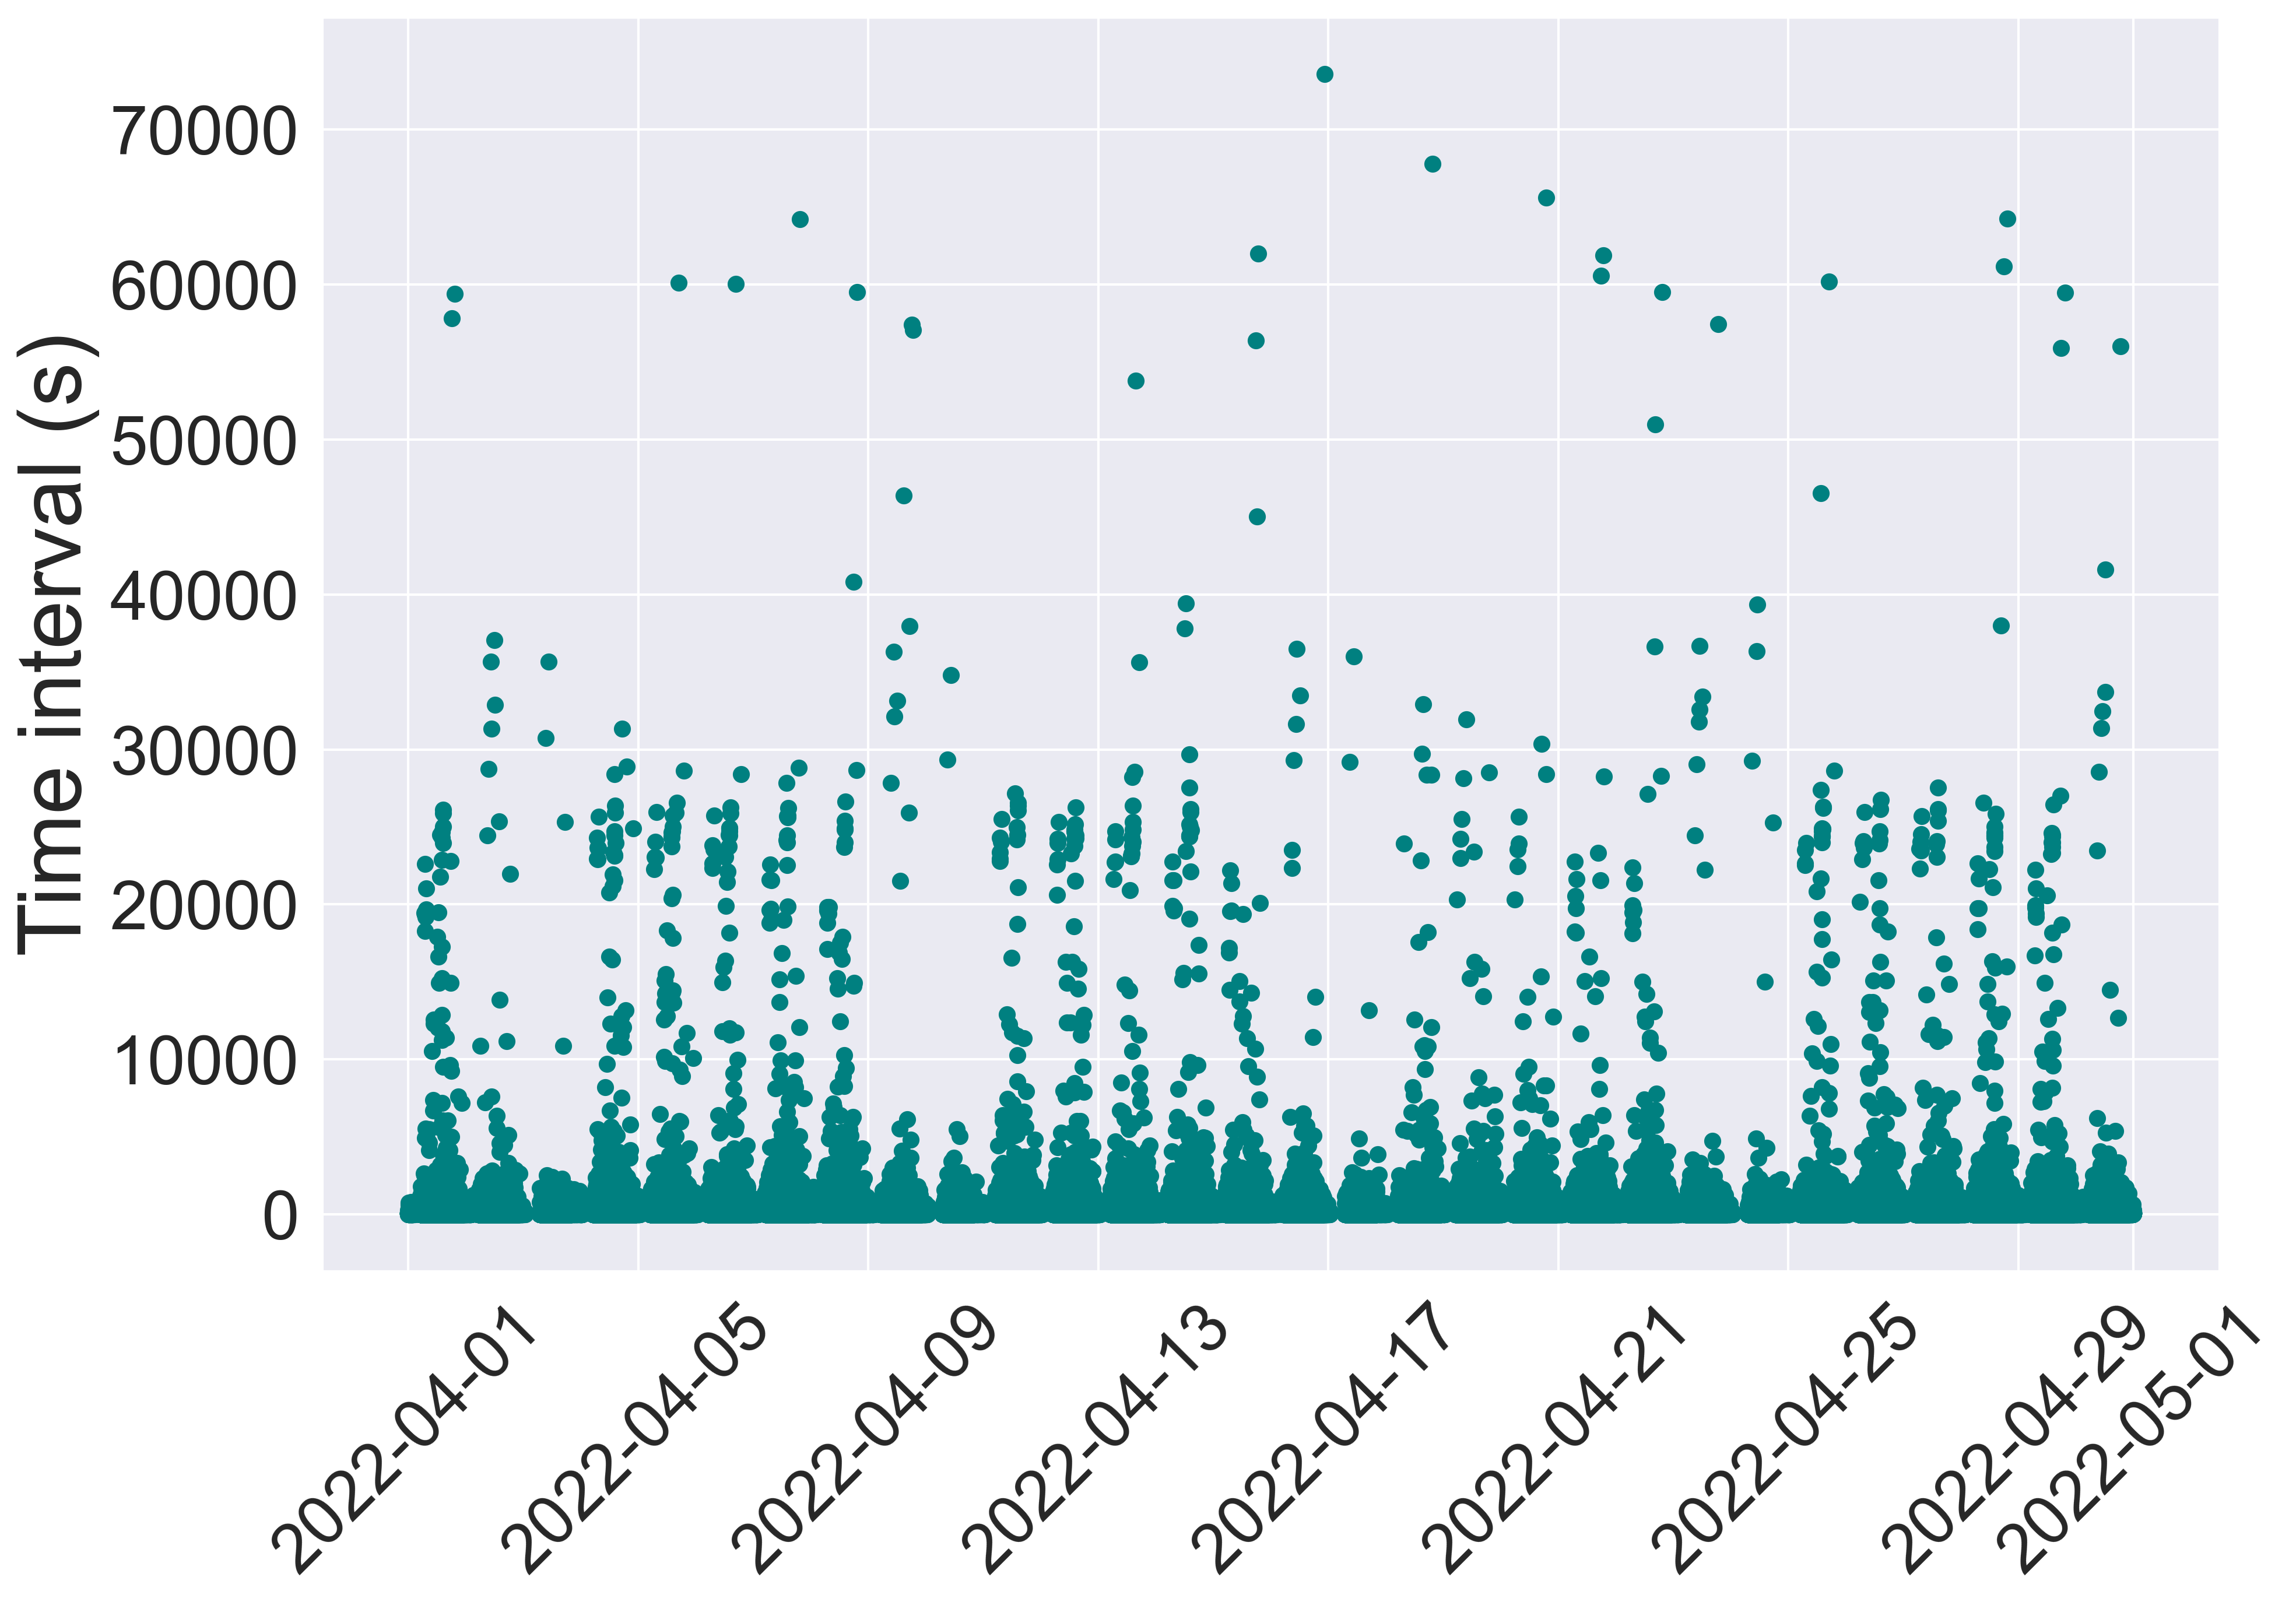

In [258]:
figure(figsize=(14, 9.5), dpi=300)
plt.plot_date(x=trajectories['ServiceDateTime']  , y=trajectories["time_delta_in_seconds"], fmt='o', tz=None, xdate=True, ydate=False, color='teal')
plt.ylabel("Time interval (s)", fontsize=36)
plt.xticks(fontsize=28, rotation = 45)
plt.yticks(fontsize=28)
#plt.savefig(r'../../figures/time-intervals.png', dpi=400, bbox_inches='tight')
plt.show()

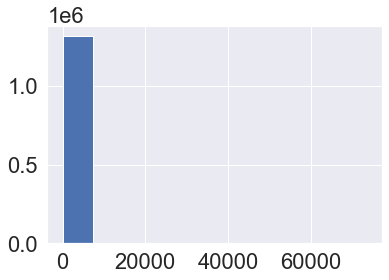

In [259]:
df_time_intervals = trajectories[trajectories['time_delta_in_seconds'] > 0]
plt.hist(df_time_intervals['time_delta_in_seconds'])
#plt.savefig(r'../../figures/hist-time-intervals.png', dpi=400, bbox_inches='tight')
plt.show()

In [264]:
len(df['Route'].unique())

49

In [275]:
#trajectories.to_csv(r'../../results/computed-trajectories-v02.csv')

In [153]:
df_acc = trajectories.sort_values('acc', ascending=False)
df_acc['acc']

1293107    40.2336
1329929    40.2336
1335234    40.2336
1359771    40.2336
1358827    40.2336
            ...   
1204773        NaN
1204774        NaN
1346555        NaN
1346556        NaN
1346557        NaN
Name: acc, Length: 1361549, dtype: float64

In [281]:
df_dist = trajectories.sort_values('dist', ascending=False)
df_dist['dist']

58281      18.700636
108414     15.433128
34204      15.433128
83989      15.433128
84389      15.433128
             ...    
1245847          NaN
1057244          NaN
1256736          NaN
1256737          NaN
1057245          NaN
Name: dist, Length: 1361549, dtype: float64

In [154]:
df_speed = trajectories.sort_values('speed', ascending=False)
df_speed['speed'].head(50000)

1074212    90.000000
1319583    90.000000
1171633    90.000000
1052139    90.000000
1306678    90.000000
             ...    
1323725    44.505421
1318764    44.505421
1333404    44.505421
1335130    44.505421
1333583    44.505421
Name: speed, Length: 50000, dtype: float64

In [155]:
trajectories['dist'].max()

18.700636389473715

In [156]:
trajectories['dist'].median()

0.1394390639866299

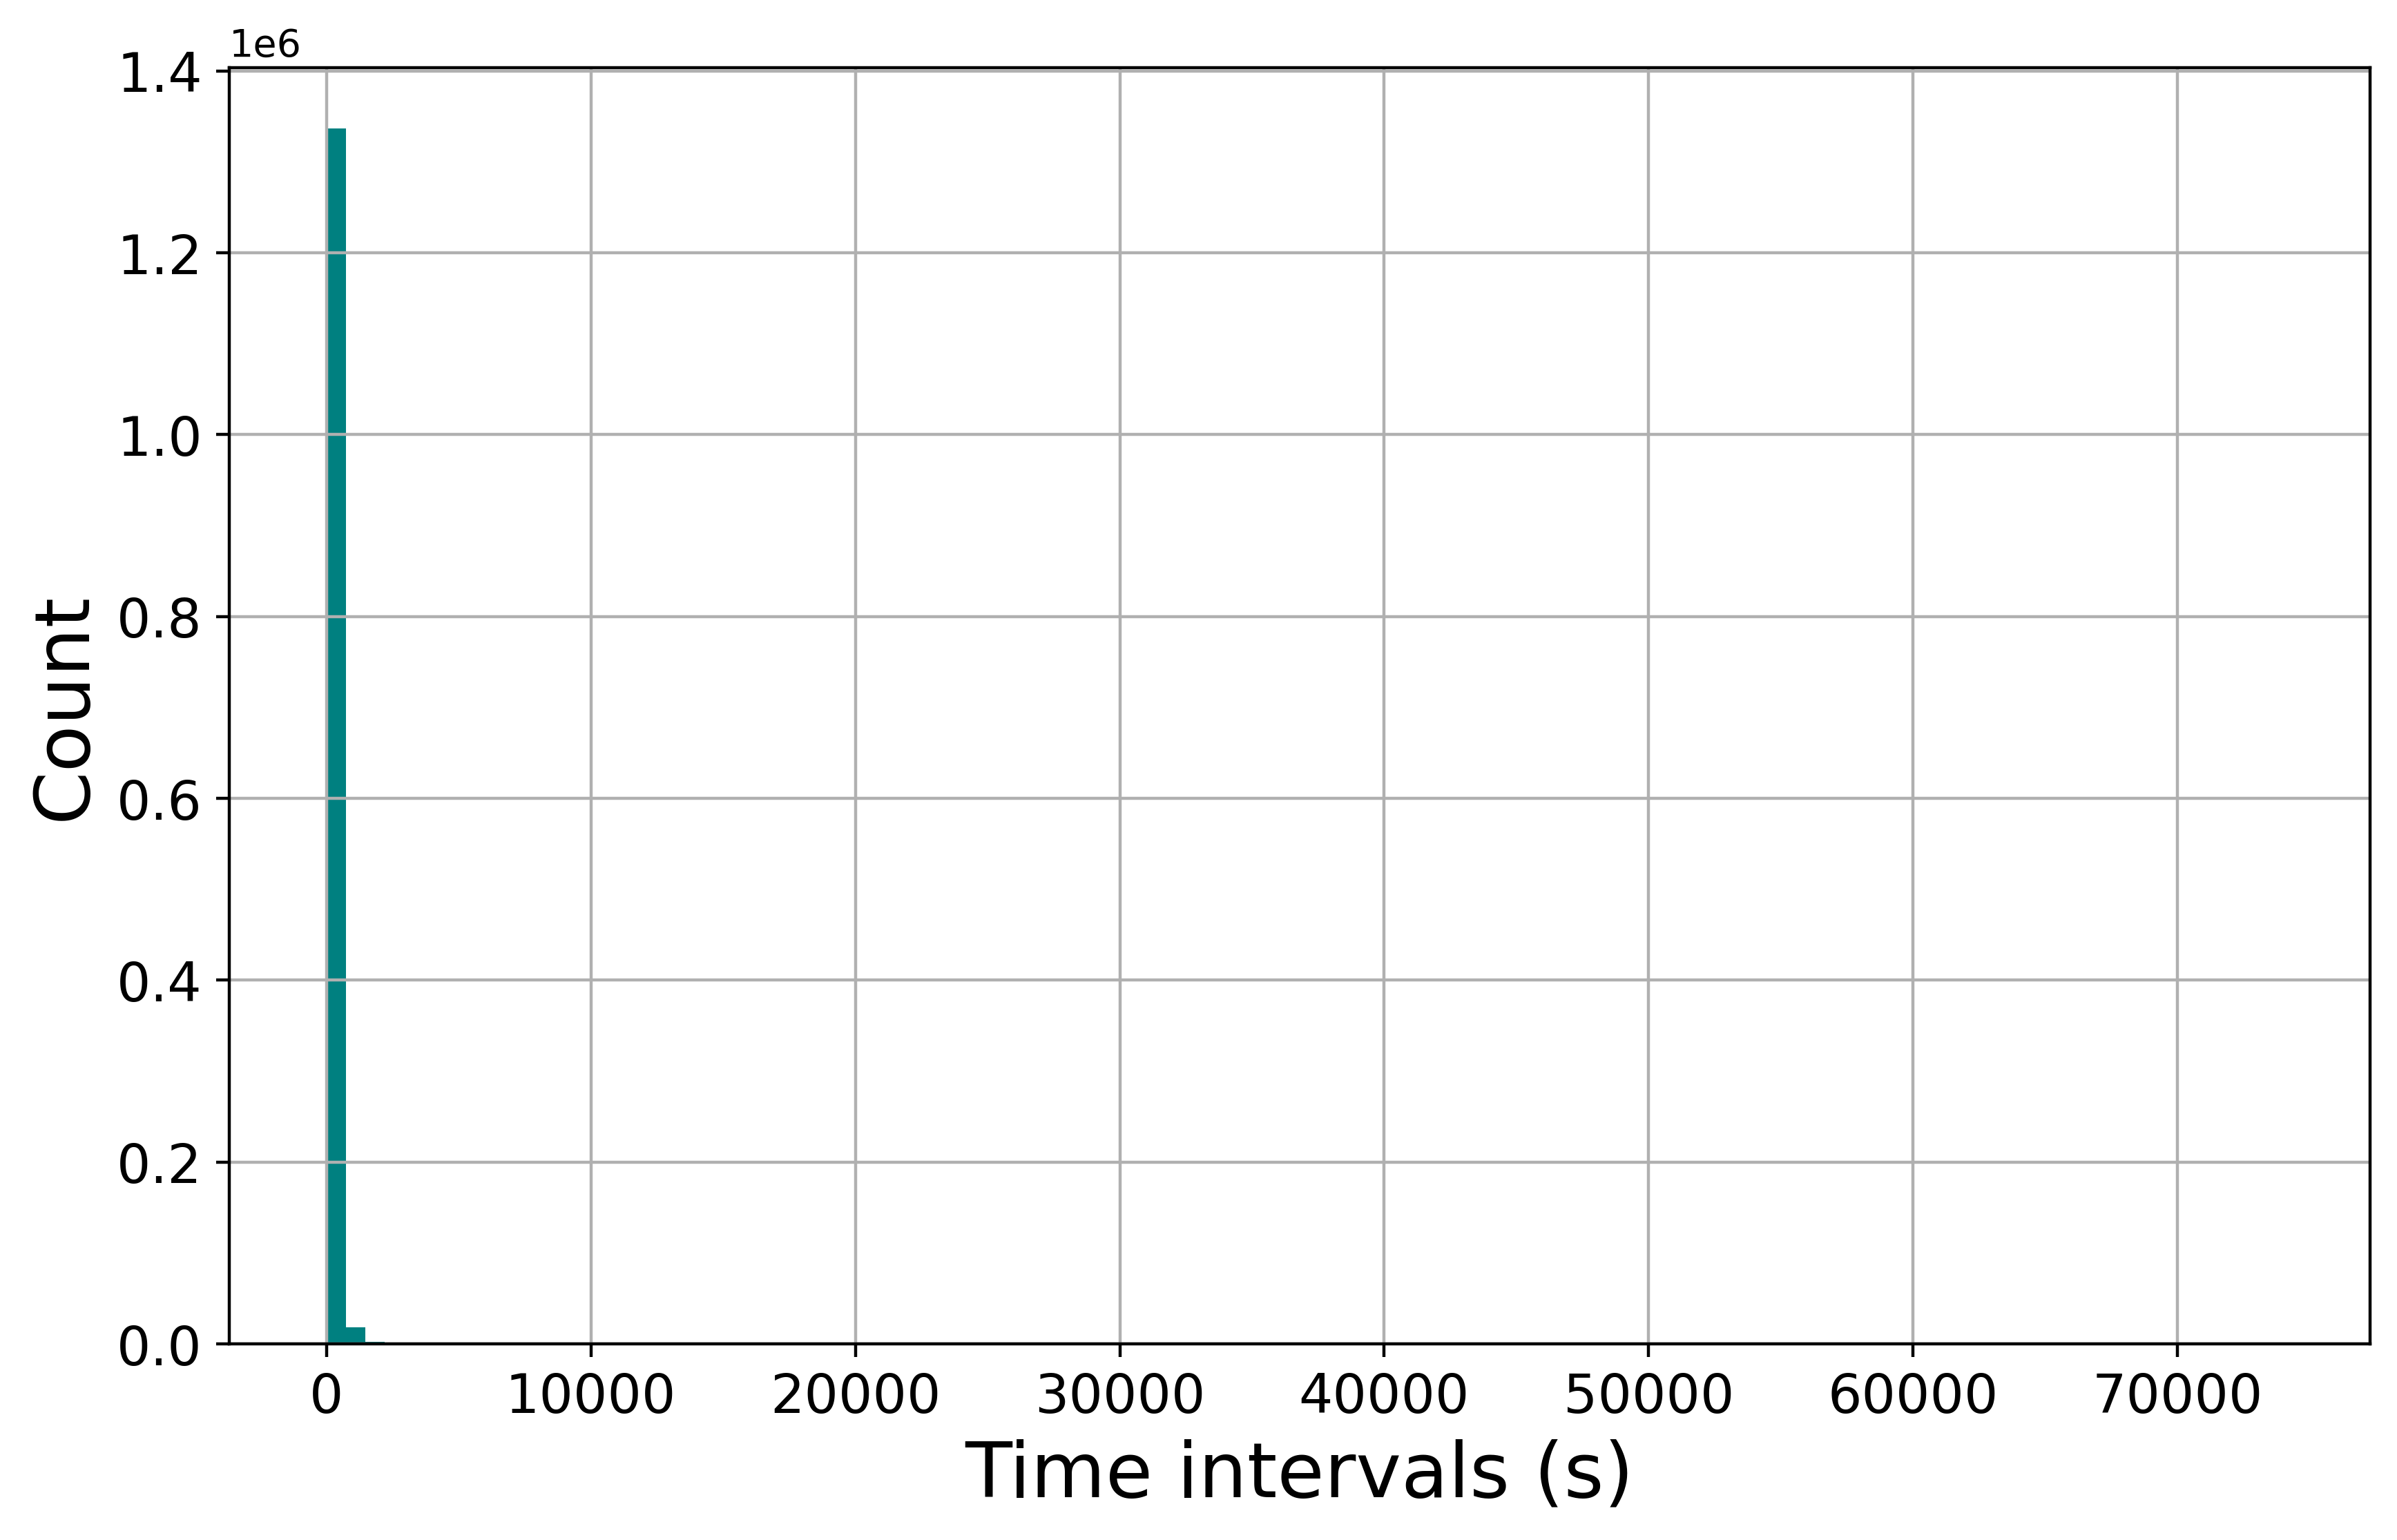

In [157]:
figure(figsize=(10, 6), dpi=400)
ax=trajectories['time_delta_in_seconds'].hist(bins=100, color='teal')
ax.set_xlabel('Time intervals (s)', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(r'../../figures/hist-time-intervals.png', dpi=400, bbox_inches='tight')

In [315]:
trajectories['time_delta_in_seconds'].max()

73596.0

In [316]:
trajectories['time_delta_in_seconds'].median()

41.0

In [317]:
trajectories['time_delta_in_seconds'].mean()

93.28536946247958

In [323]:
df_dist_outliers=trajectories[trajectories['dist']>15]

In [324]:
df_dist_outliers

Unnamed: 0.1  Unnamed: 0  DateKey  \
ServiceDateTime                                          
2022-04-05 17:53:05         34204      206300     8764   
2022-04-18 17:13:14         58281      757850     8777   
2022-04-25 17:50:45         70610     1060393     8784   
2022-04-04 17:50:27         73742      152939     8763   
2022-04-08 06:35:13         83989      366354     8767   
2022-04-08 17:52:24         84389      366875     8767   
2022-04-01 17:51:03        108414       43654     8760   
2022-04-11 17:55:02        111686      437762     8770   
2022-04-11 08:52:46        129899      469666     8770   
2022-04-18 15:25:51        132613      757842     8777   
2022-04-29 17:55:46        144419     1273091     8788   
2022-04-12 06:30:46        325383      529847     8771   
2022-04-13 06:37:44        381295      544246     8772   
2022-04-12 06:38:18        388784      491128     8771   
2022-04-27 06:37:33        415631     1168049     8786   
2022-04-18 05:30:25        445600      787246     8777   

                                CalendarDate  Year  Month  OpKey Operator  \
ServiceDateTime                                                             
2022-04-05 17:53:05  2022-04-05 00:00:00.000  2022      4      2    SATCo   
2022-04-18 17:13:14  2022-04-18 00:00:00.000  2022      4      2    SATCo   
2022-04-25 17:50:45  2022-04-25 00:00:00.000  2022      4      2    SATCo   
2022-04-04 17:50:27  2022-04-04 00:00:00.000  2022      4      2    SATCo   
2022-04-08 06:35:13  2022-04-08 00:00:00.000  2022      4      2    SATCo   
2022-04-08 17:52:24  2022-04-08 00:00:00.000  2022      4      2    SATCo   
2022-04-01 17:51:03  2022-04-01 00:00:00.000  2022      4      2    SATCo   
2022-04-11 17:55:02  2022-04-11 00:00:00.000  2022      4      2    SATCo   
2022-04-11 08:52:46  2022-04-11 00:00:00.000  2022      4      2    SATCo   
2022-04-18 15:25:51  2022-04-18 00:00:00.000  2022      4      2    SATCo   
2022-04-29 17:55:46  2022-04-29 00:00:00.000  2022      4      2    SATCo   
2022-04-12 06:30:46  2022-04-12 00:00:00.000  2022      4      2    SATCo   
2022-04-13 06:37:44  2022-04-13 00:00:00.000  2022      4      2    SATCo   
2022-04-12 06:38:18  2022-04-12 00:00:00.000  2022      4      2    SATCo   
2022-04-27 06:37:33  2022-04-27 00:00:00.000  2022      4      2    SATCo   
2022-04-18 05:30:25  2022-04-18 00:00:00.000  2022      4      2    SATCo   

                     RtKey  RtKey2  ... Minute Second        Date  Daytype  \
ServiceDateTime                     ...                                      
2022-04-05 17:53:05   3630    1104  ...     53      5  2022-04-05  Weekday   
2022-04-18 17:13:14   3631    1104  ...     13     14  2022-04-18  Weekday   
2022-04-25 17:50:45   3631    1104  ...     50     45  2022-04-25  Weekday   
2022-04-04 17:50:27   3630    1104  ...     50     27  2022-04-04  Weekday   
2022-04-08 06:35:13   3620    3285  ...     35     13  2022-04-08  Weekday   
2022-04-08 17:52:24   3630    1104  ...     52     24  2022-04-08  Weekday   
2022-04-01 17:51:03   3630    1104  ...     51      3  2022-04-01  Weekday   
2022-04-11 17:55:02   3631    1104  ...     55      2  2022-04-11  Weekday   
2022-04-11 08:52:46   3655    1099  ...     52     46  2022-04-11  Weekday   
2022-04-18 15:25:51   3631    1104  ...     25     51  2022-04-18  Weekday   
2022-04-29 17:55:46   3631    1104  ...     55     46  2022-04-29  Weekday   
2022-04-12 06:30:46   3664    3285  ...     30     46  2022-04-12  Weekday   
2022-04-13 06:37:44   3631    1104  ...     37     44  2022-04-13  Weekday   
2022-04-12 06:38:18   3631    1104  ...     38     18  2022-04-12  Weekday   
2022-04-27 06:37:33   3645    1086  ...     37     33  2022-04-27  Weekday   
2022-04-18 05:30:25   3655    1099  ...     30     25  2022-04-18  Weekday   

                         time           time_delta time_delta_in_seconds  \
ServiceDateTime                                                            
2022-04-05 17:53:05  17:53:05  2

In [327]:
df_time_intervals_outliers=trajectories[trajectories['time_delta_in_seconds']>50000]

In [328]:
df_time_intervals_outliers

Unnamed: 0.1  Unnamed: 0  DateKey  \
ServiceDateTime                                          
2022-04-21 18:53:04       1049579      948594     8780   
2022-04-13 15:42:18       1125185      587700     8772   
2022-04-18 19:28:03       1148306      795469     8777   
2022-04-20 18:51:56       1171769      898015     8779   
2022-04-15 18:41:54       1179445      694124     8774   
2022-04-09 18:11:21       1186001      411711     8768   
2022-04-16 22:22:13       1239908      734460     8775   
2022-04-05 16:49:19       1307711      163144     8764   
2022-04-06 16:50:01       1307952      216585     8765   
2022-04-25 16:51:07       1332812     1056403     8784   
2022-04-01 18:14:07       1334372        1944     8760   
2022-04-01 19:24:26       1347071          21     8760   
2022-04-07 19:25:06       1349116      269361     8766   
2022-04-08 19:24:57       1349412      323256     8767   
2022-04-09 18:37:44       1349696      380420     8768   
2022-04-22 19:24:55       1353820      950795     8781   
2022-04-28 17:53:40       1355758     1214980     8787   
2022-04-29 17:43:24       1356050     1268769     8788   
2022-04-30 18:38:10       1356367     1326715     8789   
2022-04-15 17:50:30       1358234      646219     8774   
2022-04-21 17:47:00       1358859      900195     8780   
2022-04-22 16:20:48       1359155      952535     8781   
2022-04-23 18:40:39       1359510     1004566     8782   
2022-04-28 19:23:58       1360556     1214984     8787   
2022-04-29 19:24:38       1360853     1268774     8788   

                                CalendarDate  Year  Month  OpKey Operator  \
ServiceDateTime                                                             
2022-04-21 18:53:04  2022-04-21 00:00:00.000  2022      4      3    UMASS   
2022-04-13 15:42:18  2022-04-13 00:00:00.000  2022      4      3    UMASS   
2022-04-18 19:28:03  2022-04-18 00:00:00.000  2022      4      3    UMASS   
2022-04-20 18:51:56  2022-04-20 00:00:00.000  2022      4      3    UMASS   
2022-04-15 18:41:54  2022-04-15 00:00:00.000  2022      4      3    UMASS   
2022-04-09 18:11:21  2022-04-09 00:00:00.000  2022      4      3    UMASS   
2022-04-16 22:22:13  2022-04-16 00:00:00.000  2022      4      3    UMASS   
2022-04-05 16:49:19  2022-04-05 00:00:00.000  2022      4      1    VATCo   
2022-04-06 16:50:01  2022-04-06 00:00:00.000  2022      4      1    VATCo   
2022-04-25 16:51:07  2022-04-25 00:00:00.000  2022      4      1    VATCo   
2022-04-01 18:14:07  2022-04-01 00:00:00.000  2022      4      1    VATCo   
2022-04-01 19:24:26  2022-04-01 00:00:00.000  2022      4      1    VATCo   
2022-04-07 19:25:06  2022-04-07 00:00:00.000  2022      4      1    VATCo   
2022-04-08 19:24:57  2022-04-08 00:00:00.000  2022      4      1    VATCo   
2022-04-09 18:37:44  2022-04-09 00:00:00.000  2022      4      1    VATCo   
2022-04-22 19:24:55  2022-04-22 00:00:00.000  2022      4      1    VATCo   
2022-04-28 17:53:40  2022-04-28 00:00:00.000  2022      4      1    VATCo   
2022-04-29 17:43:24  2022-04-29 00:00:00.000  2022      4      1    VATCo   
2022-04-30 18:38:10  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-15 17:50:30  2022-04-15 00:00:00.000  2022      4      1    VATCo   
2022-04-21 17:47:00  2022-04-21 00:00:00.000  2022      4      1    VATCo   
2022-04-22 16:20:48  2022-04-22 00:00:00.000  2022      4      1    VATCo   
2022-04-23 18:40:39  2022-04-23 00:00:00.000  2022      4      1    VATCo   
2022-04-28 19:23:58  2022-04-28 00:00:00.000  2022      4      1    VATCo   
2022-04-29 19:24:38  2022-04-29 00:00:00.000  2022      4      1    VATCo   

                     RtKey  RtKey2  ... Minute Second        Date  Daytype  \
ServiceDateTime                     ...                                      
2022-04-21 18:53:04   3626    1734  ...     53      4  2022-04-21  Weekday   
2022-04-13 15:42:18   3624    1737  ...     42     18  2022-04-13  Weekday   
2022-04-18 19:28:03   3624    1737  ...     28      3  2022-04

In [2]:
#df[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(df['Vehicle'] == 1642) & (df['Date'] == '2022-04-04') ]

In [158]:
trajectories[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(trajectories['Vehicle'] == 1642) & (trajectories['Date'] == '2022-04-04') ]

ServiceDateTime        Date  Vehicle      dist      speed       acc
151620 2022-04-04 07:14:26  2022-04-04     1642  0.000000   0.000000  0.000000
151621 2022-04-04 07:15:25  2022-04-04     1642  0.268592  16.388644  0.124176
151622 2022-04-04 07:16:27  2022-04-04     1642  0.310223  18.012945  0.011712
151623 2022-04-04 07:17:20  2022-04-04     1642  0.147543  10.021773 -0.067403
151624 2022-04-04 07:18:14  2022-04-04     1642  0.181551  12.103388  0.017233
151625 2022-04-04 07:19:42  2022-04-04     1642  0.474900  19.427711  0.037208
151626 2022-04-04 07:19:56  2022-04-04     1642  0.100140  25.750371  0.201892
151627 2022-04-04 07:20:43  2022-04-04     1642  0.110635   8.474147 -0.164323
151628 2022-04-04 07:21:22  2022-04-04     1642  0.154770  14.286429  0.066624
151629 2022-04-04 07:21:43  2022-04-04     1642  0.121848  20.888281  0.140538
151630 2022-04-04 07:23:03  2022-04-04     1642  0.021112   0.950030 -0.111415
151631 2022-04-04 07:23:03  2022-04-04     1642  0.000000   0.000000  0.000000
151632 2022-04-04 07:40:30  2022-04-04     1642  6.828609  23.479458  0.010025
151633 2022-04-04 14:06:01  2022-04-04     1642  0.000000   0.000000 -0.000454
151634 2022-04-04 14:28:51  2022-04-04     1642  1.638041   4.304342  0.001405
151635 2022-04-04 14:28:51  2022-04-04     1642  0.000000   0.000000  0.000000
151636 2022-04-04 14:29:22  2022-04-04     1642  0.076097   8.837121  0.127437
151637 2022-04-04 14:29:42  2022-04-04     1642  0.238878  42.998065  0.763565
151638 2022-04-04 14:30:04  2022-04-04     1642  0.196790  32.202001 -0.219376
151639 2022-04-04 14:31:48  2022-04-04     1642  0.150945   5.225026 -0.115959
151640 2022-04-04 14:32:23  2022-04-04     1642  0.221524  22.785323  0.224290
151641 2022-04-04 14:32:57  2022-04-04     1642  0.117994  12.493527 -0.135319
151642 2022-04-04 14:33:57  2022-04-04     1642  0.159463   9.567790 -0.021799
151643 2022-04-04 14:35:13  2022-04-04     1642  0.101656   4.815272 -0.027955
151644 2022-04-04 14:35:36  2022-04-04     1642  0.140320  21.963140  0.333295
151645 2022-04-04 14:37:59  2022-04-04     1642  0.347637   8.751709 -0.041301
151646 2022-04-04 14:38:29  2022-04-04     1642  0.114302  13.716233  0.073978
151647 2022-04-04 14:39:22  2022-04-04     1642  0.166958  11.340572 -0.020038
151648 2022-04-04 14:40:25  2022-04-04     1642  0.065020   3.715404 -0.054107
151649 2022-04-04 14:42:38  2022-04-04     1642  0.229239   6.204975  0.008368
151650 2022-04-04 14:43:07  2022-04-04     1642  0.212041  26.322322  0.310112
151651 2022-04-04 14:44:46  2022-04-04     1642  0.311025  11.309998 -0.067789
151652 2022-04-04 14:48:48  2022-04-04     1642  0.157536   2.343517 -0.016564
151653 2022-04-04 14:48:54  2022-04-04     1642  0.057970  34.782231  2.416901
151654 2022-04-04 14:50:25  2022-04-04     1642  0.323601  12.801780 -0.107980
151655 2022-04-04 14:50:25  2022-04-04     1642  0.000000   0.000000  0.000000

In [317]:
trajectories[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(trajectories['Vehicle'] == 1729) & (trajectories['Date'] == '2022-04-19') ]

ServiceDateTime        Date  Vehicle  dist  speed  acc
486172 2022-04-19 05:49:19  2022-04-19     1729   0.0    0.0  0.0

In [160]:
nans=trajectories[trajectories['dist'].isna()]

In [162]:
nans[['ServiceDateTime','Date','Vehicle','Lon','Lat','dist','speed','acc']]
#nans[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(nans['Vehicle'] == 1642) & (trajectories['Date'] == '2022-04-04') ]

ServiceDateTime        Date  Vehicle        Lon        Lat  dist  \
1093910 2022-04-01 07:01:50  2022-04-01     3307 -72.533010  42.393760   NaN   
1021663 2022-04-01 07:20:09  2022-04-01     3222 -72.533010  42.393760   NaN   
1078898 2022-04-01 07:24:38  2022-04-01     3305        NaN        NaN   NaN   
1078899 2022-04-01 07:31:01  2022-04-01     3305 -72.532480  42.405880   NaN   
1268491 2022-04-01 13:00:52  2022-04-01     7552 -72.633052  42.317699   NaN   
...                     ...         ...      ...        ...        ...   ...   
1164340 2022-04-29 07:15:45  2022-04-29     3313 -72.533010  42.393760   NaN   
1204772 2022-04-29 08:24:42  2022-04-29     3319        NaN        NaN   NaN   
1204773 2022-04-29 08:28:34  2022-04-29     3319 -72.533010  42.393760   NaN   
1346555 2022-04-29 14:00:00  2022-04-29     7816        NaN        NaN   NaN   
1346556 2022-04-29 14:05:54  2022-04-29     7816 -72.633050  42.317700   NaN   

         speed  acc  
1093910    NaN  NaN  
1021663    NaN  NaN  
1078898    NaN  NaN  
1078899    NaN  NaN  
1268491    NaN  NaN  
...        ...  ...  
1164340    NaN  NaN  
1204772    NaN  NaN  
1204773    NaN  NaN  
1346555    NaN  NaN  
1346556    NaN  NaN  

[89 rows x 8 columns]

In [86]:
df[df['dist'].isna()]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
45      2022-04-04 08:15:00      109371     8763  2022-04-04 00:00:00.000   
46      2022-04-04 08:15:23      109369     8763  2022-04-04 00:00:00.000   
126     2022-04-04 10:54:00      109451     8763  2022-04-04 00:00:00.000   
127     2022-04-04 10:55:22      109450     8763  2022-04-04 00:00:00.000   
560     2022-04-05 20:12:00      165107     8764  2022-04-05 00:00:00.000   
...                     ...         ...      ...                      ...   
1360855 2022-04-29 19:33:28     1268775     8788  2022-04-29 00:00:00.000   
1361270 2022-04-30 16:10:00     1324897     8789  2022-04-30 00:00:00.000   
1361271 2022-04-30 16:11:37     1324780     8789  2022-04-30 00:00:00.000   
1361389 2022-04-30 20:00:00     1325277     8789  2022-04-30 00:00:00.000   
1361390 2022-04-30 20:01:31     1325217     8789  2022-04-30 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Weekday Hour  Minute  \
45       2022      4      1    VATCo   3513    3380  ...       2    8      15   
46       2022      4      1    VATCo   3513    3380  ...       2    8      15   
126      2022      4      1    VATCo   3513    3380  ...       2   10      54   
127      2022      4      1    VATCo   3513    3380  ...       2   10      55   
560      2022      4      1    VATCo   3515    1001  ...       3   20      12   
...       ...    ...    ...      ...    ...     ...  ...     ...  ...     ...   
1360855  2022      4      1    VATCo   3410    1007  ...       6   19      33   
1361270  2022      4      1    VATCo   3515    1001  ...       7   16      10   
1361271  2022      4      1    VATCo   3515    1001  ...       7   16      11   
1361389  2022      4      1    VATCo   3515    1001  ...       7   20       0   
1361390  2022      4      1    VATCo   3515    1001  ...       7   20       1   

        Second        Date  Daytype      time          time_delta  \
45           0  2022-04-04  Weekday  08:15:00 2022-12-03 00:00:09   
46          23  2022-04-04  Weekday  08:15:23 2022-12-03 00:00:23   
126          0  2022-04-04  Weekday  10:54:00 2022-12-03 00:05:42   
127         22  2022-04-04  Weekday  10:55:22 2022-12-03 00:01:22   
560          0  2022-04-05  Weekday  20:12:00 2022-12-03 03:14:50   
...        ...         ...      ...       ...                 ...   
1360855     28  2022-04-29  Weekday  19:33:28 2022-12-03 00:01:28   
1361270      0  2022-04-30  Weekend  16:10:00 2022-12-03 00:13:22   
1361271     37  2022-04-30  Weekend  16:11:37 2022-12-03 00:01:37   
1361389      0  2022-04-30  Weekend  20:00:00 2022-12-03 00:18:56   
1361390     31  2022-04-30  Weekend  20:01:31 2022-12-03 00:01:31   

         time_delta_in_seconds  dist  
45                         9.0   NaN  
46                        23.0   NaN  
126                      342.0   NaN  
127                       82.0   NaN  
560                    11690.0   NaN  
...                        ...   ...  
1360855                   88.0   NaN  
1361270                  802.0   NaN  
1361271                   97.0   NaN  
1361389                 1136.0   NaN  
1361390                   91.0   NaN  

[8059 rows x 38 columns]

In [87]:
df['Vehicle'][df['dist'].isna()].unique()

array([1205, 3212, 3221, 3222, 3223, 3225, 3226, 3228, 3301, 3302, 3303,
       3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314,
       3316, 3317, 3318, 3319, 3320, 3322, 3323, 3324, 3325, 3326, 3401,
       3402, 3501, 5574, 7550, 7551, 7552, 7553, 7554, 7610, 7660, 7661,
       7662, 7801, 7802, 7811, 7812, 7813, 7814, 7815, 7816, 7901, 7902],
      dtype=int64)

In [163]:
df[df['Lat'].isna()]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
1015374 2022-04-12 09:08:01      530272     8771  2022-04-12 00:00:00.000   
1016669 2022-04-23 10:36:27     1038646     8782  2022-04-23 00:00:00.000   
1017013 2022-04-24 10:33:35     1056368     8783  2022-04-24 00:00:00.000   
1017910 2022-04-26 06:36:35     1160371     8785  2022-04-26 00:00:00.000   
1020513 2022-04-15 07:22:27      687916     8774  2022-04-15 00:00:00.000   
...                     ...         ...      ...                      ...   
1342413 2022-04-11 13:58:00      434846     8770  2022-04-11 00:00:00.000   
1345595 2022-04-23 16:00:00     1003541     8782  2022-04-23 00:00:00.000   
1345658 2022-04-24 09:04:00     1038713     8783  2022-04-24 00:00:00.000   
1346554 2022-04-29 13:56:00     1271375     8788  2022-04-29 00:00:00.000   
1346555 2022-04-29 14:00:00     1271377     8788  2022-04-29 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
1015374  2022      4      3    UMASS   3391    1732  ...      8      1   
1016669  2022      4      3    UMASS   3709    1732  ...     36     27   
1017013  2022      4      3    UMASS   3709    1732  ...     33     35   
1017910  2022      4      3    UMASS   3709    1732  ...     36     35   
1020513  2022      4      3    UMASS   3391    1732  ...     22     27   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1342413  2022      4      1    VATCo   3515    1001  ...     58      0   
1345595  2022      4      1    VATCo   3516    1002  ...      0      0   
1345658  2022      4      1    VATCo   3515    1001  ...      4      0   
1346554  2022      4      1    VATCo   3516    1002  ...     56      0   
1346555  2022      4      1    VATCo   3516    1002  ...      0      0   

               Date  Daytype      time          time_delta  \
1015374  2022-04-12  Weekday  09:08:01                 NaT   
1016669  2022-04-23  Weekend  10:36:27                 NaT   
1017013  2022-04-24  Weekend  10:33:35                 NaT   
1017910  2022-04-26  Weekday  06:36:35                 NaT   
1020513  2022-04-15  Weekday  07:22:27                 NaT   
...             ...      ...       ...                 ...   
1342413  2022-04-11  Weekday  13:58:00                 NaT   
1345595  2022-04-23  Weekend  16:00:00                 NaT   
1345658  2022-04-24  Weekend  09:04:00                 NaT   
1346554  2022-04-29  Weekday  13:56:00                 NaT   
1346555  2022-04-29  Weekday  14:00:00 2022-12-04 00:04:00   

        time_delta_in_seconds  dist  speed  acc  
1015374                   NaN   0.0    0.0  0.0  
1016669                   NaN   0.0    0.0  0.0  
1017013                   NaN   0.0    0.0  0.0  
1017910                   NaN   0.0    0.0  0.0  
1020513                   NaN   0.0    0.0  0.0  
...                       ...   ...    ...  ...  
1342413                   NaN   0.0    0.0  0.0  
1345595                   NaN   0.0    0.0  0.0  
1345658                   NaN   0.0    0.0  0.0  
1346554                   NaN   0.0    0.0  0.0  
1346555                 240.0   NaN    NaN  NaN  

[89 rows x 40 columns]

In [164]:
df[df['Lon'].isna()]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
1015374 2022-04-12 09:08:01      530272     8771  2022-04-12 00:00:00.000   
1016669 2022-04-23 10:36:27     1038646     8782  2022-04-23 00:00:00.000   
1017013 2022-04-24 10:33:35     1056368     8783  2022-04-24 00:00:00.000   
1017910 2022-04-26 06:36:35     1160371     8785  2022-04-26 00:00:00.000   
1020513 2022-04-15 07:22:27      687916     8774  2022-04-15 00:00:00.000   
...                     ...         ...      ...                      ...   
1342413 2022-04-11 13:58:00      434846     8770  2022-04-11 00:00:00.000   
1345595 2022-04-23 16:00:00     1003541     8782  2022-04-23 00:00:00.000   
1345658 2022-04-24 09:04:00     1038713     8783  2022-04-24 00:00:00.000   
1346554 2022-04-29 13:56:00     1271375     8788  2022-04-29 00:00:00.000   
1346555 2022-04-29 14:00:00     1271377     8788  2022-04-29 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
1015374  2022      4      3    UMASS   3391    1732  ...      8      1   
1016669  2022      4      3    UMASS   3709    1732  ...     36     27   
1017013  2022      4      3    UMASS   3709    1732  ...     33     35   
1017910  2022      4      3    UMASS   3709    1732  ...     36     35   
1020513  2022      4      3    UMASS   3391    1732  ...     22     27   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1342413  2022      4      1    VATCo   3515    1001  ...     58      0   
1345595  2022      4      1    VATCo   3516    1002  ...      0      0   
1345658  2022      4      1    VATCo   3515    1001  ...      4      0   
1346554  2022      4      1    VATCo   3516    1002  ...     56      0   
1346555  2022      4      1    VATCo   3516    1002  ...      0      0   

               Date  Daytype      time          time_delta  \
1015374  2022-04-12  Weekday  09:08:01                 NaT   
1016669  2022-04-23  Weekend  10:36:27                 NaT   
1017013  2022-04-24  Weekend  10:33:35                 NaT   
1017910  2022-04-26  Weekday  06:36:35                 NaT   
1020513  2022-04-15  Weekday  07:22:27                 NaT   
...             ...      ...       ...                 ...   
1342413  2022-04-11  Weekday  13:58:00                 NaT   
1345595  2022-04-23  Weekend  16:00:00                 NaT   
1345658  2022-04-24  Weekend  09:04:00                 NaT   
1346554  2022-04-29  Weekday  13:56:00                 NaT   
1346555  2022-04-29  Weekday  14:00:00 2022-12-04 00:04:00   

        time_delta_in_seconds  dist  speed  acc  
1015374                   NaN   0.0    0.0  0.0  
1016669                   NaN   0.0    0.0  0.0  
1017013                   NaN   0.0    0.0  0.0  
1017910                   NaN   0.0    0.0  0.0  
1020513                   NaN   0.0    0.0  0.0  
...                       ...   ...    ...  ...  
1342413                   NaN   0.0    0.0  0.0  
1345595                   NaN   0.0    0.0  0.0  
1345658                   NaN   0.0    0.0  0.0  
1346554                   NaN   0.0    0.0  0.0  
1346555                 240.0   NaN    NaN  NaN  

[89 rows x 40 columns]

In [170]:
less_tan_two_seconds=trajectories[trajectories['time_delta_in_seconds']<2]

In [171]:
less_tan_two_seconds[less_tan_two_seconds['dist']>0]

ServiceDateTime  Unnamed: 0.1  Unnamed: 0  DateKey  \
38970   2022-04-01 06:31:46         38970       43700     8760   
1057277 2022-04-01 06:45:51       1057277       52635     8760   
1266113 2022-04-01 07:00:52       1266113        3216     8760   
1057343 2022-04-01 07:58:22       1057343       52701     8760   
1293747 2022-04-01 08:00:19       1293747        3242     8760   
...                     ...           ...         ...      ...   
672576  2022-04-29 16:23:47        672576     1273174     8788   
1204849 2022-04-29 18:00:19       1204849     1322406     8788   
1204922 2022-04-29 19:29:53       1204922     1322475     8788   
463582  2022-04-30 14:51:36        463582     1326785     8789   
463583  2022-04-30 14:51:36        463583     1356235     8789   

                    CalendarDate  Year  Month  OpKey Operator  RtKey  ...  \
38970    2022-04-01 00:00:00.000  2022      4      2    SATCo   3630  ...   
1057277  2022-04-01 00:00:00.000  2022      4      3    UMASS   3510  ...   
1266113  2022-04-01 00:00:00.000  2022      4      1    VATCo   3518  ...   
1057343  2022-04-01 00:00:00.000  2022      4      3    UMASS   3510  ...   
1293747  2022-04-01 00:00:00.000  2022      4      1    VATCo   3518  ...   
...                          ...   ...    ...    ...      ...    ...  ...   
672576   2022-04-29 00:00:00.000  2022      4      2    SATCo   3631  ...   
1204849  2022-04-29 00:00:00.000  2022      4      3    UMASS   3627  ...   
1204922  2022-04-29 00:00:00.000  2022      4      3    UMASS   3627  ...   
463582   2022-04-30 00:00:00.000  2022      4      2    SATCo   3631  ...   
463583   2022-04-30 00:00:00.000  2022      4      2    SATCo   3660  ...   

         Minute Second        Date  Daytype      time      time_delta  \
38970        31     46  2022-04-01  Weekday  06:31:46 0 days 00:00:00   
1057277      45     51  2022-04-01  Weekday  06:45:51 0 days 00:00:01   
1266113       0     52  2022-04-01  Weekday  07:00:52 0 days 00:00:00   
1057343      58     22  2022-04-01  Weekday  07:58:22 0 days 00:00:01   
1293747       0     19  2022-04-01  Weekday  08:00:19 0 days 00:00:00   
...         ...    ...         ...      ...       ...             ...   
672576       23     47  2022-04-29  Weekday  16:23:47 0 days 00:00:00   
1204849       0     19  2022-04-29  Weekday  18:00:19 0 days 00:00:01   
1204922      29     53  2022-04-29  Weekday  19:29:53 0 days 00:00:01   
463582       51     36  2022-04-30  Weekend  14:51:36 0 days 00:00:00   
463583       51     36  2022-04-30  Weekend  14:51:36 0 days 00:00:00   

         time_delta_in_seconds      dist     speed        acc  
38970                      0.0  0.013400   0.00000   0.000000  
1057277                    1.0  0.018336  66.01036  22.131021  
1266113                    0.0  0.000140   0.00000   0.000000  
1057343                    1.0  0.018336  66.01036  20.945231  
1293747                    0.0  0.000140   0.00000   0.000000  
...                        ...       ...       ...        ...  
672576                     0.0  0.011762   0.00000   0.000000  
1204849                    1.0  0.018336  66.01036  22.351267  
1204922                    1.0  0.018336  66.01036  22.939596  
463582                     0.0  0.005710   0.00000   0.000000  
463583                     0.0  0.005710   0.00000   0.000000  

[296 rows x 41 columns]

In [213]:
bad_points=df[df['time_delta_in_seconds']< 2]